# Add phonons to NCrystal materials with PhononDOSAnalyser and Quantum Espresso

In this notebook we will take a look at how to curate and prepare phonon density of state (VDOS) curves with the `PhononDOSAnalyser` class, and (with the help of the `NCMATComposer` class) add them to a material.

Specifically we will see how one can use the output files from Quantum Espresso (https://www.quantum-espresso.org/) to define high quality NCMAT data for a material, with descriptions of both crystal structure and phonon dynamics. But the methods are valid as well, if you have different sources for your material. for instance a CIF file with the crystal structure, and raw numpy arrays with VDOS curves - the only difference will be how you initialise the `NCMATComposer` and `PhononDOSAnalyser` instances.

## Preamble ##
Fix dependencies and tune jupyter a bit. Feel free to replace as you wish:

In [1]:
import pathlib
import os
if 'TSL_SCHOOL_DIR' in os.environ:
    if any( (p/".git").is_dir() for p in (pathlib.Path(".").absolute().resolve()/"dummy").parents ):
        raise RuntimeError('Please copy notebook to a work directory')

In [2]:
#Uncomment to get dependencies via pip: !pip install --quiet ipympl numpy matplotlib spglib gemmi ase

In [3]:
%matplotlib ipympl

In [4]:
import matplotlib
matplotlib.rcParams.update({"figure.figsize":(6.4*0.5,4.8*0.5),"figure.dpi":150,'font.size':5})

In [5]:
%%html
<style>div.jupyter-widgets.widget-label {display: none;}</style>

Always import NCrystal of course:

In [6]:
import NCrystal as NC
assert NC.version_num >=  3006000
NC.test() #< quick unit test that installation works!

Tests completed succesfully


## Define input data files

Before we can begin, we need to make sure that you have some input files to run on! To make sure this notebook can work in an isolated context, the next cell (huuuge, just collapse/hide it if it is not already so) contains all necessary file data resulting from a Quantum Espresso modelling of aluminum nitride (AlN) kindly provided by Davide Campi (University of Milano-Bicocca, Italy). When you execute the cell after it, it will create the three files as physical files in the current run directory (although NCrystal does not strictly need physical files, it seemed more pedagogical to work with physical files here).

Should you wish to use your own input files instead, you can edit the code in the cell after it, to do so. However, on the first run-through you should probably just use the embedded data, so as to make sure the plots matches the discussion. You can come back up here and change which input files you run on later.

In [7]:
#
#  NOTE: This cell contains a large amount of embedded data.
#  You can click on the left to hide this code, as you don't need to be looking at it!
# 
def create_default_input_data_files():
    import pathlib
    data_matdyn_dos = """# Frequency[cm^-1] DOS PDOS
 -2.2774053913E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
 -2.2674053913E+02  3.3672834745E-05  1.0609E-05  1.0446E-05  6.2610E-06  6.3576E-06
 -2.2574053913E+02  7.5113401337E-05  2.3699E-05  2.3292E-05  1.3952E-05  1.4171E-05
 -2.2474053913E+02  1.1552338186E-04  3.6486E-05  3.5824E-05  2.1434E-05  2.1780E-05
 -2.2374053913E+02  1.5751715397E-04  4.9768E-05  4.8877E-05  2.9216E-05  2.9657E-05
 -2.2274053913E+02  2.0012754179E-04  6.3284E-05  6.2112E-05  3.7089E-05  3.7643E-05
 -2.2174053913E+02  2.3647377347E-04  7.4825E-05  7.3418E-05  4.3795E-05  4.4435E-05
 -2.2074053913E+02  2.7415530907E-04  8.6798E-05  8.5154E-05  5.0744E-05  5.1458E-05
 -2.1974053913E+02  3.1351455097E-04  9.9310E-05  9.7428E-05  5.7999E-05  5.8777E-05
 -2.1874053913E+02  3.5135278815E-04  1.1134E-04  1.0926E-04  6.4968E-05  6.5794E-05
 -2.1774053913E+02  3.8656522507E-04  1.2253E-04  1.2029E-04  7.1449E-05  7.2301E-05
 -2.1674053913E+02  4.2268683793E-04  1.3401E-04  1.3162E-04  7.8094E-05  7.8961E-05
 -2.1574053913E+02  4.5981263829E-04  1.4582E-04  1.4328E-04  8.4919E-05  8.5792E-05
 -2.1474053913E+02  4.9670217163E-04  1.5754E-04  1.5490E-04  9.1697E-05  9.2561E-05
 -2.1374053913E+02  5.3159982075E-04  1.6862E-04  1.6594E-04  9.8108E-05  9.8940E-05
 -2.1274053913E+02  5.6488958178E-04  1.7918E-04  1.7648E-04  1.0421E-04  1.0501E-04
 -2.1174053913E+02  5.9840146590E-04  1.8982E-04  1.8712E-04  1.1036E-04  1.1110E-04
 -2.1074053913E+02  6.3226127320E-04  2.0057E-04  1.9789E-04  1.1656E-04  1.1725E-04
 -2.0974053913E+02  6.6581995560E-04  2.1121E-04  2.0859E-04  1.2270E-04  1.2332E-04
 -2.0874053913E+02  6.9889773690E-04  2.2169E-04  2.1917E-04  1.2875E-04  1.2929E-04
 -2.0774053913E+02  7.3042957975E-04  2.3166E-04  2.2929E-04  1.3452E-04  1.3496E-04
 -2.0674053913E+02  7.6142167629E-04  2.4147E-04  2.3925E-04  1.4017E-04  1.4052E-04
 -2.0574053913E+02  7.9283542426E-04  2.5141E-04  2.4937E-04  1.4590E-04  1.4615E-04
 -2.0474053913E+02  8.2421772386E-04  2.6133E-04  2.5950E-04  1.5162E-04  1.5176E-04
 -2.0374053913E+02  8.5295115883E-04  2.7041E-04  2.6882E-04  1.5685E-04  1.5687E-04
 -2.0274053913E+02  8.8151842029E-04  2.7944E-04  2.7810E-04  1.6203E-04  1.6195E-04
 -2.0174053913E+02  9.0920801377E-04  2.8818E-04  2.8712E-04  1.6706E-04  1.6685E-04
 -2.0074053913E+02  9.3620820082E-04  2.9671E-04  2.9593E-04  1.7194E-04  1.7162E-04
 -1.9974053913E+02  9.6284198309E-04  3.0513E-04  3.0463E-04  1.7675E-04  1.7633E-04
 -1.9874053913E+02  9.8966730196E-04  3.1362E-04  3.1340E-04  1.8158E-04  1.8107E-04
 -1.9774053913E+02  1.0166301712E-03  3.2216E-04  3.2221E-04  1.8643E-04  1.8582E-04
 -1.9674053913E+02  1.0431705326E-03  3.3056E-04  3.3092E-04  1.9120E-04  1.9049E-04
 -1.9574053913E+02  1.0692325941E-03  3.3880E-04  3.3948E-04  1.9588E-04  1.9507E-04
 -1.9474053913E+02  1.0947303871E-03  3.4688E-04  3.4787E-04  2.0044E-04  1.9954E-04
 -1.9374053913E+02  1.1199145994E-03  3.5486E-04  3.5617E-04  2.0494E-04  2.0395E-04
 -1.9274053913E+02  1.1446383191E-03  3.6270E-04  3.6432E-04  2.0934E-04  2.0828E-04
 -1.9174053913E+02  1.1690474294E-03  3.7045E-04  3.7238E-04  2.1367E-04  2.1255E-04
 -1.9074053913E+02  1.1932314571E-03  3.7813E-04  3.8038E-04  2.1796E-04  2.1677E-04
 -1.8974053913E+02  1.2171528341E-03  3.8573E-04  3.8830E-04  2.2219E-04  2.2093E-04
 -1.8874053913E+02  1.2409078607E-03  3.9328E-04  3.9617E-04  2.2640E-04  2.2506E-04
 -1.8774053913E+02  1.2646231610E-03  4.0082E-04  4.0404E-04  2.3058E-04  2.2918E-04
 -1.8674053913E+02  1.2883842167E-03  4.0838E-04  4.1193E-04  2.3478E-04  2.3330E-04
 -1.8574053913E+02  1.3120965877E-03  4.1593E-04  4.1980E-04  2.3895E-04  2.3741E-04
 -1.8474053913E+02  1.3356887376E-03  4.2346E-04  4.2764E-04  2.4309E-04  2.4150E-04
 -1.8374053913E+02  1.3588613933E-03  4.3085E-04  4.3535E-04  2.4715E-04  2.4551E-04
 -1.8274053913E+02  1.3815288467E-03  4.3809E-04  4.4290E-04  2.5111E-04  2.4943E-04
 -1.8174053913E+02  1.4040182470E-03  4.4528E-04  4.5040E-04  2.5503E-04  2.5331E-04
 -1.8074053913E+02  1.4264078942E-03  4.5243E-04  4.5788E-04  2.5893E-04  2.5716E-04
 -1.7974053913E+02  1.4486058226E-03  4.5954E-04  4.6529E-04  2.6279E-04  2.6098E-04
 -1.7874053913E+02  1.4695186975E-03  4.6624E-04  4.7230E-04  2.6641E-04  2.6457E-04
 -1.7774053913E+02  1.4905778346E-03  4.7300E-04  4.7935E-04  2.7005E-04  2.6817E-04
 -1.7674053913E+02  1.5112725234E-03  4.7965E-04  4.8629E-04  2.7362E-04  2.7171E-04
 -1.7574053913E+02  1.5318569532E-03  4.8627E-04  4.9320E-04  2.7716E-04  2.7523E-04
 -1.7474053913E+02  1.5523502498E-03  4.9286E-04  5.0008E-04  2.8068E-04  2.7872E-04
 -1.7374053913E+02  1.5727200854E-03  4.9943E-04  5.0692E-04  2.8417E-04  2.8220E-04
 -1.7274053913E+02  1.5927984684E-03  5.0590E-04  5.1367E-04  2.8760E-04  2.8562E-04
 -1.7174053913E+02  1.6127543008E-03  5.1234E-04  5.2039E-04  2.9101E-04  2.8901E-04
 -1.7074053913E+02  1.6316827223E-03  5.1845E-04  5.2680E-04  2.9422E-04  2.9222E-04
 -1.6974053913E+02  1.6508988801E-03  5.2466E-04  5.3329E-04  2.9748E-04  2.9547E-04
 -1.6874053913E+02  1.6704021852E-03  5.3097E-04  5.3988E-04  3.0079E-04  2.9877E-04
 -1.6774053913E+02  1.6900693296E-03  5.3733E-04  5.4652E-04  3.0413E-04  3.0209E-04
 -1.6674053913E+02  1.7098518852E-03  5.4375E-04  5.5320E-04  3.0748E-04  3.0543E-04
 -1.6574053913E+02  1.7298331481E-03  5.5023E-04  5.5995E-04  3.1086E-04  3.0880E-04
 -1.6474053913E+02  1.7499784351E-03  5.5677E-04  5.6675E-04  3.1427E-04  3.1219E-04
 -1.6374053913E+02  1.7705172988E-03  5.6344E-04  5.7368E-04  3.1774E-04  3.1565E-04
 -1.6274053913E+02  1.7913696667E-03  5.7022E-04  5.8073E-04  3.2126E-04  3.1917E-04
 -1.6174053913E+02  1.8121906187E-03  5.7700E-04  5.8776E-04  3.2476E-04  3.2267E-04
 -1.6074053913E+02  1.8335410393E-03  5.8396E-04  5.9497E-04  3.2836E-04  3.2626E-04
 -1.5974053913E+02  1.8571286235E-03  5.9165E-04  6.0290E-04  3.3234E-04  3.3023E-04
 -1.5874053913E+02  1.8824884291E-03  5.9994E-04  6.1142E-04  3.3663E-04  3.3451E-04
 -1.5774053913E+02  1.9143239412E-03  6.1034E-04  6.2204E-04  3.4204E-04  3.3990E-04
 -1.5674053913E+02  1.9470419564E-03  6.2103E-04  6.3296E-04  3.4762E-04  3.4543E-04
 -1.5574053913E+02  1.9710802807E-03  6.2888E-04  6.4107E-04  3.5169E-04  3.4945E-04
 -1.5474053913E+02  1.9903095328E-03  6.3515E-04  6.4762E-04  3.5491E-04  3.5263E-04
 -1.5374053913E+02  2.0083425342E-03  6.4103E-04  6.5378E-04  3.5793E-04  3.5561E-04
 -1.5274053913E+02  2.0247702962E-03  6.4640E-04  6.5942E-04  3.6065E-04  3.5830E-04
 -1.5174053913E+02  2.0390383390E-03  6.5107E-04  6.6435E-04  3.6299E-04  3.6063E-04
 -1.5074053913E+02  2.0516927983E-03  6.5521E-04  6.6877E-04  3.6504E-04  3.6267E-04
 -1.4974053913E+02  2.0620089599E-03  6.5858E-04  6.7243E-04  3.6667E-04  3.6432E-04
 -1.4874053913E+02  2.0710604346E-03  6.6155E-04  6.7568E-04  3.6808E-04  3.6575E-04
 -1.4774053913E+02  2.0795928372E-03  6.6435E-04  6.7875E-04  3.6940E-04  3.6709E-04
 -1.4674053913E+02  2.0875184550E-03  6.6695E-04  6.8163E-04  3.7060E-04  3.6833E-04
 -1.4574053913E+02  2.0948998338E-03  6.6938E-04  6.8432E-04  3.7171E-04  3.6948E-04
 -1.4474053913E+02  2.1015899394E-03  6.7159E-04  6.8679E-04  3.7270E-04  3.7051E-04
 -1.4374053913E+02  2.1075069769E-03  6.7355E-04  6.8901E-04  3.7355E-04  3.7140E-04
 -1.4274053913E+02  2.1126575374E-03  6.7526E-04  6.9097E-04  3.7426E-04  3.7217E-04
 -1.4174053913E+02  2.1167852589E-03  6.7663E-04  6.9260E-04  3.7479E-04  3.7276E-04
 -1.4074053913E+02  2.1199633037E-03  6.7770E-04  6.9392E-04  3.7515E-04  3.7320E-04
 -1.3974053913E+02  2.1225500429E-03  6.7858E-04  6.9504E-04  3.7541E-04  3.7353E-04
 -1.3874053913E+02  2.1245300931E-03  6.7926E-04  6.9596E-04  3.7555E-04  3.7376E-04
 -1.3774053913E+02  2.1245543004E-03  6.7934E-04  6.9622E-04  3.7536E-04  3.7363E-04
 -1.3674053913E+02  2.1234439656E-03  6.7905E-04  6.9612E-04  3.7496E-04  3.7331E-04
 -1.3574053913E+02  2.1221116974E-03  6.7868E-04  6.9595E-04  3.7453E-04  3.7295E-04
 -1.3474053913E+02  2.1203322193E-03  6.7816E-04  6.9564E-04  3.7401E-04  3.7252E-04
 -1.3374053913E+02  2.1180984804E-03  6.7749E-04  6.9517E-04  3.7342E-04  3.7202E-04
 -1.3274053913E+02  2.1153424544E-03  6.7666E-04  6.9453E-04  3.7273E-04  3.7142E-04
 -1.3174053913E+02  2.1120246712E-03  6.7564E-04  6.9370E-04  3.7195E-04  3.7073E-04
 -1.3074053913E+02  2.1080595183E-03  6.7441E-04  6.9267E-04  3.7106E-04  3.6993E-04
 -1.2974053913E+02  2.1033570343E-03  6.7293E-04  6.9139E-04  3.7003E-04  3.6900E-04
 -1.2874053913E+02  2.0980732831E-03  6.7127E-04  6.8991E-04  3.6891E-04  3.6798E-04
 -1.2774053913E+02  2.0924193515E-03  6.6949E-04  6.8832E-04  3.6772E-04  3.6689E-04
 -1.2674053913E+02  2.0864004575E-03  6.6760E-04  6.8659E-04  3.6647E-04  3.6574E-04
 -1.2574053913E+02  2.0800182333E-03  6.6558E-04  6.8475E-04  3.6516E-04  3.6453E-04
 -1.2474053913E+02  2.0731914652E-03  6.6343E-04  6.8275E-04  3.6377E-04  3.6324E-04
 -1.2374053913E+02  2.0654037554E-03  6.6097E-04  6.8042E-04  3.6222E-04  3.6179E-04
 -1.2274053913E+02  2.0568157619E-03  6.5825E-04  6.7783E-04  3.6053E-04  3.6020E-04
 -1.2174053913E+02  2.0476756163E-03  6.5535E-04  6.7505E-04  3.5875E-04  3.5852E-04
 -1.2074053913E+02  2.0380055147E-03  6.5229E-04  6.7209E-04  3.5687E-04  3.5675E-04
 -1.1974053913E+02  2.0278610706E-03  6.4908E-04  6.6897E-04  3.5492E-04  3.5490E-04
 -1.1874053913E+02  2.0172655456E-03  6.4572E-04  6.6569E-04  3.5289E-04  3.5297E-04
 -1.1774053913E+02  2.0062790151E-03  6.4224E-04  6.6227E-04  3.5079E-04  3.5097E-04
 -1.1674053913E+02  1.9948251123E-03  6.3861E-04  6.5870E-04  3.4862E-04  3.4890E-04
 -1.1574053913E+02  1.9826601298E-03  6.3475E-04  6.5487E-04  3.4633E-04  3.4671E-04
 -1.1474053913E+02  1.9698867061E-03  6.3070E-04  6.5084E-04  3.4393E-04  3.4441E-04
 -1.1374053913E+02  1.9565701340E-03  6.2648E-04  6.4662E-04  3.4144E-04  3.4203E-04
 -1.1274053913E+02  1.9428754827E-03  6.2214E-04  6.4226E-04  3.3890E-04  3.3958E-04
 -1.1174053913E+02  1.9288558083E-03  6.1769E-04  6.3779E-04  3.3630E-04  3.3707E-04
 -1.1074053913E+02  1.9145474322E-03  6.1315E-04  6.3322E-04  3.3365E-04  3.3452E-04
 -1.0974053913E+02  1.8996483179E-03  6.0842E-04  6.2845E-04  3.3091E-04  3.3187E-04
 -1.0874053913E+02  1.8838455718E-03  6.0340E-04  6.2337E-04  3.2802E-04  3.2906E-04
 -1.0774053913E+02  1.8672581218E-03  5.9812E-04  6.1802E-04  3.2500E-04  3.2612E-04
 -1.0674053913E+02  1.8499308751E-03  5.9260E-04  6.1242E-04  3.2186E-04  3.2305E-04
 -1.0574053913E+02  1.8318079333E-03  5.8683E-04  6.0654E-04  3.1859E-04  3.1985E-04
 -1.0474053913E+02  1.8113398437E-03  5.8028E-04  5.9989E-04  3.1492E-04  3.1625E-04
 -1.0374053913E+02  1.7901502589E-03  5.7350E-04  5.9298E-04  3.1114E-04  3.1253E-04
 -1.0274053913E+02  1.7699002252E-03  5.6703E-04  5.8639E-04  3.0753E-04  3.0896E-04
 -1.0174053913E+02  1.7511547234E-03  5.6105E-04  5.8028E-04  3.0418E-04  3.0565E-04
 -1.0074053913E+02  1.7345187977E-03  5.5576E-04  5.7487E-04  3.0119E-04  3.0270E-04
 -9.9740539126E+01  1.7184887158E-03  5.5067E-04  5.6966E-04  2.9830E-04  2.9986E-04
 -9.8740539126E+01  1.7024560379E-03  5.4558E-04  5.6444E-04  2.9542E-04  2.9702E-04
 -9.7740539126E+01  1.6858121953E-03  5.4031E-04  5.5900E-04  2.9244E-04  2.9407E-04
 -9.6740539126E+01  1.6684660628E-03  5.3482E-04  5.5331E-04  2.8935E-04  2.9098E-04
 -9.5740539126E+01  1.6508873906E-03  5.2926E-04  5.4755E-04  2.8622E-04  2.8786E-04
 -9.4740539126E+01  1.6341170260E-03  5.2396E-04  5.4205E-04  2.8323E-04  2.8488E-04
 -9.3740539126E+01  1.6175000734E-03  5.1871E-04  5.3659E-04  2.8027E-04  2.8193E-04
 -9.2740539126E+01  1.6008520562E-03  5.1344E-04  5.3112E-04  2.7731E-04  2.7898E-04
 -9.1740539126E+01  1.5844877620E-03  5.0827E-04  5.2575E-04  2.7440E-04  2.7607E-04
 -9.0740539126E+01  1.5686176631E-03  5.0325E-04  5.2053E-04  2.7158E-04  2.7326E-04
 -8.9740539126E+01  1.5533297164E-03  4.9842E-04  5.1551E-04  2.6886E-04  2.7054E-04
 -8.8740539126E+01  1.5384133106E-03  4.9370E-04  5.1062E-04  2.6620E-04  2.6790E-04
 -8.7740539126E+01  1.5238176251E-03  4.8908E-04  5.0583E-04  2.6361E-04  2.6531E-04
 -8.6740539126E+01  1.5093895089E-03  4.8451E-04  5.0109E-04  2.6104E-04  2.6275E-04
 -8.5740539126E+01  1.4950314390E-03  4.7997E-04  4.9637E-04  2.5849E-04  2.6021E-04
 -8.4740539126E+01  1.4807183098E-03  4.7543E-04  4.9166E-04  2.5595E-04  2.5767E-04
 -8.3740539126E+01  1.4664525605E-03  4.7091E-04  4.8697E-04  2.5343E-04  2.5515E-04
 -8.2740539126E+01  1.4523396005E-03  4.6644E-04  4.8232E-04  2.5093E-04  2.5265E-04
 -8.1740539126E+01  1.4384389426E-03  4.6204E-04  4.7774E-04  2.4847E-04  2.5019E-04
 -8.0740539126E+01  1.4247059913E-03  4.5769E-04  4.7321E-04  2.4604E-04  2.4776E-04
 -7.9740539126E+01  1.4110796591E-03  4.5337E-04  4.6872E-04  2.4363E-04  2.4536E-04
 -7.8740539126E+01  1.3975574780E-03  4.4909E-04  4.6426E-04  2.4124E-04  2.4297E-04
 -7.7740539126E+01  1.3842374064E-03  4.4486E-04  4.5987E-04  2.3888E-04  2.4062E-04
 -7.6740539126E+01  1.3710356471E-03  4.4067E-04  4.5551E-04  2.3655E-04  2.3830E-04
 -7.5740539126E+01  1.3578785615E-03  4.3650E-04  4.5117E-04  2.3423E-04  2.3598E-04
 -7.4740539126E+01  1.3448546895E-03  4.3236E-04  4.4687E-04  2.3193E-04  2.3369E-04
 -7.3740539126E+01  1.3320364646E-03  4.2828E-04  4.4264E-04  2.2967E-04  2.3144E-04
 -7.2740539126E+01  1.3194619652E-03  4.2428E-04  4.3849E-04  2.2746E-04  2.2923E-04
 -7.1740539126E+01  1.3071903586E-03  4.2037E-04  4.3444E-04  2.2529E-04  2.2708E-04
 -7.0740539126E+01  1.2952973085E-03  4.1659E-04  4.3052E-04  2.2320E-04  2.2499E-04
 -6.9740539126E+01  1.2840778753E-03  4.1302E-04  4.2682E-04  2.2122E-04  2.2302E-04
 -6.8740539126E+01  1.2734010462E-03  4.0962E-04  4.2330E-04  2.1933E-04  2.2115E-04
 -6.7740539126E+01  1.2632663767E-03  4.0640E-04  4.1996E-04  2.1754E-04  2.1937E-04
 -6.6740539126E+01  1.2537359741E-03  4.0336E-04  4.1682E-04  2.1586E-04  2.1770E-04
 -6.5740539126E+01  1.2445373418E-03  4.0044E-04  4.1379E-04  2.1423E-04  2.1609E-04
 -6.4740539126E+01  1.2356469123E-03  3.9761E-04  4.1086E-04  2.1265E-04  2.1453E-04
 -6.3740539126E+01  1.2270550799E-03  3.9488E-04  4.0803E-04  2.1113E-04  2.1302E-04
 -6.2740539126E+01  1.2186519021E-03  3.9220E-04  4.0526E-04  2.0964E-04  2.1155E-04
 -6.1740539126E+01  1.2104003826E-03  3.8957E-04  4.0254E-04  2.0818E-04  2.1011E-04
 -6.0740539126E+01  1.2025760373E-03  3.8708E-04  3.9996E-04  2.0679E-04  2.0874E-04
 -5.9740539126E+01  1.1954809240E-03  3.8483E-04  3.9763E-04  2.0552E-04  2.0750E-04
 -5.8740539126E+01  1.1886690300E-03  3.8266E-04  3.9538E-04  2.0430E-04  2.0632E-04
 -5.7740539126E+01  1.1821437071E-03  3.8059E-04  3.9323E-04  2.0314E-04  2.0518E-04
 -5.6740539126E+01  1.1758270118E-03  3.7858E-04  3.9116E-04  2.0201E-04  2.0408E-04
 -5.5740539126E+01  1.1696838037E-03  3.7663E-04  3.8914E-04  2.0091E-04  2.0301E-04
 -5.4740539126E+01  1.1637346942E-03  3.7474E-04  3.8718E-04  1.9984E-04  2.0197E-04
 -5.3740539126E+01  1.1580015890E-03  3.7291E-04  3.8530E-04  1.9882E-04  2.0097E-04
 -5.2740539126E+01  1.1524821295E-03  3.7115E-04  3.8349E-04  1.9783E-04  2.0001E-04
 -5.1740539126E+01  1.1471335550E-03  3.6945E-04  3.8174E-04  1.9687E-04  1.9908E-04
 -5.0740539126E+01  1.1419945966E-03  3.6781E-04  3.8006E-04  1.9595E-04  1.9818E-04
 -4.9740539126E+01  1.1369947430E-03  3.6621E-04  3.7842E-04  1.9505E-04  1.9731E-04
 -4.8740539126E+01  1.1321197523E-03  3.6465E-04  3.7683E-04  1.9418E-04  1.9646E-04
 -4.7740539126E+01  1.1273477470E-03  3.6313E-04  3.7528E-04  1.9332E-04  1.9562E-04
 -4.6740539126E+01  1.1226596673E-03  3.6163E-04  3.7375E-04  1.9248E-04  1.9480E-04
 -4.5740539126E+01  1.1180138687E-03  3.6014E-04  3.7224E-04  1.9165E-04  1.9399E-04
 -4.4740539126E+01  1.1136205870E-03  3.5873E-04  3.7081E-04  1.9086E-04  1.9322E-04
 -4.3740539126E+01  1.1094386467E-03  3.5739E-04  3.6946E-04  1.9011E-04  1.9248E-04
 -4.2740539126E+01  1.1054571742E-03  3.5611E-04  3.6817E-04  1.8939E-04  1.9178E-04
 -4.1740539126E+01  1.1016662627E-03  3.5490E-04  3.6694E-04  1.8871E-04  1.9111E-04
 -4.0740539126E+01  1.0981591387E-03  3.5377E-04  3.6581E-04  1.8807E-04  1.9050E-04
 -3.9740539126E+01  1.0948454756E-03  3.5271E-04  3.6475E-04  1.8747E-04  1.8991E-04
 -3.8740539126E+01  1.0917381329E-03  3.5172E-04  3.6375E-04  1.8691E-04  1.8936E-04
 -3.7740539126E+01  1.0887896939E-03  3.5077E-04  3.6281E-04  1.8637E-04  1.8884E-04
 -3.6740539126E+01  1.0859920360E-03  3.4987E-04  3.6192E-04  1.8585E-04  1.8834E-04
 -3.5740539126E+01  1.0833473679E-03  3.4903E-04  3.6108E-04  1.8537E-04  1.8787E-04
 -3.4740539126E+01  1.0808556386E-03  3.4823E-04  3.6029E-04  1.8491E-04  1.8743E-04
 -3.3740539126E+01  1.0784941575E-03  3.4748E-04  3.5954E-04  1.8447E-04  1.8701E-04
 -3.2740539126E+01  1.0762480857E-03  3.4676E-04  3.5883E-04  1.8405E-04  1.8661E-04
 -3.1740539126E+01  1.0741565511E-03  3.4609E-04  3.5817E-04  1.8366E-04  1.8624E-04
 -3.0740539126E+01  1.0723860232E-03  3.4552E-04  3.5762E-04  1.8332E-04  1.8592E-04
 -2.9740539126E+01  1.0711474644E-03  3.4513E-04  3.5724E-04  1.8307E-04  1.8570E-04
 -2.8740539126E+01  1.0703825680E-03  3.4490E-04  3.5703E-04  1.8291E-04  1.8555E-04
 -2.7740539126E+01  1.0700194867E-03  3.4479E-04  3.5694E-04  1.8281E-04  1.8547E-04
 -2.6740539126E+01  1.0700464465E-03  3.4482E-04  3.5698E-04  1.8278E-04  1.8547E-04
 -2.5740539126E+01  1.0698593517E-03  3.4477E-04  3.5696E-04  1.8271E-04  1.8542E-04
 -2.4740539126E+01  1.0696573505E-03  3.4471E-04  3.5693E-04  1.8264E-04  1.8537E-04
 -2.3740539126E+01  1.0700379653E-03  3.4485E-04  3.5709E-04  1.8267E-04  1.8542E-04
 -2.2740539126E+01  1.0706447318E-03  3.4506E-04  3.5733E-04  1.8274E-04  1.8552E-04
 -2.1740539126E+01  1.0712640827E-03  3.4527E-04  3.5757E-04  1.8281E-04  1.8561E-04
 -2.0740539126E+01  1.0718978529E-03  3.4549E-04  3.5782E-04  1.8288E-04  1.8570E-04
 -1.9740539126E+01  1.0726494341E-03  3.4575E-04  3.5810E-04  1.8298E-04  1.8582E-04
 -1.8740539126E+01  1.0734931213E-03  3.4604E-04  3.5842E-04  1.8308E-04  1.8595E-04
 -1.7740539126E+01  1.0743997444E-03  3.4634E-04  3.5876E-04  1.8320E-04  1.8610E-04
 -1.6740539126E+01  1.0753830976E-03  3.4668E-04  3.5912E-04  1.8333E-04  1.8625E-04
 -1.5740539126E+01  1.0764109683E-03  3.4702E-04  3.5950E-04  1.8347E-04  1.8642E-04
 -1.4740539126E+01  1.0774668436E-03  3.4738E-04  3.5988E-04  1.8362E-04  1.8659E-04
 -1.3740539126E+01  1.0785340133E-03  3.4774E-04  3.6027E-04  1.8376E-04  1.8676E-04
 -1.2740539126E+01  1.0796097010E-03  3.4810E-04  3.6067E-04  1.8391E-04  1.8693E-04
 -1.1740539126E+01  1.0798404598E-03  3.4819E-04  3.6078E-04  1.8391E-04  1.8696E-04
 -1.0740539126E+01  1.0792616843E-03  3.4801E-04  3.6064E-04  1.8377E-04  1.8685E-04
 -9.7405391259E+00  1.0788624811E-03  3.4788E-04  3.6055E-04  1.8366E-04  1.8677E-04
 -8.7405391259E+00  1.0786431228E-03  3.4782E-04  3.6052E-04  1.8359E-04  1.8672E-04
 -7.7405391259E+00  1.0785971635E-03  3.4781E-04  3.6055E-04  1.8354E-04  1.8670E-04
 -6.7405391259E+00  1.0787180429E-03  3.4786E-04  3.6063E-04  1.8352E-04  1.8671E-04
 -5.7405391259E+00  1.0789688339E-03  3.4795E-04  3.6076E-04  1.8352E-04  1.8674E-04
 -4.7405391259E+00  1.0793415752E-03  3.4808E-04  3.6092E-04  1.8355E-04  1.8679E-04
 -3.7405391259E+00  1.0798362041E-03  3.4825E-04  3.6113E-04  1.8359E-04  1.8686E-04
 -2.7405391259E+00  1.0804527058E-03  3.4846E-04  3.6138E-04  1.8366E-04  1.8695E-04
 -1.7405391259E+00  1.0811904729E-03  3.4872E-04  3.6167E-04  1.8375E-04  1.8706E-04
 -7.4053912591E-01  1.0820491869E-03  3.4901E-04  3.6200E-04  1.8385E-04  1.8720E-04
  2.5946087409E-01  1.0830270849E-03  3.4933E-04  3.6236E-04  1.8398E-04  1.8735E-04
  1.2594608741E+00  1.0840906554E-03  3.4969E-04  3.6276E-04  1.8412E-04  1.8752E-04
  2.2594608741E+00  1.0852271322E-03  3.5007E-04  3.6318E-04  1.8428E-04  1.8770E-04
  3.2594608741E+00  1.0864365155E-03  3.5048E-04  3.6363E-04  1.8444E-04  1.8789E-04
  4.2594608741E+00  1.0877188050E-03  3.5091E-04  3.6410E-04  1.8462E-04  1.8809E-04
  5.2594608741E+00  1.0890740009E-03  3.5136E-04  3.6459E-04  1.8481E-04  1.8831E-04
  6.2594608741E+00  1.0905021032E-03  3.5184E-04  3.6511E-04  1.8501E-04  1.8854E-04
  7.2594608741E+00  1.0920031173E-03  3.5234E-04  3.6565E-04  1.8523E-04  1.8878E-04
  8.2594608741E+00  1.0935770829E-03  3.5286E-04  3.6622E-04  1.8546E-04  1.8904E-04
  9.2594608741E+00  1.0952240077E-03  3.5341E-04  3.6681E-04  1.8570E-04  1.8930E-04
  1.0259460874E+01  1.0969438917E-03  3.5399E-04  3.6743E-04  1.8595E-04  1.8958E-04
  1.1259460874E+01  1.0987373877E-03  3.5458E-04  3.6807E-04  1.8621E-04  1.8987E-04
  1.2259460874E+01  1.1006218922E-03  3.5521E-04  3.6874E-04  1.8649E-04  1.9018E-04
  1.3259460874E+01  1.1026112192E-03  3.5587E-04  3.6945E-04  1.8679E-04  1.9050E-04
  1.4259460874E+01  1.1047090605E-03  3.5657E-04  3.7019E-04  1.8710E-04  1.9085E-04
  1.5259460874E+01  1.1069188719E-03  3.5730E-04  3.7097E-04  1.8744E-04  1.9121E-04
  1.6259460874E+01  1.1093098396E-03  3.5810E-04  3.7181E-04  1.8780E-04  1.9160E-04
  1.7259460874E+01  1.1121832744E-03  3.5905E-04  3.7281E-04  1.8825E-04  1.9207E-04
  1.8259460874E+01  1.1155970611E-03  3.6018E-04  3.7399E-04  1.8879E-04  1.9264E-04
  1.9259460874E+01  1.1195472377E-03  3.6148E-04  3.7535E-04  1.8942E-04  1.9330E-04
  2.0259460874E+01  1.1240259804E-03  3.6296E-04  3.7688E-04  1.9014E-04  1.9405E-04
  2.1259460874E+01  1.1290073312E-03  3.6460E-04  3.7858E-04  1.9094E-04  1.9488E-04
  2.2259460874E+01  1.1344292688E-03  3.6639E-04  3.8042E-04  1.9182E-04  1.9579E-04
  2.3259460874E+01  1.1400264446E-03  3.6824E-04  3.8233E-04  1.9273E-04  1.9673E-04
  2.4259460874E+01  1.1457705343E-03  3.7013E-04  3.8428E-04  1.9366E-04  1.9769E-04
  2.5259460874E+01  1.1521996984E-03  3.7225E-04  3.8646E-04  1.9471E-04  1.9878E-04
  2.6259460874E+01  1.1629623836E-03  3.7581E-04  3.9006E-04  1.9649E-04  2.0059E-04
  2.7259460874E+01  1.1855193949E-03  3.8326E-04  3.9755E-04  2.0029E-04  2.0442E-04
  2.8259460874E+01  1.1872362138E-03  3.8382E-04  3.9819E-04  2.0053E-04  2.0469E-04
  2.9259460874E+01  1.1899740811E-03  3.8472E-04  3.9916E-04  2.0095E-04  2.0514E-04
  3.0259460874E+01  1.1933894151E-03  3.8584E-04  4.0036E-04  2.0148E-04  2.0571E-04
  3.1259460874E+01  1.1983073440E-03  3.8746E-04  4.0206E-04  2.0226E-04  2.0652E-04
  3.2259460874E+01  1.2042593506E-03  3.8942E-04  4.0409E-04  2.0323E-04  2.0752E-04
  3.3259460874E+01  1.2104169267E-03  3.9145E-04  4.0620E-04  2.0422E-04  2.0854E-04
  3.4259460874E+01  1.2167690411E-03  3.9354E-04  4.0838E-04  2.0525E-04  2.0960E-04
  3.5259460874E+01  1.2233308538E-03  3.9570E-04  4.1062E-04  2.0631E-04  2.1070E-04
  3.6259460874E+01  1.2301133338E-03  3.9793E-04  4.1294E-04  2.0741E-04  2.1183E-04
  3.7259460874E+01  1.2376722652E-03  4.0041E-04  4.1552E-04  2.0864E-04  2.1309E-04
  3.8259460874E+01  1.2455844320E-03  4.0301E-04  4.1822E-04  2.0993E-04  2.1441E-04
  3.9259460874E+01  1.2543992816E-03  4.0591E-04  4.2122E-04  2.1138E-04  2.1589E-04
  4.0259460874E+01  1.2651723257E-03  4.0946E-04  4.2487E-04  2.1315E-04  2.1770E-04
  4.1259460874E+01  1.2767346069E-03  4.1326E-04  4.2878E-04  2.1505E-04  2.1965E-04
  4.2259460874E+01  1.2890446166E-03  4.1731E-04  4.3294E-04  2.1708E-04  2.2172E-04
  4.3259460874E+01  1.3018814156E-03  4.2154E-04  4.3728E-04  2.1920E-04  2.2387E-04
  4.4259460874E+01  1.3151510569E-03  4.2590E-04  4.4176E-04  2.2139E-04  2.2610E-04
  4.5259460874E+01  1.3297088608E-03  4.3068E-04  4.4668E-04  2.2380E-04  2.2855E-04
  4.6259460874E+01  1.3456472292E-03  4.3592E-04  4.5206E-04  2.2644E-04  2.3122E-04
  4.7259460874E+01  1.3622539287E-03  4.4138E-04  4.5766E-04  2.2919E-04  2.3401E-04
  4.8259460874E+01  1.3788628529E-03  4.4685E-04  4.6327E-04  2.3195E-04  2.3680E-04
  4.9259460874E+01  1.3955414568E-03  4.5233E-04  4.6890E-04  2.3471E-04  2.3960E-04
  5.0259460874E+01  1.4132538933E-03  4.5816E-04  4.7488E-04  2.3764E-04  2.4258E-04
  5.1259460874E+01  1.4321428391E-03  4.6438E-04  4.8125E-04  2.4077E-04  2.4575E-04
  5.2259460874E+01  1.4512184410E-03  4.7066E-04  4.8768E-04  2.4393E-04  2.4895E-04
  5.3259460874E+01  1.4702149784E-03  4.7692E-04  4.9409E-04  2.4707E-04  2.5214E-04
  5.4259460874E+01  1.4886705159E-03  4.8299E-04  5.0033E-04  2.5011E-04  2.5523E-04
  5.5259460874E+01  1.5063478851E-03  4.8881E-04  5.0632E-04  2.5302E-04  2.5820E-04
  5.6259460874E+01  1.5233452971E-03  4.9441E-04  5.1208E-04  2.5581E-04  2.6104E-04
  5.7259460874E+01  1.5397015868E-03  4.9979E-04  5.1764E-04  2.5849E-04  2.6378E-04
  5.8259460874E+01  1.5564703187E-03  5.0532E-04  5.2334E-04  2.6123E-04  2.6658E-04
  5.9259460874E+01  1.5756164364E-03  5.1163E-04  5.2983E-04  2.6437E-04  2.6980E-04
  6.0259460874E+01  1.5970893204E-03  5.1870E-04  5.3708E-04  2.6789E-04  2.7341E-04
  6.1259460874E+01  1.6191493624E-03  5.2597E-04  5.4454E-04  2.7152E-04  2.7712E-04
  6.2259460874E+01  1.6418498244E-03  5.3345E-04  5.5222E-04  2.7524E-04  2.8093E-04
  6.3259460874E+01  1.6649387760E-03  5.4106E-04  5.6003E-04  2.7904E-04  2.8481E-04
  6.4259460874E+01  1.6874896069E-03  5.4848E-04  5.6768E-04  2.8273E-04  2.8860E-04
  6.5259460874E+01  1.7099259180E-03  5.5586E-04  5.7530E-04  2.8641E-04  2.9236E-04
  6.6259460874E+01  1.7335479240E-03  5.6363E-04  5.8331E-04  2.9028E-04  2.9633E-04
  6.7259460874E+01  1.7595785503E-03  5.7220E-04  5.9213E-04  2.9455E-04  3.0070E-04
  6.8259460874E+01  1.7874361126E-03  5.8137E-04  6.0156E-04  2.9913E-04  3.0538E-04
  6.9259460874E+01  1.8150269723E-03  5.9046E-04  6.1091E-04  3.0365E-04  3.1001E-04
  7.0259460874E+01  1.8408299038E-03  5.9894E-04  6.1968E-04  3.0788E-04  3.1433E-04
  7.1259460874E+01  1.8659782721E-03  6.0721E-04  6.2825E-04  3.1198E-04  3.1853E-04
  7.2259460874E+01  1.8903591046E-03  6.1522E-04  6.3658E-04  3.1596E-04  3.2260E-04
  7.3259460874E+01  1.9144418612E-03  6.2314E-04  6.4481E-04  3.1988E-04  3.2662E-04
  7.4259460874E+01  1.9384688756E-03  6.3104E-04  6.5302E-04  3.2378E-04  3.3063E-04
  7.5259460874E+01  1.9628632536E-03  6.3906E-04  6.6136E-04  3.2774E-04  3.3470E-04
  7.6259460874E+01  1.9877417206E-03  6.4724E-04  6.6987E-04  3.3178E-04  3.3885E-04
  7.7259460874E+01  2.0128744204E-03  6.5551E-04  6.7848E-04  3.3585E-04  3.4304E-04
  7.8259460874E+01  2.0381517439E-03  6.6382E-04  6.8713E-04  3.3994E-04  3.4726E-04
  7.9259460874E+01  2.0635971985E-03  6.7220E-04  6.9585E-04  3.4406E-04  3.5150E-04
  8.0259460874E+01  2.0892514324E-03  6.8064E-04  7.0464E-04  3.4820E-04  3.5577E-04
  8.1259460874E+01  2.1153042089E-03  6.8922E-04  7.1357E-04  3.5241E-04  3.6011E-04
  8.2259460874E+01  2.1428026770E-03  6.9828E-04  7.2299E-04  3.5685E-04  3.6469E-04
  8.3259460874E+01  2.1711389044E-03  7.0761E-04  7.3270E-04  3.6142E-04  3.6940E-04
  8.4259460874E+01  2.2000021502E-03  7.1713E-04  7.4259E-04  3.6608E-04  3.7420E-04
  8.5259460874E+01  2.2295272203E-03  7.2687E-04  7.5270E-04  3.7084E-04  3.7911E-04
  8.6259460874E+01  2.2597275412E-03  7.3684E-04  7.6305E-04  3.7571E-04  3.8413E-04
  8.7259460874E+01  2.2907718613E-03  7.4709E-04  7.7368E-04  3.8072E-04  3.8929E-04
  8.8259460874E+01  2.3232770326E-03  7.5783E-04  7.8480E-04  3.8596E-04  3.9469E-04
  8.9259460874E+01  2.3570284585E-03  7.6899E-04  7.9634E-04  3.9140E-04  4.0029E-04
  9.0259460874E+01  2.3914016011E-03  7.8036E-04  8.0810E-04  3.9694E-04  4.0600E-04
  9.1259460874E+01  2.4260963016E-03  7.9184E-04  8.1997E-04  4.0253E-04  4.1176E-04
  9.2259460874E+01  2.4611973980E-03  8.0346E-04  8.3198E-04  4.0817E-04  4.1759E-04
  9.3259460874E+01  2.4963742720E-03  8.1510E-04  8.4403E-04  4.1383E-04  4.2342E-04
  9.4259460874E+01  2.5286855561E-03  8.2579E-04  8.5515E-04  4.1900E-04  4.2875E-04
  9.5259460874E+01  2.5605398716E-03  8.3634E-04  8.6611E-04  4.2409E-04  4.3400E-04
  9.6259460874E+01  2.5914015842E-03  8.4657E-04  8.7674E-04  4.2901E-04  4.3908E-04
  9.7259460874E+01  2.6215377090E-03  8.5657E-04  8.8714E-04  4.3380E-04  4.4403E-04
  9.8259460874E+01  2.6512194249E-03  8.6642E-04  8.9739E-04  4.3851E-04  4.4890E-04
  9.9259460874E+01  2.6803475758E-03  8.7608E-04  9.0747E-04  4.4313E-04  4.5367E-04
  1.0025946087E+02  2.7117632146E-03  8.8651E-04  9.1832E-04  4.4811E-04  4.5882E-04
  1.0125946087E+02  2.7447428231E-03  8.9747E-04  9.2971E-04  4.5335E-04  4.6422E-04
  1.0225946087E+02  2.7778695042E-03  9.0847E-04  9.4115E-04  4.5860E-04  4.6964E-04
  1.0325946087E+02  2.8111398227E-03  9.1954E-04  9.5265E-04  4.6387E-04  4.7508E-04
  1.0425946087E+02  2.8445898675E-03  9.3066E-04  9.6421E-04  4.6917E-04  4.8055E-04
  1.0525946087E+02  2.8782761116E-03  9.4187E-04  9.7586E-04  4.7449E-04  4.8605E-04
  1.0625946087E+02  2.9124812590E-03  9.5326E-04  9.8770E-04  4.7989E-04  4.9163E-04
  1.0725946087E+02  2.9468594177E-03  9.6472E-04  9.9960E-04  4.8532E-04  4.9723E-04
  1.0825946087E+02  2.9814111854E-03  9.7624E-04  1.0116E-03  4.9076E-04  5.0286E-04
  1.0925946087E+02  3.0168658438E-03  9.8806E-04  1.0238E-03  4.9634E-04  5.0863E-04
  1.1025946087E+02  3.0564751024E-03  1.0013E-03  1.0375E-03  5.0262E-04  5.1509E-04
  1.1125946087E+02  3.1021344522E-03  1.0165E-03  1.0532E-03  5.0989E-04  5.2258E-04
  1.1225946087E+02  3.1497807606E-03  1.0324E-03  1.0695E-03  5.1748E-04  5.3040E-04
  1.1325946087E+02  3.1920967797E-03  1.0465E-03  1.0841E-03  5.2417E-04  5.3729E-04
  1.1425946087E+02  3.2314609122E-03  1.0597E-03  1.0977E-03  5.3034E-04  5.4369E-04
  1.1525946087E+02  3.2713960668E-03  1.0731E-03  1.1115E-03  5.3660E-04  5.5017E-04
  1.1625946087E+02  3.3098012083E-03  1.0860E-03  1.1249E-03  5.4260E-04  5.5638E-04
  1.1725946087E+02  3.3458793874E-03  1.0981E-03  1.1374E-03  5.4821E-04  5.6219E-04
  1.1825946087E+02  3.3823922725E-03  1.1104E-03  1.1501E-03  5.5388E-04  5.6806E-04
  1.1925946087E+02  3.4185444770E-03  1.1225E-03  1.1627E-03  5.5948E-04  5.7387E-04
  1.2025946087E+02  3.4545923237E-03  1.1346E-03  1.1752E-03  5.6505E-04  5.7966E-04
  1.2125946087E+02  3.4926866215E-03  1.1474E-03  1.1885E-03  5.7095E-04  5.8577E-04
  1.2225946087E+02  3.5312163649E-03  1.1604E-03  1.2020E-03  5.7691E-04  5.9195E-04
  1.2325946087E+02  3.5693176786E-03  1.1732E-03  1.2153E-03  5.8279E-04  5.9805E-04
  1.2425946087E+02  3.6083312015E-03  1.1863E-03  1.2289E-03  5.8881E-04  6.0427E-04
  1.2525946087E+02  3.6492919094E-03  1.2001E-03  1.2432E-03  5.9513E-04  6.1080E-04
  1.2625946087E+02  3.6901219121E-03  1.2139E-03  1.2575E-03  6.0141E-04  6.1730E-04
  1.2725946087E+02  3.7275895984E-03  1.2266E-03  1.2706E-03  6.0713E-04  6.2325E-04
  1.2825946087E+02  3.7645976928E-03  1.2391E-03  1.2835E-03  6.1277E-04  6.2914E-04
  1.2925946087E+02  3.8001516924E-03  1.2512E-03  1.2960E-03  6.1816E-04  6.3478E-04
  1.3025946087E+02  3.8365723487E-03  1.2636E-03  1.3087E-03  6.2368E-04  6.4057E-04
  1.3125946087E+02  3.8733554926E-03  1.2761E-03  1.3216E-03  6.2925E-04  6.4640E-04
  1.3225946087E+02  3.9101106501E-03  1.2886E-03  1.3345E-03  6.3481E-04  6.5222E-04
  1.3325946087E+02  3.9469323026E-03  1.3011E-03  1.3474E-03  6.4036E-04  6.5805E-04
  1.3425946087E+02  3.9833382495E-03  1.3135E-03  1.3602E-03  6.4584E-04  6.6379E-04
  1.3525946087E+02  4.0189457095E-03  1.3257E-03  1.3727E-03  6.5118E-04  6.6939E-04
  1.3625946087E+02  4.0538138858E-03  1.3376E-03  1.3850E-03  6.5639E-04  6.7485E-04
  1.3725946087E+02  4.0883068431E-03  1.3493E-03  1.3972E-03  6.6153E-04  6.8024E-04
  1.3825946087E+02  4.1229349825E-03  1.3612E-03  1.4094E-03  6.6669E-04  6.8564E-04
  1.3925946087E+02  4.1562821755E-03  1.3726E-03  1.4213E-03  6.7162E-04  6.9082E-04
  1.4025946087E+02  4.1886952723E-03  1.3837E-03  1.4328E-03  6.7640E-04  6.9583E-04
  1.4125946087E+02  4.2208936943E-03  1.3947E-03  1.4442E-03  6.8113E-04  7.0080E-04
  1.4225946087E+02  4.2531752636E-03  1.4058E-03  1.4557E-03  6.8586E-04  7.0577E-04
  1.4325946087E+02  4.2858333006E-03  1.4171E-03  1.4673E-03  6.9064E-04  7.1079E-04
  1.4425946087E+02  4.3189311655E-03  1.4285E-03  1.4791E-03  6.9548E-04  7.1588E-04
  1.4525946087E+02  4.3529033797E-03  1.4402E-03  1.4912E-03  7.0045E-04  7.2110E-04
  1.4625946087E+02  4.3875018958E-03  1.4521E-03  1.5035E-03  7.0551E-04  7.2642E-04
  1.4725946087E+02  4.4226769774E-03  1.4642E-03  1.5160E-03  7.1066E-04  7.3181E-04
  1.4825946087E+02  4.4583427319E-03  1.4765E-03  1.5287E-03  7.1588E-04  7.3727E-04
  1.4925946087E+02  4.4939638198E-03  1.4888E-03  1.5414E-03  7.2107E-04  7.4270E-04
  1.5025946087E+02  4.5297997327E-03  1.5012E-03  1.5541E-03  7.2629E-04  7.4815E-04
  1.5125946087E+02  4.5671493319E-03  1.5141E-03  1.5674E-03  7.3175E-04  7.5385E-04
  1.5225946087E+02  4.6040006930E-03  1.5269E-03  1.5806E-03  7.3710E-04  7.5944E-04
  1.5325946087E+02  4.6402326028E-03  1.5395E-03  1.5935E-03  7.4231E-04  7.6488E-04
  1.5425946087E+02  4.6765167859E-03  1.5522E-03  1.6065E-03  7.4750E-04  7.7029E-04
  1.5525946087E+02  4.7129226215E-03  1.5649E-03  1.6196E-03  7.5269E-04  7.7570E-04
  1.5625946087E+02  4.7459626505E-03  1.5765E-03  1.6315E-03  7.5734E-04  7.8057E-04
  1.5725946087E+02  4.7781322734E-03  1.5879E-03  1.6431E-03  7.6184E-04  7.8528E-04
  1.5825946087E+02  4.8110869030E-03  1.5995E-03  1.6550E-03  7.6644E-04  7.9009E-04
  1.5925946087E+02  4.8444881241E-03  1.6113E-03  1.6671E-03  7.7111E-04  7.9496E-04
  1.6025946087E+02  4.8786078361E-03  1.6234E-03  1.6794E-03  7.7587E-04  7.9992E-04
  1.6125946087E+02  4.9133977863E-03  1.6357E-03  1.6920E-03  7.8073E-04  8.0498E-04
  1.6225946087E+02  4.9485273205E-03  1.6482E-03  1.7046E-03  7.8562E-04  8.1008E-04
  1.6325946087E+02  4.9846941946E-03  1.6610E-03  1.7177E-03  7.9067E-04  8.1532E-04
  1.6425946087E+02  5.0238026965E-03  1.6749E-03  1.7318E-03  7.9616E-04  8.2102E-04
  1.6525946087E+02  5.0650146808E-03  1.6894E-03  1.7466E-03  8.0197E-04  8.2704E-04
  1.6625946087E+02  5.1053059627E-03  1.7037E-03  1.7611E-03  8.0762E-04  8.3290E-04
  1.6725946087E+02  5.1445526366E-03  1.7176E-03  1.7753E-03  8.1308E-04  8.3858E-04
  1.6825946087E+02  5.1807413513E-03  1.7306E-03  1.7884E-03  8.1803E-04  8.4375E-04
  1.6925946087E+02  5.2152814295E-03  1.7430E-03  1.8010E-03  8.2272E-04  8.4863E-04
  1.7025946087E+02  5.2515047266E-03  1.7559E-03  1.8142E-03  8.2763E-04  8.5374E-04
  1.7125946087E+02  5.2881000933E-03  1.7691E-03  1.8276E-03  8.3259E-04  8.5888E-04
  1.7225946087E+02  5.3326534552E-03  1.7849E-03  1.8436E-03  8.3884E-04  8.6534E-04
  1.7325946087E+02  5.3786107005E-03  1.8011E-03  1.8602E-03  8.4530E-04  8.7203E-04
  1.7425946087E+02  5.4226888652E-03  1.8168E-03  1.8761E-03  8.5144E-04  8.7840E-04
  1.7525946087E+02  5.4657233440E-03  1.8321E-03  1.8916E-03  8.5739E-04  8.8459E-04
  1.7625946087E+02  5.5057924915E-03  1.8465E-03  1.9062E-03  8.6284E-04  8.9027E-04
  1.7725946087E+02  5.5424267991E-03  1.8597E-03  1.9196E-03  8.6773E-04  8.9537E-04
  1.7825946087E+02  5.5783919046E-03  1.8727E-03  1.9328E-03  8.7251E-04  9.0034E-04
  1.7925946087E+02  5.6144669441E-03  1.8858E-03  1.9461E-03  8.7728E-04  9.0531E-04
  1.8025946087E+02  5.6500103590E-03  1.8987E-03  1.9592E-03  8.8195E-04  9.1019E-04
  1.8125946087E+02  5.6850424981E-03  1.9114E-03  1.9722E-03  8.8650E-04  9.1499E-04
  1.8225946087E+02  5.7241554699E-03  1.9254E-03  1.9866E-03  8.9169E-04  9.2044E-04
  1.8325946087E+02  5.7654796862E-03  1.9402E-03  2.0018E-03  8.9722E-04  9.2619E-04
  1.8425946087E+02  5.8022762568E-03  1.9537E-03  2.0154E-03  9.0200E-04  9.3120E-04
  1.8525946087E+02  5.8380074452E-03  1.9667E-03  2.0286E-03  9.0659E-04  9.3602E-04
  1.8625946087E+02  5.8744583389E-03  1.9801E-03  2.0422E-03  9.1127E-04  9.4090E-04
  1.8725946087E+02  5.9119928303E-03  1.9939E-03  2.0561E-03  9.1609E-04  9.4591E-04
  1.8825946087E+02  5.9506540173E-03  2.0080E-03  2.0704E-03  9.2107E-04  9.5111E-04
  1.8925946087E+02  5.9893641707E-03  2.0222E-03  2.0848E-03  9.2604E-04  9.5631E-04
  1.9025946087E+02  6.0261419817E-03  2.0358E-03  2.0985E-03  9.3070E-04  9.6118E-04
  1.9125946087E+02  6.0671017794E-03  2.0508E-03  2.1136E-03  9.3599E-04  9.6668E-04
  1.9225946087E+02  6.1121129373E-03  2.0673E-03  2.1302E-03  9.4188E-04  9.7280E-04
  1.9325946087E+02  6.1566160636E-03  2.0836E-03  2.1465E-03  9.4767E-04  9.7883E-04
  1.9425946087E+02  6.1973757583E-03  2.0987E-03  2.1616E-03  9.5286E-04  9.8427E-04
  1.9525946087E+02  6.2333512506E-03  2.1121E-03  2.1750E-03  9.5730E-04  9.8895E-04
  1.9625946087E+02  6.2686533204E-03  2.1253E-03  2.1882E-03  9.6162E-04  9.9352E-04
  1.9725946087E+02  6.3045204708E-03  2.1387E-03  2.2016E-03  9.6601E-04  9.9815E-04
  1.9825946087E+02  6.3405502849E-03  2.1522E-03  2.2151E-03  9.7041E-04  1.0028E-03
  1.9925946087E+02  6.3764150135E-03  2.1657E-03  2.2285E-03  9.7477E-04  1.0074E-03
  2.0025946087E+02  6.4121293731E-03  2.1791E-03  2.2420E-03  9.7908E-04  1.0119E-03
  2.0125946087E+02  6.4489191548E-03  2.1929E-03  2.2559E-03  9.8354E-04  1.0166E-03
  2.0225946087E+02  6.4885517745E-03  2.2077E-03  2.2708E-03  9.8841E-04  1.0216E-03
  2.0325946087E+02  6.5295643577E-03  2.2231E-03  2.2862E-03  9.9347E-04  1.0268E-03
  2.0425946087E+02  6.5743318139E-03  2.2398E-03  2.3029E-03  9.9908E-04  1.0326E-03
  2.0525946087E+02  6.6178479451E-03  2.2560E-03  2.3192E-03  1.0045E-03  1.0381E-03
  2.0625946087E+02  6.6617963556E-03  2.2724E-03  2.3358E-03  1.0099E-03  1.0437E-03
  2.0725946087E+02  6.7062371097E-03  2.2890E-03  2.3525E-03  1.0154E-03  1.0494E-03
  2.0825946087E+02  6.7516400386E-03  2.3060E-03  2.3695E-03  1.0210E-03  1.0552E-03
  2.0925946087E+02  6.8010249883E-03  2.3243E-03  2.3879E-03  1.0272E-03  1.0615E-03
  2.1025946087E+02  6.8600147825E-03  2.3461E-03  2.4097E-03  1.0349E-03  1.0693E-03
  2.1125946087E+02  6.9179337347E-03  2.3676E-03  2.4312E-03  1.0423E-03  1.0769E-03
  2.1225946087E+02  6.9694738287E-03  2.3869E-03  2.4504E-03  1.0487E-03  1.0835E-03
  2.1325946087E+02  7.0135425028E-03  2.4037E-03  2.4669E-03  1.0540E-03  1.0889E-03
  2.1425946087E+02  7.0506228422E-03  2.4181E-03  2.4811E-03  1.0582E-03  1.0932E-03
  2.1525946087E+02  7.0844146592E-03  2.4315E-03  2.4941E-03  1.0619E-03  1.0970E-03
  2.1625946087E+02  7.1225334995E-03  2.4464E-03  2.5088E-03  1.0661E-03  1.1013E-03
  2.1725946087E+02  7.1686644224E-03  2.4641E-03  2.5262E-03  1.0715E-03  1.1068E-03
  2.1825946087E+02  7.2165514155E-03  2.4825E-03  2.5443E-03  1.0772E-03  1.1125E-03
  2.1925946087E+02  7.2705601454E-03  2.5032E-03  2.5646E-03  1.0837E-03  1.1190E-03
  2.2025946087E+02  7.3551816634E-03  2.5346E-03  2.5957E-03  1.0948E-03  1.1301E-03
  2.2125946087E+02  7.4284455077E-03  2.5621E-03  2.6228E-03  1.1041E-03  1.1394E-03
  2.2225946087E+02  7.4543282619E-03  2.5731E-03  2.6332E-03  1.1063E-03  1.1417E-03
  2.2325946087E+02  7.3770193001E-03  2.5480E-03  2.6074E-03  1.0931E-03  1.1285E-03
  2.2425946087E+02  7.2175986650E-03  2.4942E-03  2.5529E-03  1.0676E-03  1.1029E-03
  2.2525946087E+02  7.0833918987E-03  2.4491E-03  2.5072E-03  1.0459E-03  1.0812E-03
  2.2625946087E+02  7.0129744152E-03  2.4264E-03  2.4838E-03  1.0338E-03  1.0690E-03
  2.2725946087E+02  6.9950156831E-03  2.4221E-03  2.4788E-03  1.0295E-03  1.0646E-03
  2.2825946087E+02  6.9802176371E-03  2.4188E-03  2.4750E-03  1.0256E-03  1.0608E-03
  2.2925946087E+02  6.9644854500E-03  2.4153E-03  2.4708E-03  1.0216E-03  1.0567E-03
  2.3025946087E+02  6.9481379459E-03  2.4116E-03  2.4665E-03  1.0174E-03  1.0526E-03
  2.3125946087E+02  6.9341387248E-03  2.4087E-03  2.4631E-03  1.0136E-03  1.0488E-03
  2.3225946087E+02  6.9281089165E-03  2.4086E-03  2.4624E-03  1.0109E-03  1.0462E-03
  2.3325946087E+02  6.9372935930E-03  2.4134E-03  2.4675E-03  1.0105E-03  1.0459E-03
  2.3425946087E+02  6.9448613116E-03  2.4181E-03  2.4719E-03  1.0097E-03  1.0451E-03
  2.3525946087E+02  6.9512428249E-03  2.4225E-03  2.4758E-03  1.0088E-03  1.0441E-03
  2.3625946087E+02  6.9582368143E-03  2.4271E-03  2.4801E-03  1.0079E-03  1.0431E-03
  2.3725946087E+02  7.1959917436E-03  2.5137E-03  2.5662E-03  1.0405E-03  1.0756E-03
  2.3825946087E+02  7.4898188817E-03  2.6205E-03  2.6722E-03  1.0810E-03  1.1161E-03
  2.3925946087E+02  7.7003541406E-03  2.6978E-03  2.7488E-03  1.1094E-03  1.1444E-03
  2.4025946087E+02  7.9708328463E-03  2.7966E-03  2.8468E-03  1.1463E-03  1.1812E-03
  2.4125946087E+02  8.1335777824E-03  2.8572E-03  2.9067E-03  1.1674E-03  1.2022E-03
  2.4225946087E+02  8.2048422533E-03  2.8855E-03  2.9339E-03  1.1753E-03  1.2101E-03
  2.4325946087E+02  8.3368525322E-03  2.9356E-03  2.9827E-03  1.1919E-03  1.2267E-03
  2.4425946087E+02  8.4761079091E-03  2.9884E-03  3.0343E-03  1.2093E-03  1.2441E-03
  2.4525946087E+02  8.6224943880E-03  3.0438E-03  3.0885E-03  1.2277E-03  1.2625E-03
  2.4625946087E+02  8.7800145847E-03  3.1034E-03  3.1468E-03  1.2475E-03  1.2823E-03
  2.4725946087E+02  8.9103144605E-03  3.1532E-03  3.1956E-03  1.2634E-03  1.2982E-03
  2.4825946087E+02  9.0311259079E-03  3.1998E-03  3.2410E-03  1.2778E-03  1.3125E-03
  2.4925946087E+02  9.1524137478E-03  3.2465E-03  3.2868E-03  1.2923E-03  1.3268E-03
  2.5025946087E+02  9.2725155275E-03  3.2928E-03  3.3322E-03  1.3066E-03  1.3409E-03
  2.5125946087E+02  9.3868791134E-03  3.3371E-03  3.3753E-03  1.3201E-03  1.3543E-03
  2.5225946087E+02  9.5053134482E-03  3.3829E-03  3.4199E-03  1.3342E-03  1.3683E-03
  2.5325946087E+02  9.6525857887E-03  3.4390E-03  3.4749E-03  1.3523E-03  1.3863E-03
  2.5425946087E+02  9.8213748017E-03  3.5030E-03  3.5376E-03  1.3734E-03  1.4073E-03
  2.5525946087E+02  1.0040742283E-02  3.5855E-03  3.6181E-03  1.4016E-03  1.4356E-03
  2.5625946087E+02  1.0260776077E-02  3.6677E-03  3.6985E-03  1.4303E-03  1.4643E-03
  2.5725946087E+02  1.0471657218E-02  3.7469E-03  3.7757E-03  1.4576E-03  1.4914E-03
  2.5825946087E+02  1.0666515671E-02  3.8212E-03  3.8483E-03  1.4817E-03  1.5153E-03
  2.5925946087E+02  1.0825334743E-02  3.8833E-03  3.9086E-03  1.4999E-03  1.5335E-03
  2.6025946087E+02  1.0954178392E-02  3.9351E-03  3.9587E-03  1.5135E-03  1.5469E-03
  2.6125946087E+02  1.1087777841E-02  3.9890E-03  4.0107E-03  1.5274E-03  1.5606E-03
  2.6225946087E+02  1.1217492673E-02  4.0416E-03  4.0616E-03  1.5406E-03  1.5736E-03
  2.6325946087E+02  1.1346001606E-02  4.0940E-03  4.1121E-03  1.5536E-03  1.5864E-03
  2.6425946087E+02  1.1488883444E-02  4.1518E-03  4.1680E-03  1.5683E-03  1.6008E-03
  2.6525946087E+02  1.1619658411E-02  4.2053E-03  4.2194E-03  1.5814E-03  1.6137E-03
  2.6625946087E+02  1.1759670313E-02  4.2623E-03  4.2741E-03  1.5956E-03  1.6277E-03
  2.6725946087E+02  1.1913709813E-02  4.3246E-03  4.3341E-03  1.6116E-03  1.6434E-03
  2.6825946087E+02  1.2074554816E-02  4.3894E-03  4.3968E-03  1.6285E-03  1.6599E-03
  2.6925946087E+02  1.2239056104E-02  4.4556E-03  4.4610E-03  1.6458E-03  1.6766E-03
  2.7025946087E+02  1.2405008553E-02  4.5224E-03  4.5261E-03  1.6631E-03  1.6934E-03
  2.7125946087E+02  1.2580500194E-02  4.5928E-03  4.5949E-03  1.6816E-03  1.7112E-03
  2.7225946087E+02  1.2718159926E-02  4.6493E-03  4.6500E-03  1.6948E-03  1.7241E-03
  2.7325946087E+02  1.2819936320E-02  4.6927E-03  4.6919E-03  1.7031E-03  1.7322E-03
  2.7425946087E+02  1.2916916206E-02  4.7343E-03  4.7324E-03  1.7107E-03  1.7394E-03
  2.7525946087E+02  1.3004815299E-02  4.7731E-03  4.7695E-03  1.7170E-03  1.7452E-03
  2.7625946087E+02  1.3092632844E-02  4.8118E-03  4.8066E-03  1.7233E-03  1.7509E-03
  2.7725946087E+02  1.3189029825E-02  4.8538E-03  4.8468E-03  1.7306E-03  1.7579E-03
  2.7825946087E+02  1.3290182268E-02  4.8981E-03  4.8886E-03  1.7382E-03  1.7652E-03
  2.7925946087E+02  1.3399487940E-02  4.9454E-03  4.9334E-03  1.7470E-03  1.7737E-03
  2.8025946087E+02  1.3524321590E-02  4.9987E-03  4.9841E-03  1.7575E-03  1.7841E-03
  2.8125946087E+02  1.3653464363E-02  5.0536E-03  5.0366E-03  1.7683E-03  1.7949E-03
  2.8225946087E+02  1.3772042058E-02  5.1045E-03  5.0855E-03  1.7777E-03  1.8043E-03
  2.8325946087E+02  1.3906289897E-02  5.1612E-03  5.1404E-03  1.7891E-03  1.8156E-03
  2.8425946087E+02  1.4045435252E-02  5.2199E-03  5.1976E-03  1.8009E-03  1.8271E-03
  2.8525946087E+02  1.4176988638E-02  5.2759E-03  5.2524E-03  1.8116E-03  1.8371E-03
  2.8625946087E+02  1.4307947142E-02  5.3319E-03  5.3072E-03  1.8220E-03  1.8468E-03
  2.8725946087E+02  1.4454762569E-02  5.3941E-03  5.3678E-03  1.8343E-03  1.8586E-03
  2.8825946087E+02  1.4619878262E-02  5.4632E-03  5.4352E-03  1.8488E-03  1.8727E-03
  2.8925946087E+02  1.4799720218E-02  5.5380E-03  5.5083E-03  1.8649E-03  1.8885E-03
  2.9025946087E+02  1.5029000037E-02  5.6319E-03  5.6002E-03  1.8867E-03  1.9101E-03
  2.9125946087E+02  1.5253178153E-02  5.7246E-03  5.6903E-03  1.9075E-03  1.9307E-03
  2.9225946087E+02  1.5475079909E-02  5.8171E-03  5.7795E-03  1.9277E-03  1.9508E-03
  2.9325946087E+02  1.5716070264E-02  5.9171E-03  5.8760E-03  1.9500E-03  1.9729E-03
  2.9425946087E+02  1.5998438374E-02  6.0334E-03  5.9890E-03  1.9767E-03  1.9994E-03
  2.9525946087E+02  1.6295082840E-02  6.1556E-03  6.1084E-03  2.0044E-03  2.0267E-03
  2.9625946087E+02  1.6596309993E-02  6.2796E-03  6.2301E-03  2.0324E-03  2.0542E-03
  2.9725946087E+02  1.6968618502E-02  6.4316E-03  6.3795E-03  2.0681E-03  2.0894E-03
  2.9825946087E+02  1.7437630493E-02  6.6223E-03  6.5678E-03  2.1134E-03  2.1341E-03
  2.9925946087E+02  1.8068136252E-02  6.8778E-03  6.8210E-03  2.1746E-03  2.1947E-03
  3.0025946087E+02  1.8973321661E-02  7.2437E-03  7.1848E-03  2.2626E-03  2.2822E-03
  3.0125946087E+02  1.8798904745E-02  7.1741E-03  7.1136E-03  2.2461E-03  2.2652E-03
  3.0225946087E+02  1.9070091363E-02  7.2835E-03  7.2211E-03  2.2733E-03  2.2921E-03
  3.0325946087E+02  1.9188943858E-02  7.3353E-03  7.2711E-03  2.2822E-03  2.3003E-03
  3.0425946087E+02  1.9273413731E-02  7.3736E-03  7.3068E-03  2.2873E-03  2.3056E-03
  3.0525946087E+02  1.9378486554E-02  7.4201E-03  7.3498E-03  2.2950E-03  2.3135E-03
  3.0625946087E+02  1.9387962419E-02  7.4296E-03  7.3557E-03  2.2923E-03  2.3103E-03
  3.0725946087E+02  1.9429121513E-02  7.4530E-03  7.3752E-03  2.2918E-03  2.3092E-03
  3.0825946087E+02  1.9505338578E-02  7.4891E-03  7.4081E-03  2.2957E-03  2.3124E-03
  3.0925946087E+02  1.9482423331E-02  7.4866E-03  7.4035E-03  2.2882E-03  2.3041E-03
  3.1025946087E+02  1.9508805969E-02  7.5026E-03  7.4161E-03  2.2872E-03  2.3028E-03
  3.1125946087E+02  1.9602384575E-02  7.5464E-03  7.4555E-03  2.2925E-03  2.3079E-03
  3.1225946087E+02  1.9719606388E-02  7.6000E-03  7.5042E-03  2.3001E-03  2.3153E-03
  3.1325946087E+02  1.9802773939E-02  7.6392E-03  7.5393E-03  2.3047E-03  2.3196E-03
  3.1425946087E+02  1.9835193181E-02  7.6567E-03  7.5536E-03  2.3052E-03  2.3197E-03
  3.1525946087E+02  1.9851115340E-02  7.6669E-03  7.5617E-03  2.3043E-03  2.3183E-03
  3.1625946087E+02  1.9932307447E-02  7.7043E-03  7.5968E-03  2.3089E-03  2.3223E-03
  3.1725946087E+02  2.0040936346E-02  7.7533E-03  7.6438E-03  2.3156E-03  2.3281E-03
  3.1825946087E+02  2.0114362166E-02  7.7891E-03  7.6768E-03  2.3186E-03  2.3299E-03
  3.1925946087E+02  2.0213315335E-02  7.8358E-03  7.7191E-03  2.3240E-03  2.3344E-03
  3.2025946087E+02  2.0308656929E-02  7.8807E-03  7.7595E-03  2.3293E-03  2.3391E-03
  3.2125946087E+02  2.0362170446E-02  7.9083E-03  7.7824E-03  2.3311E-03  2.3403E-03
  3.2225946087E+02  2.0414472902E-02  7.9360E-03  7.8047E-03  2.3326E-03  2.3412E-03
  3.2325946087E+02  2.0582234137E-02  8.0103E-03  7.8732E-03  2.3452E-03  2.3536E-03
  3.2425946087E+02  2.0681482837E-02  8.0567E-03  7.9138E-03  2.3515E-03  2.3595E-03
  3.2525946087E+02  2.0802817273E-02  8.1117E-03  7.9631E-03  2.3603E-03  2.3678E-03
  3.2625946087E+02  2.0943657971E-02  8.1741E-03  8.0202E-03  2.3712E-03  2.3781E-03
  3.2725946087E+02  2.1080971412E-02  8.2344E-03  8.0756E-03  2.3824E-03  2.3886E-03
  3.2825946087E+02  2.1267201133E-02  8.3138E-03  8.1509E-03  2.3985E-03  2.4040E-03
  3.2925946087E+02  2.1447836304E-02  8.3907E-03  8.2235E-03  2.4145E-03  2.4192E-03
  3.3025946087E+02  2.1717561047E-02  8.5029E-03  8.3309E-03  2.4400E-03  2.4438E-03
  3.3125946087E+02  2.2037801940E-02  8.6346E-03  8.4577E-03  2.4714E-03  2.4741E-03
  3.3225946087E+02  2.2359681909E-02  8.7669E-03  8.5844E-03  2.5033E-03  2.5051E-03
  3.3325946087E+02  2.2757271111E-02  8.9296E-03  8.7425E-03  2.5423E-03  2.5429E-03
  3.3425946087E+02  2.3184674693E-02  9.1025E-03  8.9138E-03  2.5845E-03  2.5838E-03
  3.3525946087E+02  2.3731597610E-02  9.3220E-03  9.1354E-03  2.6383E-03  2.6359E-03
  3.3625946087E+02  2.4287787502E-02  9.5387E-03  9.3554E-03  2.6988E-03  2.6949E-03
  3.3725946087E+02  2.5661014991E-02  1.0077E-02  9.9061E-03  2.8417E-03  2.8359E-03
  3.3825946087E+02  2.7040932470E-02  1.0610E-02  1.0449E-02  2.9927E-03  2.9887E-03
  3.3925946087E+02  2.5971424405E-02  1.0204E-02  1.0044E-02  2.8629E-03  2.8601E-03
  3.4025946087E+02  2.3304335622E-02  9.1501E-03  9.0349E-03  2.5616E-03  2.5577E-03
  3.4125946087E+02  2.2037391665E-02  8.6359E-03  8.5666E-03  2.4154E-03  2.4195E-03
  3.4225946087E+02  2.1500992060E-02  8.4153E-03  8.3702E-03  2.3529E-03  2.3626E-03
  3.4325946087E+02  2.0955786996E-02  8.1952E-03  8.1633E-03  2.2940E-03  2.3033E-03
  3.4425946087E+02  2.0502482051E-02  8.0141E-03  7.9941E-03  2.2403E-03  2.2541E-03
  3.4525946087E+02  2.0421788377E-02  8.0040E-03  7.9721E-03  2.2176E-03  2.2281E-03
  3.4625946087E+02  2.0519603053E-02  8.0674E-03  8.0260E-03  2.2105E-03  2.2158E-03
  3.4725946087E+02  2.0650401778E-02  8.1465E-03  8.0859E-03  2.2086E-03  2.2094E-03
  3.4825946087E+02  2.0965572282E-02  8.3075E-03  8.2173E-03  2.2219E-03  2.2188E-03
  3.4925946087E+02  2.1711203046E-02  8.6547E-03  8.5153E-03  2.2754E-03  2.2658E-03
  3.5025946087E+02  2.4310378619E-02  9.7902E-03  9.5408E-03  2.5021E-03  2.4773E-03
  3.5125946087E+02  2.7656926612E-02  1.1253E-02  1.0852E-02  2.7941E-03  2.7579E-03
  3.5225946087E+02  2.9903376333E-02  1.2209E-02  1.1761E-02  2.9835E-03  2.9506E-03
  3.5325946087E+02  3.3092965224E-02  1.3531E-02  1.3059E-02  3.2679E-03  3.2352E-03
  3.5425946087E+02  3.3914747212E-02  1.3729E-02  1.3598E-02  3.3236E-03  3.2645E-03
  3.5525946087E+02  3.8613919974E-02  1.5645E-02  1.5531E-02  3.7614E-03  3.6773E-03
  3.5625946087E+02  3.6941617220E-02  1.4955E-02  1.4946E-02  3.5461E-03  3.4953E-03
  3.5725946087E+02  3.9451292128E-02  1.6055E-02  1.5996E-02  3.7135E-03  3.6869E-03
  3.5825946087E+02  3.4495110249E-02  1.4199E-02  1.3825E-02  3.2293E-03  3.2418E-03
  3.5925946087E+02  2.8664822868E-02  1.1774E-02  1.1484E-02  2.6943E-03  2.7126E-03
  3.6025946087E+02  2.5943754866E-02  1.0667E-02  1.0377E-02  2.4370E-03  2.4630E-03
  3.6125946087E+02  2.4604179982E-02  1.0133E-02  9.8256E-03  2.3053E-03  2.3401E-03
  3.6225946087E+02  2.3042448918E-02  9.4861E-03  9.1983E-03  2.1644E-03  2.1937E-03
  3.6325946087E+02  2.2429055787E-02  9.2388E-03  8.9463E-03  2.1061E-03  2.1378E-03
  3.6425946087E+02  2.2755445410E-02  9.3718E-03  9.0884E-03  2.1252E-03  2.1700E-03
  3.6525946087E+02  2.2946244600E-02  9.4169E-03  9.2101E-03  2.1368E-03  2.1823E-03
  3.6625946087E+02  2.2196705822E-02  9.1095E-03  8.8715E-03  2.0809E-03  2.1349E-03
  3.6725946087E+02  2.1773296982E-02  8.9060E-03  8.6881E-03  2.0700E-03  2.1092E-03
  3.6825946087E+02  2.1895828726E-02  8.9594E-03  8.6984E-03  2.1032E-03  2.1348E-03
  3.6925946087E+02  2.1680424755E-02  8.8536E-03  8.6061E-03  2.0890E-03  2.1317E-03
  3.7025946087E+02  2.1556528209E-02  8.7855E-03  8.5607E-03  2.0761E-03  2.1343E-03
  3.7125946087E+02  2.1680598368E-02  8.8245E-03  8.6061E-03  2.0851E-03  2.1649E-03
  3.7225946087E+02  2.2141076653E-02  9.0035E-03  8.7866E-03  2.1307E-03  2.2203E-03
  3.7325946087E+02  2.2940100512E-02  9.3319E-03  9.0913E-03  2.2137E-03  2.3032E-03
  3.7425946087E+02  2.3956676563E-02  9.7126E-03  9.5262E-03  2.3202E-03  2.3977E-03
  3.7525946087E+02  2.3527112845E-02  9.4957E-03  9.3967E-03  2.2609E-03  2.3737E-03
  3.7625946087E+02  2.2950931626E-02  9.2723E-03  9.1938E-03  2.1941E-03  2.2907E-03
  3.7725946087E+02  2.1491821645E-02  8.8564E-03  8.4821E-03  2.0217E-03  2.1317E-03
  3.7825946087E+02  2.0131469413E-02  8.2871E-03  7.9700E-03  1.8854E-03  1.9890E-03
  3.7925946087E+02  1.9817999578E-02  8.1734E-03  7.8463E-03  1.8458E-03  1.9525E-03
  3.8025946087E+02  1.9600192067E-02  8.0963E-03  7.7664E-03  1.8132E-03  1.9244E-03
  3.8125946087E+02  1.9470688399E-02  8.0598E-03  7.7198E-03  1.7849E-03  1.9061E-03
  3.8225946087E+02  1.9231202875E-02  7.9651E-03  7.6379E-03  1.7515E-03  1.8767E-03
  3.8325946087E+02  1.8960820697E-02  7.8595E-03  7.5424E-03  1.7165E-03  1.8425E-03
  3.8425946087E+02  1.8816078156E-02  7.8094E-03  7.4975E-03  1.6910E-03  1.8182E-03
  3.8525946087E+02  1.8819874693E-02  7.8191E-03  7.5154E-03  1.6788E-03  1.8066E-03
  3.8625946087E+02  1.8945002204E-02  7.8805E-03  7.5857E-03  1.6758E-03  1.8029E-03
  3.8725946087E+02  1.9069970518E-02  7.9415E-03  7.6578E-03  1.6740E-03  1.7967E-03
  3.8825946087E+02  1.9222552659E-02  8.0129E-03  7.7399E-03  1.6757E-03  1.7940E-03
  3.8925946087E+02  1.9358760090E-02  8.0803E-03  7.8114E-03  1.6748E-03  1.7922E-03
  3.9025946087E+02  1.9514885623E-02  8.1547E-03  7.8908E-03  1.6772E-03  1.7922E-03
  3.9125946087E+02  2.0129535664E-02  8.4301E-03  8.1722E-03  1.7074E-03  1.8199E-03
  3.9225946087E+02  2.0879495592E-02  8.7652E-03  8.5124E-03  1.7459E-03  1.8559E-03
  3.9325946087E+02  2.1561664306E-02  9.0707E-03  8.8227E-03  1.7809E-03  1.8873E-03
  3.9425946087E+02  2.3912388798E-02  1.0131E-02  9.8748E-03  1.8980E-03  2.0084E-03
  3.9525946087E+02  2.4554525930E-02  1.0395E-02  1.0142E-02  1.9547E-03  2.0630E-03
  3.9625946087E+02  2.4406277467E-02  1.0307E-02  1.0068E-02  1.9660E-03  2.0653E-03
  3.9725946087E+02  2.4611993699E-02  1.0371E-02  1.0164E-02  1.9997E-03  2.0771E-03
  3.9825946087E+02  2.4397601744E-02  1.0285E-02  1.0094E-02  1.9772E-03  2.0413E-03
  3.9925946087E+02  2.3581254603E-02  9.9316E-03  9.7606E-03  1.9207E-03  1.9684E-03
  4.0025946087E+02  2.3176427659E-02  9.7488E-03  9.5982E-03  1.8965E-03  1.9329E-03
  4.0125946087E+02  2.3004613521E-02  9.6666E-03  9.5252E-03  1.8908E-03  1.9220E-03
  4.0225946087E+02  2.2567496113E-02  9.4912E-03  9.3425E-03  1.8515E-03  1.8823E-03
  4.0325946087E+02  2.2212087824E-02  9.3499E-03  9.1977E-03  1.8170E-03  1.8476E-03
  4.0425946087E+02  2.1901439111E-02  9.2262E-03  9.0797E-03  1.7848E-03  1.8108E-03
  4.0525946087E+02  2.1167255601E-02  8.9118E-03  8.7716E-03  1.7306E-03  1.7533E-03
  4.0625946087E+02  2.0580147042E-02  8.6574E-03  8.5275E-03  1.6888E-03  1.7064E-03
  4.0725946087E+02  1.9980010577E-02  8.3973E-03  8.2661E-03  1.6484E-03  1.6682E-03
  4.0825946087E+02  1.8650408580E-02  7.8264E-03  7.6928E-03  1.5543E-03  1.5768E-03
  4.0925946087E+02  1.7864418539E-02  7.4934E-03  7.3553E-03  1.4956E-03  1.5202E-03
  4.1025946087E+02  1.7114862382E-02  7.1700E-03  7.0360E-03  1.4431E-03  1.4658E-03
  4.1125946087E+02  1.5831185654E-02  6.6209E-03  6.4796E-03  1.3524E-03  1.3783E-03
  4.1225946087E+02  1.5042194685E-02  6.2793E-03  6.1563E-03  1.2918E-03  1.3149E-03
  4.1325946087E+02  1.4747250126E-02  6.1475E-03  6.0373E-03  1.2723E-03  1.2901E-03
  4.1425946087E+02  1.4472215098E-02  6.0241E-03  5.9263E-03  1.2545E-03  1.2673E-03
  4.1525946087E+02  1.4296394899E-02  5.9402E-03  5.8583E-03  1.2459E-03  1.2520E-03
  4.1625946087E+02  1.4143092582E-02  5.8642E-03  5.8019E-03  1.2392E-03  1.2377E-03
  4.1725946087E+02  1.4016988551E-02  5.7996E-03  5.7581E-03  1.2345E-03  1.2248E-03
  4.1825946087E+02  1.3835433874E-02  5.7100E-03  5.6911E-03  1.2263E-03  1.2079E-03
  4.1925946087E+02  1.3552425912E-02  5.5818E-03  5.5753E-03  1.2093E-03  1.1859E-03
  4.2025946087E+02  1.3356253748E-02  5.4956E-03  5.4932E-03  1.1965E-03  1.1710E-03
  4.2125946087E+02  1.3153143071E-02  5.4034E-03  5.4090E-03  1.1853E-03  1.1555E-03
  4.2225946087E+02  1.2956407442E-02  5.3144E-03  5.3261E-03  1.1748E-03  1.1411E-03
  4.2325946087E+02  1.2872442383E-02  5.2761E-03  5.2899E-03  1.1711E-03  1.1354E-03
  4.2425946087E+02  1.2898151323E-02  5.2822E-03  5.3022E-03  1.1762E-03  1.1375E-03
  4.2525946087E+02  1.2591629017E-02  5.1649E-03  5.1608E-03  1.1491E-03  1.1169E-03
  4.2625946087E+02  1.2333240253E-02  5.0537E-03  5.0415E-03  1.1338E-03  1.1042E-03
  4.2725946087E+02  1.2078116289E-02  4.9598E-03  4.9213E-03  1.1094E-03  1.0876E-03
  4.2825946087E+02  1.1485431831E-02  4.7248E-03  4.6449E-03  1.0627E-03  1.0530E-03
  4.2925946087E+02  1.1131673107E-02  4.5776E-03  4.4863E-03  1.0377E-03  1.0301E-03
  4.3025946087E+02  1.1057047122E-02  4.5525E-03  4.4522E-03  1.0295E-03  1.0228E-03
  4.3125946087E+02  1.1023848807E-02  4.5446E-03  4.4365E-03  1.0243E-03  1.0185E-03
  4.3225946087E+02  1.0987876735E-02  4.5362E-03  4.4208E-03  1.0180E-03  1.0129E-03
  4.3325946087E+02  1.0985172488E-02  4.5418E-03  4.4208E-03  1.0137E-03  1.0089E-03
  4.3425946087E+02  1.1051793736E-02  4.5764E-03  4.4483E-03  1.0162E-03  1.0110E-03
  4.3525946087E+02  1.1116018858E-02  4.6101E-03  4.4753E-03  1.0181E-03  1.0125E-03
  4.3625946087E+02  1.1300416318E-02  4.6923E-03  4.5586E-03  1.0273E-03  1.0222E-03
  4.3725946087E+02  1.1396420472E-02  4.7474E-03  4.5974E-03  1.0299E-03  1.0217E-03
  4.3825946087E+02  1.1547257573E-02  4.8228E-03  4.6619E-03  1.0360E-03  1.0266E-03
  4.3925946087E+02  1.1711803622E-02  4.9111E-03  4.7274E-03  1.0430E-03  1.0303E-03
  4.4025946087E+02  1.1745158605E-02  4.9372E-03  4.7407E-03  1.0408E-03  1.0264E-03
  4.4125946087E+02  1.1725843887E-02  4.9393E-03  4.7313E-03  1.0357E-03  1.0196E-03
  4.4225946087E+02  1.1708730030E-02  4.9412E-03  4.7229E-03  1.0314E-03  1.0132E-03
  4.4325946087E+02  1.1735424107E-02  4.9611E-03  4.7345E-03  1.0303E-03  1.0095E-03
  4.4425946087E+02  1.1796075655E-02  4.9944E-03  4.7636E-03  1.0306E-03  1.0075E-03
  4.4525946087E+02  1.1831985323E-02  5.0163E-03  4.7798E-03  1.0309E-03  1.0050E-03
  4.4625946087E+02  1.1862865488E-02  5.0380E-03  4.7916E-03  1.0312E-03  1.0021E-03
  4.4725946087E+02  1.1908960649E-02  5.0678E-03  4.8071E-03  1.0333E-03  1.0008E-03
  4.4825946087E+02  1.1878362824E-02  5.0678E-03  4.7931E-03  1.0265E-03  9.9088E-04
  4.4925946087E+02  1.1850583313E-02  5.0711E-03  4.7802E-03  1.0190E-03  9.8031E-04
  4.5025946087E+02  1.2336854796E-02  5.3007E-03  4.9850E-03  1.0464E-03  1.0048E-03
  4.5125946087E+02  1.1374528787E-02  4.9169E-03  4.5620E-03  9.7153E-04  9.2413E-04
  4.5225946087E+02  1.1474597175E-02  4.9688E-03  4.6165E-03  9.6911E-04  9.2021E-04
  4.5325946087E+02  1.1408553810E-02  4.9516E-03  4.5963E-03  9.5509E-04  9.0565E-04
  4.5425946087E+02  1.1139103482E-02  4.8361E-03  4.4997E-03  9.2668E-04  8.7667E-04
  4.5525946087E+02  1.1063817536E-02  4.8058E-03  4.4809E-03  9.1368E-04  8.6343E-04
  4.5625946087E+02  1.1111952847E-02  4.8356E-03  4.5067E-03  9.1019E-04  8.5948E-04
  4.5725946087E+02  1.1317153063E-02  4.9355E-03  4.5938E-03  9.1963E-04  8.6826E-04
  4.5825946087E+02  1.1399789372E-02  4.9875E-03  4.6345E-03  9.1472E-04  8.6309E-04
  4.5925946087E+02  1.1794477512E-02  5.1693E-03  4.8143E-03  9.3122E-04  8.7965E-04
  4.6025946087E+02  1.1807757418E-02  5.1877E-03  4.8288E-03  9.2126E-04  8.6997E-04
  4.6125946087E+02  1.1883533696E-02  5.2344E-03  4.8730E-03  9.1368E-04  8.6251E-04
  4.6225946087E+02  1.1864692797E-02  5.2371E-03  4.8854E-03  8.9622E-04  8.4606E-04
  4.6325946087E+02  1.1593542176E-02  5.1216E-03  4.8060E-03  8.5665E-04  8.0931E-04
  4.6425946087E+02  1.1348135944E-02  5.0104E-03  4.7432E-03  8.1840E-04  7.7609E-04
  4.6525946087E+02  1.1399553020E-02  5.0335E-03  4.8195E-03  7.9301E-04  7.5356E-04
  4.6625946087E+02  1.2236778078E-02  5.3684E-03  5.2932E-03  8.0940E-04  7.6577E-04
  4.6725946087E+02  1.2541717093E-02  5.4988E-03  5.4989E-03  7.9490E-04  7.4915E-04
  4.6825946087E+02  1.2821684745E-02  5.6233E-03  5.6791E-03  7.8483E-04  7.3439E-04
  4.6925946087E+02  1.3272292116E-02  5.8238E-03  5.9187E-03  7.9245E-04  7.3735E-04
  4.7025946087E+02  1.4373387651E-02  6.2696E-03  6.4836E-03  8.4009E-04  7.8003E-04
  4.7125946087E+02  1.5612571160E-02  6.7667E-03  7.1240E-03  8.9411E-04  8.2780E-04
  4.7225946087E+02  1.5807633222E-02  6.9204E-03  7.1859E-03  8.8520E-04  8.1622E-04
  4.7325946087E+02  1.6018469633E-02  7.0436E-03  7.2909E-03  8.7774E-04  8.0629E-04
  4.7425946087E+02  1.6502958585E-02  7.2858E-03  7.5203E-03  8.8544E-04  8.1143E-04
  4.7525946087E+02  1.6949293037E-02  7.5096E-03  7.7354E-03  8.9048E-04  8.1382E-04
  4.7625946087E+02  1.7374902015E-02  7.7213E-03  7.9454E-03  8.9355E-04  8.1469E-04
  4.7725946087E+02  1.7783592470E-02  7.9279E-03  8.1450E-03  8.9500E-04  8.1565E-04
  4.7825946087E+02  1.8127291958E-02  8.1091E-03  8.3171E-03  8.8970E-04  8.1147E-04
  4.7925946087E+02  1.8435836325E-02  8.2731E-03  8.4779E-03  8.7993E-04  8.0493E-04
  4.8025946087E+02  1.8884284861E-02  8.5005E-03  8.7070E-03  8.7445E-04  8.0237E-04
  4.8125946087E+02  1.9262229529E-02  8.6982E-03  8.9090E-03  8.6241E-04  7.9263E-04
  4.8225946087E+02  1.9462665546E-02  8.8172E-03  9.0388E-03  8.3772E-04  7.6890E-04
  4.8325946087E+02  1.9864548064E-02  9.0280E-03  9.2592E-03  8.2284E-04  7.5450E-04
  4.8425946087E+02  2.0077115752E-02  9.1524E-03  9.3995E-03  7.9699E-04  7.2831E-04
  4.8525946087E+02  2.0772610204E-02  9.5106E-03  9.7652E-03  7.8216E-04  7.1468E-04
  4.8625946087E+02  2.1660974029E-02  9.9539E-03  1.0233E-02  7.7054E-04  7.0370E-04
  4.8725946087E+02  2.3614943621E-02  1.0934E-02  1.1235E-02  7.5618E-04  6.9035E-04
  4.8825946087E+02  2.2626151063E-02  1.0461E-02  1.0804E-02  7.1397E-04  6.4766E-04
  4.8925946087E+02  2.3013886891E-02  1.0653E-02  1.1024E-02  7.0160E-04  6.3517E-04
  4.9025946087E+02  2.2800230929E-02  1.0563E-02  1.0958E-02  6.7264E-04  6.0692E-04
  4.9125946087E+02  2.2415837375E-02  1.0423E-02  1.0838E-02  6.1011E-04  5.4495E-04
  4.9225946087E+02  2.2278249659E-02  1.0371E-02  1.0803E-02  5.8392E-04  5.2005E-04
  4.9325946087E+02  2.2387966674E-02  1.0431E-02  1.0874E-02  5.7214E-04  5.0993E-04
  4.9425946087E+02  2.1734287933E-02  1.0109E-02  1.0563E-02  5.6153E-04  5.0074E-04
  4.9525946087E+02  2.0325053674E-02  9.4199E-03  9.8654E-03  5.4881E-04  4.9101E-04
  4.9625946087E+02  1.9121304869E-02  8.8245E-03  9.2673E-03  5.4242E-04  4.8709E-04
  4.9725946087E+02  1.8300976159E-02  8.4176E-03  8.8622E-03  5.3734E-04  4.8390E-04
  4.9825946087E+02  1.7776743670E-02  8.1529E-03  8.6008E-03  5.3742E-04  4.8569E-04
  4.9925946087E+02  1.7294467307E-02  7.9115E-03  8.3642E-03  5.3448E-04  4.8427E-04
  5.0025946087E+02  1.6879628041E-02  7.7080E-03  8.1598E-03  5.3020E-04  4.8167E-04
  5.0125946087E+02  1.6571413507E-02  7.5554E-03  8.0057E-03  5.2846E-04  4.8187E-04
  5.0225946087E+02  1.6335382192E-02  7.4345E-03  7.8859E-03  5.2972E-04  4.8525E-04
  5.0325946087E+02  1.6124958295E-02  7.3272E-03  7.7788E-03  5.3059E-04  4.8843E-04
  5.0425946087E+02  1.6012314276E-02  7.2604E-03  7.7207E-03  5.3585E-04  4.9534E-04
  5.0525946087E+02  1.6048826298E-02  7.2630E-03  7.7333E-03  5.4603E-04  5.0649E-04
  5.0625946087E+02  1.6038251280E-02  7.2506E-03  7.7186E-03  5.5325E-04  5.1581E-04
  5.0725946087E+02  1.6120993088E-02  7.2746E-03  7.7442E-03  5.6870E-04  5.3357E-04
  5.0825946087E+02  1.6170805183E-02  7.2891E-03  7.7553E-03  5.7948E-04  5.4695E-04
  5.0925946087E+02  1.6611173786E-02  7.4644E-03  7.9492E-03  6.1452E-04  5.8305E-04
  5.1025946087E+02  1.8175063585E-02  8.1384E-03  8.6365E-03  7.1512E-04  6.8511E-04
  5.1125946087E+02  1.8484429541E-02  8.2663E-03  8.7957E-03  7.2583E-04  6.9655E-04
  5.1225946087E+02  1.8456028003E-02  8.2256E-03  8.8060E-03  7.2532E-04  6.9913E-04
  5.1325946087E+02  1.5695272631E-02  6.9683E-03  7.5370E-03  6.1011E-04  5.7990E-04
  5.1425946087E+02  1.2696209311E-02  5.5676E-03  6.1948E-03  4.8308E-04  4.5074E-04
  5.1525946087E+02  8.2702617041E-03  3.7310E-03  3.9617E-03  2.9738E-04  2.8020E-04
  5.1625946087E+02  5.3073078918E-03  2.4414E-03  2.5238E-03  1.7529E-04  1.6685E-04
  5.1725946087E+02  4.1163284949E-03  1.9198E-03  1.9581E-03  1.2130E-04  1.1710E-04
  5.1825946087E+02  3.1060198109E-03  1.4759E-03  1.4789E-03  7.5543E-05  7.5635E-05
  5.1925946087E+02  2.1434690932E-03  1.0403E-03  1.0352E-03  3.3641E-05  3.4413E-05
  5.2025946087E+02  1.6482610452E-03  8.1073E-04  8.1028E-04  1.3637E-05  1.3613E-05
  5.2125946087E+02  1.5807202392E-03  7.7808E-04  7.7765E-04  1.2501E-05  1.2490E-05
  5.2225946087E+02  1.5172460565E-03  7.4739E-04  7.4700E-04  1.1429E-05  1.1428E-05
  5.2325946087E+02  1.4511757998E-03  7.1537E-04  7.1500E-04  1.0401E-05  1.0407E-05
  5.2425946087E+02  1.3797766263E-03  6.8065E-04  6.8032E-04  9.3975E-06  9.4092E-06
  5.2525946087E+02  1.3134713199E-03  6.4841E-04  6.4810E-04  8.4766E-06  8.4922E-06
  5.2625946087E+02  1.2558952053E-03  6.2045E-04  6.2017E-04  7.6296E-06  7.6488E-06
  5.2725946087E+02  1.1977304944E-03  5.9218E-04  5.9192E-04  6.8060E-06  6.8264E-06
  5.2825946087E+02  1.1055958171E-03  5.4719E-04  5.4696E-04  5.7127E-06  5.7318E-06
  5.2925946087E+02  1.0097758086E-03  5.0028E-04  5.0006E-04  4.7137E-06  4.7308E-06
  5.3025946087E+02  9.2984337505E-04  4.6114E-04  4.6096E-04  3.8620E-06  3.8784E-06
  5.3125946087E+02  8.4986912688E-04  4.2192E-04  4.2177E-04  3.0841E-06  3.0988E-06
  5.3225946087E+02  7.5899088356E-04  3.7719E-04  3.7704E-04  2.3736E-06  2.3837E-06
  5.3325946087E+02  6.7925964120E-04  3.3787E-04  3.3776E-04  1.8104E-06  1.8180E-06
  5.3425946087E+02  5.9796706800E-04  2.9771E-04  2.9764E-04  1.3071E-06  1.3108E-06
  5.3525946087E+02  4.5544531354E-04  2.2700E-04  2.2696E-04  7.4364E-07  7.4421E-07
  5.3625946087E+02  2.3774810548E-04  1.1866E-04  1.1865E-04  2.1740E-07  2.1744E-07
  5.3725946087E+02  2.1259888905E-05  1.0626E-05  1.0626E-05  4.3537E-09  4.3548E-09
  5.3825946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.3925946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.4025946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.4125946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.4225946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.4325946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.4425946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.4525946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.4625946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.4725946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.4825946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.4925946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.5025946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.5125946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.5225946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.5325946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.5425946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.5525946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.5625946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.5725946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.5825946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.5925946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.6025946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.6125946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.6225946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.6325946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.6425946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.6525946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.6625946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.6725946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.6825946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.6925946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.7025946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.7125946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.7225946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.7325946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.7425946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.7525946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.7625946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.7725946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.7825946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.7925946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.8025946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.8125946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.8225946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.8325946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.8425946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.8525946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.8625946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.8725946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.8825946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.8925946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.9025946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.9125946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.9225946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.9325946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.9425946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.9525946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.9625946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.9725946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.9825946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
  5.9925946087E+02  9.0412240086E-05  1.5301E-05  1.5298E-05  2.9904E-05  2.9909E-05
  6.0025946087E+02  1.9376474783E-03  3.1754E-04  3.1571E-04  6.4973E-04  6.5467E-04
  6.0125946087E+02  4.1388974137E-03  6.6633E-04  6.5657E-04  1.3936E-03  1.4224E-03
  6.0225946087E+02  6.4826973936E-03  1.0302E-03  1.0039E-03  2.1831E-03  2.2654E-03
  6.0325946087E+02  7.7605885402E-03  1.2155E-03  1.1801E-03  2.6245E-03  2.7405E-03
  6.0425946087E+02  8.4091860385E-03  1.2962E-03  1.2584E-03  2.8601E-03  2.9945E-03
  6.0525946087E+02  8.5158489825E-03  1.2931E-03  1.2460E-03  2.9048E-03  3.0718E-03
  6.0625946087E+02  9.1891787988E-03  1.3784E-03  1.3199E-03  3.1411E-03  3.3497E-03
  6.0725946087E+02  9.9832150798E-03  1.4820E-03  1.4110E-03  3.4175E-03  3.6727E-03
  6.0825946087E+02  1.0895544802E-02  1.6003E-03  1.5167E-03  3.7384E-03  4.0402E-03
  6.0925946087E+02  1.1579732473E-02  1.6816E-03  1.5912E-03  3.9906E-03  4.3164E-03
  6.1025946087E+02  1.2410903342E-02  1.7822E-03  1.6831E-03  4.2950E-03  4.6505E-03
  6.1125946087E+02  1.3296830335E-02  1.8890E-03  1.7801E-03  4.6201E-03  5.0077E-03
  6.1225946087E+02  1.4160858856E-02  1.9892E-03  1.8681E-03  4.9384E-03  5.3651E-03
  6.1325946087E+02  1.5168393926E-02  2.1068E-03  1.9719E-03  5.3095E-03  5.7802E-03
  6.1425946087E+02  1.6446765198E-02  2.2594E-03  2.1099E-03  5.7800E-03  6.2975E-03
  6.1525946087E+02  1.7928845793E-02  2.4334E-03  2.2699E-03  6.3337E-03  6.8918E-03
  6.1625946087E+02  1.9648139227E-02  2.6337E-03  2.4571E-03  6.9836E-03  7.5737E-03
  6.1725946087E+02  2.2075144545E-02  2.9174E-03  2.7227E-03  7.8965E-03  8.5385E-03
  6.1825946087E+02  2.5674543370E-02  3.3352E-03  3.1198E-03  9.2574E-03  9.9622E-03
  6.1925946087E+02  3.1579540866E-02  4.0072E-03  3.7660E-03  1.1501E-02  1.2305E-02
  6.2025946087E+02  3.4972673831E-02  4.3861E-03  4.1246E-03  1.2782E-02  1.3680E-02
  6.2125946087E+02  4.8475143723E-02  6.0738E-03  5.7363E-03  1.7684E-02  1.8981E-02
  6.2225946087E+02  3.9556659725E-02  4.6684E-03  4.2885E-03  1.4521E-02  1.6079E-02
  6.2325946087E+02  3.5632761953E-02  4.0762E-03  3.6644E-03  1.3066E-02  1.4826E-02
  6.2425946087E+02  3.1562347007E-02  3.5737E-03  3.1772E-03  1.1545E-02  1.3266E-02
  6.2525946087E+02  2.8412869441E-02  3.2252E-03  2.8558E-03  1.0345E-02  1.1987E-02
  6.2625946087E+02  2.6563316159E-02  3.0586E-03  2.7370E-03  9.6523E-03  1.1115E-02
  6.2725946087E+02  2.5175058448E-02  2.9255E-03  2.6515E-03  9.1602E-03  1.0438E-02
  6.2825946087E+02  2.9523397851E-02  3.2436E-03  3.0547E-03  1.1031E-02  1.2194E-02
  6.2925946087E+02  3.8532009008E-02  3.9574E-03  3.8667E-03  1.4948E-02  1.5760E-02
  6.3025946087E+02  4.4309840562E-02  4.4830E-03  4.4493E-03  1.7548E-02  1.7829E-02
  6.3125946087E+02  5.3156893469E-02  5.4065E-03  5.3943E-03  2.1587E-02  2.0769E-02
  6.3225946087E+02  5.9914025116E-02  6.0483E-03  6.1518E-03  2.4667E-02  2.3047E-02
  6.3325946087E+02  6.2752844643E-02  6.0946E-03  6.3927E-03  2.5931E-02  2.4334E-02
  6.3425946087E+02  6.7416401710E-02  6.3817E-03  6.8424E-03  2.7876E-02  2.6317E-02
  6.3525946087E+02  7.8873188236E-02  7.9199E-03  8.3069E-03  3.1973E-02  3.0673E-02
  6.3625946087E+02  9.3213433632E-02  1.0224E-02  1.0246E-02  3.7215E-02  3.5528E-02
  6.3725946087E+02  9.9269894370E-02  1.1425E-02  1.0886E-02  3.9291E-02  3.7668E-02
  6.3825946087E+02  1.1114341876E-01  1.3053E-02  1.2085E-02  4.3616E-02  4.2390E-02
  6.3925946087E+02  1.0563743546E-01  1.2089E-02  1.1359E-02  4.1709E-02  4.0481E-02
  6.4025946087E+02  1.0779243100E-01  1.2286E-02  1.1546E-02  4.2803E-02  4.1157E-02
  6.4125946087E+02  1.0209129938E-01  1.1638E-02  1.0813E-02  4.0638E-02  3.9002E-02
  6.4225946087E+02  8.9494871880E-02  1.0543E-02  9.4194E-03  3.4950E-02  3.4583E-02
  6.4325946087E+02  9.1342918718E-02  1.0981E-02  9.4734E-03  3.4985E-02  3.5904E-02
  6.4425946087E+02  9.3428037403E-02  1.1199E-02  9.5931E-03  3.5402E-02  3.7234E-02
  6.4525946087E+02  8.3745461081E-02  9.6675E-03  9.2231E-03  3.2579E-02  3.2276E-02
  6.4625946087E+02  6.6800441001E-02  7.3316E-03  7.3154E-03  2.6551E-02  2.5603E-02
  6.4725946087E+02  7.3768438251E-02  7.2567E-03  7.7807E-03  3.0415E-02  2.8316E-02
  6.4825946087E+02  8.3170069390E-02  7.2342E-03  7.6650E-03  3.5795E-02  3.2476E-02
  6.4925946087E+02  6.8794828499E-02  5.1392E-03  5.1764E-03  2.9899E-02  2.8580E-02
  6.5025946087E+02  5.5232542132E-02  4.6967E-03  5.2735E-03  2.3902E-02  2.1361E-02
  6.5125946087E+02  6.1242223939E-02  5.4965E-03  7.0438E-03  2.7060E-02  2.1642E-02
  6.5225946087E+02  5.7404220544E-02  5.3681E-03  7.0060E-03  2.5021E-02  2.0009E-02
  6.5325946087E+02  5.8019863832E-02  5.6282E-03  7.2127E-03  2.4989E-02  2.0190E-02
  6.5425946087E+02  7.0415601787E-02  7.5597E-03  9.1586E-03  2.9436E-02  2.4261E-02
  6.5525946087E+02  8.9691048460E-02  1.0561E-02  1.2450E-02  3.5600E-02  3.1080E-02
  6.5625946087E+02  1.2706257560E-01  1.6628E-02  1.8725E-02  4.7185E-02  4.4524E-02
  6.5725946087E+02  1.4076577795E-01  1.8139E-02  1.9952E-02  5.3061E-02  4.9614E-02
  6.5825946087E+02  1.1059799924E-01  1.3575E-02  1.4971E-02  4.2093E-02  3.9959E-02
  6.5925946087E+02  1.0877243132E-01  1.3033E-02  1.3961E-02  4.1406E-02  4.0372E-02
  6.6025946087E+02  9.0135958232E-02  1.0684E-02  1.1616E-02  3.4661E-02  3.3175E-02
  6.6125946087E+02  7.4887421642E-02  8.8302E-03  9.5097E-03  2.8901E-02  2.7647E-02
  6.6225946087E+02  6.4345600460E-02  7.4691E-03  8.0854E-03  2.4901E-02  2.3890E-02
  6.6325946087E+02  5.5897438798E-02  6.3727E-03  6.9552E-03  2.1678E-02  2.0892E-02
  6.6425946087E+02  5.2359489340E-02  5.9275E-03  6.4625E-03  2.0296E-02  1.9674E-02
  6.6525946087E+02  5.0622772302E-02  5.7046E-03  6.2198E-03  1.9628E-02  1.9070E-02
  6.6625946087E+02  5.5673478274E-02  6.1620E-03  6.6704E-03  2.1621E-02  2.1220E-02
  6.6725946087E+02  5.6730775301E-02  6.0941E-03  6.5881E-03  2.2112E-02  2.1937E-02
  6.6825946087E+02  6.1060997983E-02  6.4741E-03  6.9603E-03  2.3860E-02  2.3766E-02
  6.6925946087E+02  5.3850204293E-02  5.5801E-03  5.9591E-03  2.1189E-02  2.1123E-02
  6.7025946087E+02  4.9443647987E-02  4.9974E-03  5.2880E-03  1.9517E-02  1.9641E-02
  6.7125946087E+02  4.6502890298E-02  4.6256E-03  4.8177E-03  1.8363E-02  1.8696E-02
  6.7225946087E+02  4.4302263601E-02  4.3291E-03  4.4393E-03  1.7520E-02  1.8014E-02
  6.7325946087E+02  4.2565120339E-02  4.0888E-03  4.1266E-03  1.6829E-02  1.7520E-02
  6.7425946087E+02  3.9575145599E-02  3.7566E-03  3.7027E-03  1.5566E-02  1.6550E-02
  6.7525946087E+02  4.1594556783E-02  3.8623E-03  3.7073E-03  1.6336E-02  1.7689E-02
  6.7625946087E+02  3.4844556640E-02  3.2220E-03  2.9757E-03  1.3506E-02  1.5141E-02
  6.7725946087E+02  3.1830929425E-02  2.9297E-03  2.6643E-03  1.2293E-02  1.3944E-02
  6.7825946087E+02  2.8842738676E-02  2.6575E-03  2.3879E-03  1.1111E-02  1.2687E-02
  6.7925946087E+02  2.6880180031E-02  2.4654E-03  2.1639E-03  1.0355E-02  1.1896E-02
  6.8025946087E+02  2.4441838968E-02  2.1454E-03  1.8113E-03  9.4811E-03  1.1004E-02
  6.8125946087E+02  2.4744335090E-02  2.1332E-03  1.8050E-03  9.6839E-03  1.1122E-02
  6.8225946087E+02  2.5386444599E-02  2.1513E-03  1.8377E-03  1.0047E-02  1.1351E-02
  6.8325946087E+02  2.7149435583E-02  2.2831E-03  1.9705E-03  1.0868E-02  1.2028E-02
  6.8425946087E+02  3.1016123377E-02  2.6378E-03  2.3027E-03  1.2516E-02  1.3560E-02
  6.8525946087E+02  3.2896278715E-02  2.7619E-03  2.3994E-03  1.3366E-02  1.4369E-02
  6.8625946087E+02  3.4951954131E-02  2.8781E-03  2.4992E-03  1.4296E-02  1.5279E-02
  6.8725946087E+02  3.8394758567E-02  3.1012E-03  2.6819E-03  1.5821E-02  1.6791E-02
  6.8825946087E+02  4.6251901922E-02  3.6621E-03  3.1550E-03  1.9208E-02  2.0227E-02
  6.8925946087E+02  4.6924451147E-02  3.6567E-03  3.0982E-03  1.9561E-02  2.0609E-02
  6.9025946087E+02  4.7224388174E-02  3.5645E-03  3.0103E-03  1.9809E-02  2.0841E-02
  6.9125946087E+02  4.7392761829E-02  3.4737E-03  2.9395E-03  1.9973E-02  2.1007E-02
  6.9225946087E+02  4.7981446496E-02  3.3805E-03  2.8901E-03  2.0382E-02  2.1328E-02
  6.9325946087E+02  4.7590320987E-02  3.2195E-03  2.7851E-03  2.0387E-02  2.1199E-02
  6.9425946087E+02  3.6782762802E-02  2.4267E-03  2.0390E-03  1.5803E-02  1.6514E-02
  6.9525946087E+02  3.2056509483E-02  2.0563E-03  1.7136E-03  1.3838E-02  1.4449E-02
  6.9625946087E+02  2.8615069575E-02  1.7887E-03  1.4915E-03  1.2409E-02  1.2926E-02
  6.9725946087E+02  2.5705259495E-02  1.5703E-03  1.3103E-03  1.1196E-02  1.1629E-02
  6.9825946087E+02  2.3112710181E-02  1.3826E-03  1.1510E-03  1.0104E-02  1.0476E-02
  6.9925946087E+02  2.1090115594E-02  1.2456E-03  1.0369E-03  9.2438E-03  9.5639E-03
  7.0025946087E+02  1.9352344568E-02  1.1304E-03  9.4511E-04  8.5026E-03  8.7743E-03
  7.0125946087E+02  1.7738820526E-02  1.0294E-03  8.6549E-04  7.8077E-03  8.0363E-03
  7.0225946087E+02  1.6384688099E-02  9.5106E-04  8.0495E-04  7.2168E-03  7.4119E-03
  7.0325946087E+02  1.5080298930E-02  8.8500E-04  7.5413E-04  6.6362E-03  6.8050E-03
  7.0425946087E+02  1.4458714160E-02  8.5504E-04  7.3779E-04  6.3601E-03  6.5058E-03
  7.0525946087E+02  1.5372047213E-02  8.9228E-04  8.0188E-04  6.7961E-03  6.8818E-03
  7.0625946087E+02  1.5325724100E-02  8.9291E-04  8.3484E-04  6.7984E-03  6.7996E-03
  7.0725946087E+02  1.3966272908E-02  8.3826E-04  8.0465E-04  6.1889E-03  6.1345E-03
  7.0825946087E+02  1.2158793603E-02  8.1345E-04  7.9246E-04  5.3200E-03  5.2328E-03
  7.0925946087E+02  1.2303488378E-02  8.2412E-04  8.1046E-04  5.3857E-03  5.2832E-03
  7.1025946087E+02  1.1938849343E-02  8.0444E-04  7.9423E-04  5.2267E-03  5.1135E-03
  7.1125946087E+02  1.1619262191E-02  7.8811E-04  7.8419E-04  5.0872E-03  4.9597E-03
  7.1225946087E+02  1.1235409839E-02  7.6356E-04  7.6495E-04  4.9267E-03  4.7802E-03
  7.1325946087E+02  1.0165567893E-02  6.9231E-04  6.9919E-04  4.4639E-03  4.3101E-03
  7.1425946087E+02  9.4188662661E-03  6.3441E-04  6.4636E-04  4.1534E-03  3.9847E-03
  7.1525946087E+02  9.0796262177E-03  6.0551E-04  6.2056E-04  4.0166E-03  3.8369E-03
  7.1625946087E+02  8.6435430496E-03  5.7159E-04  5.8863E-04  3.8294E-03  3.6539E-03
  7.1725946087E+02  8.3391845912E-03  5.4313E-04  5.6372E-04  3.7032E-03  3.5291E-03
  7.1825946087E+02  7.7691757417E-03  4.9847E-04  5.1788E-04  3.4650E-03  3.2879E-03
  7.1925946087E+02  7.2828462262E-03  4.4914E-04  4.6991E-04  3.2709E-03  3.0929E-03
  7.2025946087E+02  7.0904711804E-03  4.2450E-04  4.4542E-04  3.1996E-03  3.0209E-03
  7.2125946087E+02  6.6043990836E-03  3.8008E-04  4.0037E-04  2.9969E-03  2.8271E-03
  7.2225946087E+02  6.1558569242E-03  3.3961E-04  3.5797E-04  2.8096E-03  2.6487E-03
  7.2325946087E+02  6.2030755887E-03  3.3736E-04  3.5299E-04  2.8391E-03  2.6736E-03
  7.2425946087E+02  6.2779948002E-03  3.4448E-04  3.5836E-04  2.8628E-03  2.7124E-03
  7.2525946087E+02  6.5546208057E-03  3.6429E-04  3.7838E-04  2.9730E-03  2.8389E-03
  7.2625946087E+02  6.5560696288E-03  3.6954E-04  3.8018E-04  2.9710E-03  2.8354E-03
  7.2725946087E+02  6.9457080547E-03  3.9446E-04  4.0332E-04  3.1435E-03  3.0045E-03
  7.2825946087E+02  7.0677048341E-03  4.1022E-04  4.1823E-04  3.1844E-03  3.0548E-03
  7.2925946087E+02  7.2735859033E-03  4.2918E-04  4.3651E-04  3.2622E-03  3.1457E-03
  7.3025946087E+02  7.5003717336E-03  4.5055E-04  4.5621E-04  3.3508E-03  3.2428E-03
  7.3125946087E+02  7.9579642565E-03  4.8374E-04  4.8882E-04  3.5399E-03  3.4455E-03
  7.3225946087E+02  8.6062741952E-03  5.2517E-04  5.3191E-04  3.8108E-03  3.7384E-03
  7.3325946087E+02  9.5171772706E-03  5.7459E-04  5.7929E-04  4.2176E-03  4.1457E-03
  7.3425946087E+02  9.8402866471E-03  6.0644E-04  6.1186E-04  4.3376E-03  4.2844E-03
  7.3525946087E+02  1.0170138314E-02  6.4143E-04  6.4894E-04  4.4519E-03  4.4279E-03
  7.3625946087E+02  1.0663987761E-02  6.8571E-04  6.9638E-04  4.6339E-03  4.6480E-03
  7.3725946087E+02  9.8351755997E-03  6.5976E-04  6.6836E-04  4.2423E-03  4.2647E-03
  7.3825946087E+02  9.0220113525E-03  6.2738E-04  6.3821E-04  3.8519E-03  3.9045E-03
  7.3925946087E+02  8.5896643395E-03  6.1543E-04  6.2665E-04  3.6397E-03  3.7079E-03
  7.4025946087E+02  8.3219842666E-03  6.1192E-04  6.2301E-04  3.5038E-03  3.5833E-03
  7.4125946087E+02  8.1083027509E-03  6.1073E-04  6.2162E-04  3.3941E-03  3.4819E-03
  7.4225946087E+02  7.9302410207E-03  6.1054E-04  6.2118E-04  3.3021E-03  3.3964E-03
  7.4325946087E+02  7.7826525063E-03  6.1136E-04  6.2179E-04  3.2250E-03  3.3245E-03
  7.4425946087E+02  7.6594836898E-03  6.1309E-04  6.2330E-04  3.1596E-03  3.2635E-03
  7.4525946087E+02  7.5607530468E-03  6.1608E-04  6.2593E-04  3.1054E-03  3.2134E-03
  7.4625946087E+02  7.4755136888E-03  6.1967E-04  6.2909E-04  3.0576E-03  3.1692E-03
  7.4725946087E+02  7.3951183250E-03  6.2317E-04  6.3212E-04  3.0125E-03  3.1274E-03
  7.4825946087E+02  7.3191289476E-03  6.2657E-04  6.3504E-04  2.9698E-03  3.0877E-03
  7.4925946087E+02  7.2468372885E-03  6.2985E-04  6.3784E-04  2.9292E-03  3.0499E-03
  7.5025946087E+02  7.1678112725E-03  6.3206E-04  6.3958E-04  2.8866E-03  3.0096E-03
  7.5125946087E+02  7.0946283595E-03  6.3436E-04  6.4142E-04  2.8469E-03  2.9719E-03
  7.5225946087E+02  7.0316175019E-03  6.3721E-04  6.4387E-04  2.8119E-03  2.9386E-03
  7.5325946087E+02  6.9717087310E-03  6.4003E-04  6.4633E-04  2.7786E-03  2.9068E-03
  7.5425946087E+02  6.9119792260E-03  6.4259E-04  6.4861E-04  2.7457E-03  2.8751E-03
  7.5525946087E+02  6.8568334622E-03  6.4522E-04  6.5102E-04  2.7152E-03  2.8454E-03
  7.5625946087E+02  6.8072315886E-03  6.4807E-04  6.5369E-04  2.6872E-03  2.8183E-03
  7.5725946087E+02  6.7614735484E-03  6.5103E-04  6.5648E-04  2.6612E-03  2.7928E-03
  7.5825946087E+02  6.7197554973E-03  6.5420E-04  6.5945E-04  2.6370E-03  2.7691E-03
  7.5925946087E+02  6.6793287237E-03  6.5734E-04  6.6235E-04  2.6136E-03  2.7460E-03
  7.6025946087E+02  6.6400027990E-03  6.6044E-04  6.6517E-04  2.5908E-03  2.7236E-03
  7.6125946087E+02  6.6013257573E-03  6.6346E-04  6.6787E-04  2.5685E-03  2.7015E-03
  7.6225946087E+02  6.5632736534E-03  6.6638E-04  6.7047E-04  2.5467E-03  2.6798E-03
  7.6325946087E+02  6.5250554881E-03  6.6914E-04  6.7289E-04  2.5249E-03  2.6581E-03
  7.6425946087E+02  6.4866550284E-03  6.7170E-04  6.7513E-04  2.5034E-03  2.6365E-03
  7.6525946087E+02  6.4484338351E-03  6.7410E-04  6.7724E-04  2.4820E-03  2.6151E-03
  7.6625946087E+02  6.4127052883E-03  6.7659E-04  6.7946E-04  2.4619E-03  2.5948E-03
  7.6725946087E+02  6.3789015938E-03  6.7912E-04  6.8175E-04  2.4427E-03  2.5754E-03
  7.6825946087E+02  6.3471911549E-03  6.8170E-04  6.8413E-04  2.4245E-03  2.5569E-03
  7.6925946087E+02  6.3196920827E-03  6.8457E-04  6.8681E-04  2.4081E-03  2.5402E-03
  7.7025946087E+02  6.2939762676E-03  6.8747E-04  6.8958E-04  2.3927E-03  2.5242E-03
  7.7125946087E+02  6.2653547215E-03  6.8991E-04  6.9197E-04  2.3763E-03  2.5072E-03
  7.7225946087E+02  6.2378599850E-03  6.9236E-04  6.9436E-04  2.3604E-03  2.4907E-03
  7.7325946087E+02  6.2103814853E-03  6.9474E-04  6.9661E-04  2.3447E-03  2.4744E-03
  7.7425946087E+02  6.1810337512E-03  6.9682E-04  6.9852E-04  2.3284E-03  2.4573E-03
  7.7525946087E+02  6.1517287586E-03  6.9882E-04  7.0034E-04  2.3122E-03  2.4404E-03
  7.7625946087E+02  6.1232546571E-03  7.0083E-04  7.0215E-04  2.2964E-03  2.4239E-03
  7.7725946087E+02  6.0964164261E-03  7.0294E-04  7.0406E-04  2.2814E-03  2.4081E-03
  7.7825946087E+02  6.0711000972E-03  7.0511E-04  7.0606E-04  2.2670E-03  2.3929E-03
  7.7925946087E+02  6.0484271937E-03  7.0749E-04  7.0829E-04  2.2537E-03  2.3789E-03
  7.8025946087E+02  6.0308869045E-03  7.1036E-04  7.1102E-04  2.2425E-03  2.3670E-03
  7.8125946087E+02  6.0152061468E-03  7.1333E-04  7.1386E-04  2.2322E-03  2.3559E-03
  7.8225946087E+02  6.0070501779E-03  7.1705E-04  7.1744E-04  2.2248E-03  2.3477E-03
  7.8325946087E+02  5.9863774437E-03  7.1919E-04  7.1954E-04  2.2129E-03  2.3348E-03
  7.8425946087E+02  5.9648735659E-03  7.2115E-04  7.2144E-04  2.2006E-03  2.3216E-03
  7.8525946087E+02  5.9408892855E-03  7.2276E-04  7.2290E-04  2.1876E-03  2.3076E-03
  7.8625946087E+02  5.9144572269E-03  7.2401E-04  7.2397E-04  2.1737E-03  2.2928E-03
  7.8725946087E+02  5.8883387644E-03  7.2523E-04  7.2501E-04  2.1600E-03  2.2781E-03
  7.8825946087E+02  5.8629987958E-03  7.2648E-04  7.2607E-04  2.1467E-03  2.2638E-03
  7.8925946087E+02  5.8390925511E-03  7.2785E-04  7.2724E-04  2.1340E-03  2.2500E-03
  7.9025946087E+02  5.8180287692E-03  7.2949E-04  7.2871E-04  2.1224E-03  2.2374E-03
  7.9125946087E+02  5.8002005920E-03  7.3148E-04  7.3051E-04  2.1121E-03  2.2261E-03
  7.9225946087E+02  5.7866401413E-03  7.3393E-04  7.3278E-04  2.1034E-03  2.2166E-03
  7.9325946087E+02  5.7799729734E-03  7.3717E-04  7.3589E-04  2.0973E-03  2.2096E-03
  7.9425946087E+02  5.7831105064E-03  7.4151E-04  7.4027E-04  2.0951E-03  2.2063E-03
  7.9525946087E+02  5.7831992532E-03  7.4529E-04  7.4421E-04  2.0918E-03  2.2019E-03
  7.9625946087E+02  5.7669142537E-03  7.4697E-04  7.4583E-04  2.0826E-03  2.1915E-03
  7.9725946087E+02  5.7390223015E-03  7.4717E-04  7.4586E-04  2.0692E-03  2.1768E-03
  7.9825946087E+02  5.7118275036E-03  7.4741E-04  7.4593E-04  2.0560E-03  2.1625E-03
  7.9925946087E+02  5.6866615941E-03  7.4785E-04  7.4620E-04  2.0436E-03  2.1490E-03
  8.0025946087E+02  5.6636952901E-03  7.4853E-04  7.4671E-04  2.0321E-03  2.1363E-03
  8.0125946087E+02  5.6418972140E-03  7.4928E-04  7.4732E-04  2.0211E-03  2.1242E-03
  8.0225946087E+02  5.6246079696E-03  7.5057E-04  7.4849E-04  2.0118E-03  2.1137E-03
  8.0325946087E+02  5.6111887057E-03  7.5232E-04  7.5013E-04  2.0040E-03  2.1047E-03
  8.0425946087E+02  5.6016943347E-03  7.5453E-04  7.5226E-04  1.9976E-03  2.0973E-03
  8.0525946087E+02  5.5964855615E-03  7.5722E-04  7.5495E-04  1.9929E-03  2.0914E-03
  8.0625946087E+02  5.6015010908E-03  7.6116E-04  7.5909E-04  1.9920E-03  2.0893E-03
  8.0725946087E+02  5.6155714052E-03  7.6620E-04  7.6447E-04  1.9945E-03  2.0904E-03
  8.0825946087E+02  5.5989490846E-03  7.6722E-04  7.6523E-04  1.9859E-03  2.0806E-03
  8.0925946087E+02  5.5710712364E-03  7.6671E-04  7.6443E-04  1.9732E-03  2.0667E-03
  8.1025946087E+02  5.5439528721E-03  7.6626E-04  7.6369E-04  1.9608E-03  2.0532E-03
  8.1125946087E+02  5.5196743275E-03  7.6615E-04  7.6329E-04  1.9495E-03  2.0407E-03
  8.1225946087E+02  5.4995326453E-03  7.6655E-04  7.6343E-04  1.9397E-03  2.0298E-03
  8.1325946087E+02  5.4821100533E-03  7.6725E-04  7.6391E-04  1.9310E-03  2.0199E-03
  8.1425946087E+02  5.4691200069E-03  7.6849E-04  7.6501E-04  1.9239E-03  2.0117E-03
  8.1525946087E+02  5.4591672465E-03  7.7006E-04  7.6655E-04  1.9180E-03  2.0046E-03
  8.1625946087E+02  5.4564297184E-03  7.7253E-04  7.6914E-04  1.9147E-03  2.0000E-03
  8.1725946087E+02  5.4653442126E-03  7.7650E-04  7.7348E-04  1.9157E-03  1.9997E-03
  8.1825946087E+02  5.4606251326E-03  7.7862E-04  7.7570E-04  1.9118E-03  1.9945E-03
  8.1925946087E+02  5.4516521794E-03  7.8015E-04  7.7717E-04  1.9065E-03  1.9878E-03
  8.2025946087E+02  5.4411342652E-03  7.8144E-04  7.7829E-04  1.9007E-03  1.9807E-03
  8.2125946087E+02  5.4158973724E-03  7.8064E-04  7.7722E-04  1.8897E-03  1.9683E-03
  8.2225946087E+02  5.3935977219E-03  7.8020E-04  7.7655E-04  1.8797E-03  1.9571E-03
  8.2325946087E+02  5.3733061310E-03  7.7997E-04  7.7617E-04  1.8706E-03  1.9466E-03
  8.2425946087E+02  5.3564725972E-03  7.8017E-04  7.7628E-04  1.8626E-03  1.9374E-03
  8.2525946087E+02  5.3452940967E-03  7.8111E-04  7.7722E-04  1.8567E-03  1.9302E-03
  8.2625946087E+02  5.3492257810E-03  7.8408E-04  7.8043E-04  1.8562E-03  1.9285E-03
  8.2725946087E+02  5.3440078436E-03  7.8579E-04  7.8227E-04  1.8525E-03  1.9234E-03
  8.2825946087E+02  5.3344445558E-03  7.8688E-04  7.8334E-04  1.8473E-03  1.9169E-03
  8.2925946087E+02  5.3242563566E-03  7.8787E-04  7.8420E-04  1.8420E-03  1.9102E-03
  8.3025946087E+02  5.3156581085E-03  7.8908E-04  7.8519E-04  1.8372E-03  1.9042E-03
  8.3125946087E+02  5.3058540366E-03  7.9007E-04  7.8596E-04  1.8321E-03  1.8977E-03
  8.3225946087E+02  5.2906886692E-03  7.9022E-04  7.8595E-04  1.8251E-03  1.8894E-03
  8.3325946087E+02  5.2693167489E-03  7.8936E-04  7.8500E-04  1.8160E-03  1.8789E-03
  8.3425946087E+02  5.2563328397E-03  7.8964E-04  7.8531E-04  1.8099E-03  1.8715E-03
  8.3525946087E+02  5.2574569167E-03  7.9190E-04  7.8781E-04  1.8088E-03  1.8690E-03
  8.3625946087E+02  5.2450884149E-03  7.9224E-04  7.8823E-04  1.8029E-03  1.8617E-03
  8.3725946087E+02  5.2314863997E-03  7.9240E-04  7.8835E-04  1.7967E-03  1.8541E-03
  8.3825946087E+02  5.2215683921E-03  7.9310E-04  7.8892E-04  1.7918E-03  1.8478E-03
  8.3925946087E+02  5.2118743382E-03  7.9379E-04  7.8949E-04  1.7870E-03  1.8416E-03
  8.4025946087E+02  5.2016253458E-03  7.9433E-04  7.8999E-04  1.7821E-03  1.8352E-03
  8.4125946087E+02  5.1938353574E-03  7.9514E-04  7.9087E-04  1.7781E-03  1.8297E-03
  8.4225946087E+02  5.1883681091E-03  7.9626E-04  7.9212E-04  1.7749E-03  1.8251E-03
  8.4325946087E+02  5.1927797975E-03  7.9878E-04  7.9486E-04  1.7752E-03  1.8240E-03
  8.4425946087E+02  5.1769593597E-03  7.9838E-04  7.9440E-04  1.7684E-03  1.8158E-03
  8.4525946087E+02  5.1603800635E-03  7.9788E-04  7.9370E-04  1.7614E-03  1.8074E-03
  8.4625946087E+02  5.1481237155E-03  7.9802E-04  7.9361E-04  1.7559E-03  1.8006E-03
  8.4725946087E+02  5.1354361343E-03  7.9803E-04  7.9347E-04  1.7503E-03  1.7936E-03
  8.4825946087E+02  5.1263805305E-03  7.9848E-04  7.9394E-04  1.7461E-03  1.7879E-03
  8.4925946087E+02  5.1302892026E-03  8.0076E-04  7.9653E-04  1.7464E-03  1.7866E-03
  8.5025946087E+02  5.1516841864E-03  8.0568E-04  8.0187E-04  1.7527E-03  1.7914E-03
  8.5125946087E+02  5.1510453346E-03  8.0735E-04  8.0362E-04  1.7515E-03  1.7886E-03
  8.5225946087E+02  5.1467093996E-03  8.0856E-04  8.0468E-04  1.7490E-03  1.7845E-03
  8.5325946087E+02  5.1281641149E-03  8.0757E-04  8.0342E-04  1.7415E-03  1.7757E-03
  8.5425946087E+02  5.1211376005E-03  8.0832E-04  8.0400E-04  1.7380E-03  1.7708E-03
  8.5525946087E+02  5.1384267576E-03  8.1269E-04  8.0862E-04  1.7429E-03  1.7742E-03
  8.5625946087E+02  5.1785927846E-03  8.2061E-04  8.1692E-04  1.7557E-03  1.7854E-03
  8.5725946087E+02  5.2055384585E-03  8.2660E-04  8.2286E-04  1.7640E-03  1.7921E-03
  8.5825946087E+02  5.2209471171E-03  8.3085E-04  8.2697E-04  1.7683E-03  1.7948E-03
  8.5925946087E+02  5.2574368444E-03  8.3870E-04  8.3464E-04  1.7795E-03  1.8046E-03
  8.6025946087E+02  5.3912352792E-03  8.6211E-04  8.5853E-04  1.8236E-03  1.8470E-03
  8.6125946087E+02  5.5381093140E-03  8.8801E-04  8.8464E-04  1.8719E-03  1.8936E-03
  8.6225946087E+02  5.7856478309E-03  9.3095E-04  9.2741E-04  1.9535E-03  1.9737E-03
  8.6325946087E+02  7.0467253486E-03  1.1422E-03  1.1384E-03  2.3732E-03  2.3928E-03
  8.6425946087E+02  7.7152915325E-03  1.2549E-03  1.2499E-03  2.5969E-03  2.6135E-03
  8.6525946087E+02  5.4728090322E-03  8.8359E-04  8.8091E-04  1.8482E-03  1.8601E-03
  8.6625946087E+02  4.7021237194E-03  7.5795E-04  7.5555E-04  1.5895E-03  1.5991E-03
  8.6725946087E+02  4.0286265899E-03  6.4753E-04  6.4550E-04  1.3641E-03  1.3715E-03
  8.6825946087E+02  3.4104804967E-03  5.4638E-04  5.4489E-04  1.1568E-03  1.1624E-03
  8.6925946087E+02  3.0176104385E-03  4.8273E-04  4.8152E-04  1.0245E-03  1.0289E-03
  8.7025946087E+02  2.6656773184E-03  4.2630E-04  4.2525E-04  9.0533E-04  9.0879E-04
  8.7125946087E+02  2.3474011217E-03  3.7583E-04  3.7496E-04  7.9694E-04  7.9968E-04
  8.7225946087E+02  2.0583565890E-03  3.2992E-04  3.2923E-04  6.9855E-04  7.0065E-04
  8.7325946087E+02  1.7609155309E-03  2.8277E-04  2.8216E-04  5.9719E-04  5.9879E-04
  8.7425946087E+02  1.4887387216E-03  2.4048E-04  2.3996E-04  5.0355E-04  5.0475E-04
  8.7525946087E+02  1.1669305805E-03  1.9014E-04  1.8974E-04  3.9313E-04  3.9392E-04
  8.7625946087E+02  7.8677770696E-04  1.3019E-04  1.2997E-04  2.6308E-04  2.6353E-04
  8.7725946087E+02  5.0477057225E-04  8.5577E-05  8.5456E-05  1.6674E-04  1.6699E-04
  8.7825946087E+02  3.6900374651E-04  6.2630E-05  6.2573E-05  1.2184E-04  1.2196E-04
  8.7925946087E+02  2.4448652767E-04  4.1549E-05  4.1526E-05  8.0680E-05  8.0732E-05
  8.8025946087E+02  1.4119160582E-04  2.4025E-05  2.4018E-05  4.6566E-05  4.6583E-05
  8.8125946087E+02  6.0657642309E-05  1.0334E-05  1.0333E-05  1.9994E-05  1.9997E-05
  8.8225946087E+02  1.6206953926E-06  2.7641E-07  2.7641E-07  5.3393E-07  5.3394E-07
  8.8325946087E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
    """
    data_pw_in = """&CONTROL
  calculation = 'scf'
  etot_conv_thr =   4.0000000000d-05
  forc_conv_thr =   1.0000000000d-04
  outdir = './'
  prefix = 'aln'
  pseudo_dir = './pseudo/'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
/
&SYSTEM
  ecutrho =   4.8000000000d+02
  ecutwfc =   5.0000000000d+01
  ibrav = 0
  nat = 4
  nosym = .false.
  ntyp = 2
/
&ELECTRONS
  conv_thr =   8.0000000000d-10
  electron_maxstep = 80
  mixing_beta =   4.0000000000d-01
/
ATOMIC_SPECIES
Al     26.981538 Al.pbe-n-kjpaw_psl.1.0.0.UPF
N      14.0067 N.pbe-n-radius_5.UPF
ATOMIC_POSITIONS crystal
Al            0.3333343000        0.6666657000       -0.0007506289
Al            0.6666657000        0.3333343000        0.4992493711
N             0.3333325083        0.6666674917        0.3807506289
N             0.6666674917        0.3333325083        0.8807506289
K_POINTS automatic
6 6 3 0 0 0
CELL_PARAMETERS (angstrom)
   3.130664197   0.000007118   0.000000000
  -1.565325934   2.711238284   0.000000000
   0.000000000   0.000000000   5.019307885
"""
    data_pw_out = """

     Program PWSCF v.6.8 starts on 22Mar2023 at 17:18: 2 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI), running on     4 processors

     MPI processes distributed on     1 nodes
     R & G space division:  proc/nbgrp/npool/nimage =       4
     2494 MiB available memory on the printing compute node when the environment starts

     Waiting for input...
     Reading input from standard input

     Current dimensions of program PWSCF are:
     Max number of different atomic species (ntypx) = 10
     Max number of k-points (npk) =  40000
     Max angular momentum in pseudopotentials (lmaxx) =  4
     file Al.pbe-n-kjpaw_psl.1.0.0.UPF: wavefunction(s)  3S 3P renormalized
     Message from routine setup:
     using ibrav=0 with symmetry is DISCOURAGED, use correct ibrav instead

     Subspace diagonalization in iterative solution of the eigenvalue problem:
     a serial algorithm will be used


     Parallelization info
     --------------------
     sticks:   dense  smooth     PW     G-vecs:    dense   smooth      PW
     Min         289     118     40                12761     3416     660
     Max         290     119     41                12768     3423     663
     Sum        1159     475    163                51061    13681    2647

     Using Slab Decomposition



     bravais-lattice index     =            0
     lattice parameter (alat)  =       5.9161  a.u.
     unit-cell volume          =     287.5049 (a.u.)^3
     number of atoms/cell      =            4
     number of atomic types    =            2
     number of electrons       =        16.00
     number of Kohn-Sham states=            8
     kinetic-energy cutoff     =      50.0000  Ry
     charge density cutoff     =     480.0000  Ry
     scf convergence threshold =      8.0E-10
     mixing beta               =       0.4000
     number of iterations used =            8  plain     mixing
     Exchange-correlation= PBE
                           (   1   4   3   4   0   0   0)

     celldm(1)=   5.916098  celldm(2)=   0.000000  celldm(3)=   0.000000
     celldm(4)=   0.000000  celldm(5)=   0.000000  celldm(6)=   0.000000

     crystal axes: (cart. coord. in units of alat)
               a(1) = (   1.000000   0.000002   0.000000 )  
               a(2) = (  -0.499998   0.866027   0.000000 )  
               a(3) = (   0.000000   0.000000   1.603273 )  

     reciprocal axes: (cart. coord. in units 2 pi/alat)
               b(1) = (  0.999999  0.577346 -0.000000 )  
               b(2) = ( -0.000003  1.154698  0.000000 )  
               b(3) = (  0.000000 -0.000000  0.623724 )  


     PseudoPot. # 1 for Al read from file:
     ./pseudo/Al.pbe-n-kjpaw_psl.1.0.0.UPF
     MD5 check sum: cfc449ca30b5f3223ec38ddd88ac046d
     Pseudo is Projector augmented-wave + core cor, Zval =  3.0
     Generated using "atomic" code by A. Dal Corso  v.5.1
     Shape of augmentation charge: PSQ
     Using radial grid of 1135 points,  6 beta functions with: 
                l(1) =   0
                l(2) =   0
                l(3) =   1
                l(4) =   1
                l(5) =   2
                l(6) =   2
     Q(r) pseudized with 0 coefficients 


     PseudoPot. # 2 for N  read from file:
     ./pseudo/N.pbe-n-radius_5.UPF
     MD5 check sum: 16739722b17309cd8fe442a2ace49922
     Pseudo is Ultrasoft + core correction, Zval =  5.0
     Generated using "atomic" code by A. Dal Corso  v.5.1
     Using radial grid of 1085 points,  4 beta functions with: 
                l(1) =   0
                l(2) =   0
                l(3) =   1
                l(4) =   1
     Q(r) pseudized with 0 coefficients 


     atomic species   valence    mass     pseudopotential
        Al             3.00    26.98154     Al( 1.00)
        N              5.00    14.00670     N ( 1.00)

      4 Sym. Ops. (no inversion) found ( 2 have fractional translation)


                                    s                        frac. trans.

      isym =  1     identity                                     

 cryst.   s( 1) = (     1          0          0      )
                  (     0          1          0      )
                  (     0          0          1      )

 cart.    s( 1) = (  1.0000000 -0.0000000  0.0000000 )
                  (  0.0000000  1.0000000  0.0000000 )
                  (  0.0000000  0.0000000  1.0000000 )


      isym =  2     180 deg rotation - cart. axis [0,0,1]        

 cryst.   s( 2) = (    -1          0          0      )    f =( -0.0000000 )
                  (     0         -1          0      )       ( -0.0000000 )
                  (     0          0          1      )       ( -0.5000000 )

 cart.    s( 2) = ( -1.0000000  0.0000000  0.0000000 )    f =( -0.0000000 )
                  (  0.0000000 -1.0000000  0.0000000 )       ( -0.0000000 )
                  (  0.0000000  0.0000000  1.0000000 )       ( -0.8016363 )


      isym =  3     inv. 180 deg rotation - cryst. axis [1,-1,0] 

 cryst.   s( 3) = (     0          1          0      )    f =(  0.0000000 )
                  (     1          0          0      )       (  0.0000000 )
                  (     0          0          1      )       ( -0.5000000 )

 cart.    s( 3) = ( -0.5000000  0.8660254  0.0000000 )    f =(  0.0000000 )
                  (  0.8660254  0.5000000  0.0000000 )       (  0.0000000 )
                  (  0.0000000  0.0000000  1.0000000 )       ( -0.8016363 )


      isym =  4     inv. 180 deg rotation - cryst. axis [1,1,0]  

 cryst.   s( 4) = (     0         -1          0      )
                  (    -1          0          0      )
                  (     0          0          1      )

 cart.    s( 4) = (  0.5000000 -0.8660254  0.0000000 )
                  ( -0.8660254 -0.5000000  0.0000000 )
                  (  0.0000000  0.0000000  1.0000000 )


   Cartesian axes

     site n.     atom                  positions (alat units)
         1           Al  tau(   1) = (   0.0000028   0.5773509  -0.0012035  )
         2           Al  tau(   2) = (   0.4999992   0.2886779   0.8004328  )
         3           N   tau(   3) = (   0.0000001   0.5773525   0.6104470  )
         4           N   tau(   4) = (   0.5000019   0.2886763   1.4120833  )

   Crystallographic axes

     site n.     atom                  positions (cryst. coord.)
         1           Al  tau(   1) = (  0.3333343  0.6666657 -0.0007506  )
         2           Al  tau(   2) = (  0.6666657  0.3333343  0.4992494  )
         3           N   tau(   3) = (  0.3333325  0.6666675  0.3807506  )
         4           N   tau(   4) = (  0.6666675  0.3333325  0.8807506  )

     number of k points=    26
                       cart. coord. in units 2pi/alat
        k(    1) = (   0.0000000   0.0000000   0.0000000), wk =   0.0185185
        k(    2) = (   0.0000000   0.0000000   0.2079081), wk =   0.0370370
        k(    3) = (  -0.0000004   0.1924496   0.0000000), wk =   0.0740741
        k(    4) = (  -0.0000004   0.1924496   0.2079081), wk =   0.1481481
        k(    5) = (  -0.0000009   0.3848992   0.0000000), wk =   0.0740741
        k(    6) = (  -0.0000009   0.3848992   0.2079081), wk =   0.1481481
        k(    7) = (   0.0000013  -0.5773488   0.0000000), wk =   0.0370370
        k(    8) = (   0.0000013  -0.5773488   0.2079081), wk =   0.0740741
        k(    9) = (   0.1666660   0.2886740   0.0000000), wk =   0.0370370
        k(   10) = (   0.1666660   0.2886740   0.2079081), wk =   0.0740741
        k(   11) = (   0.1666656   0.4811236   0.0000000), wk =   0.0740741
        k(   12) = (   0.1666656   0.4811236   0.2079081), wk =   0.1481481
        k(   13) = (   0.1666678  -0.4811243   0.0000000), wk =   0.0740741
        k(   14) = (   0.1666678  -0.4811243   0.2079081), wk =   0.1481481
        k(   15) = (   0.1666673  -0.2886748   0.0000000), wk =   0.0740741
        k(   16) = (   0.1666673  -0.2886748   0.2079081), wk =   0.1481481
        k(   17) = (   0.1666669  -0.0962252   0.0000000), wk =   0.0370370
        k(   18) = (   0.1666669  -0.0962252   0.2079081), wk =   0.0740741
        k(   19) = (   0.3333320   0.5773480   0.0000000), wk =   0.0370370
        k(   20) = (   0.3333320   0.5773480   0.2079081), wk =   0.0740741
        k(   21) = (   0.3333342  -0.3848999   0.0000000), wk =   0.0740741
        k(   22) = (   0.3333342  -0.3848999   0.2079081), wk =   0.1481481
        k(   23) = (   0.3333338  -0.1924503   0.0000000), wk =   0.0370370
        k(   24) = (   0.3333338  -0.1924503   0.2079081), wk =   0.0740741
        k(   25) = (  -0.4999980  -0.8660220   0.0000000), wk =   0.0185185
        k(   26) = (  -0.4999980  -0.8660220   0.2079081), wk =   0.0370370

                       cryst. coord.
        k(    1) = (   0.0000000   0.0000000   0.0000000), wk =   0.0185185
        k(    2) = (   0.0000000   0.0000000   0.3333333), wk =   0.0370370
        k(    3) = (  -0.0000000   0.1666667   0.0000000), wk =   0.0740741
        k(    4) = (  -0.0000000   0.1666667   0.3333333), wk =   0.1481481
        k(    5) = (  -0.0000000   0.3333333   0.0000000), wk =   0.0740741
        k(    6) = (  -0.0000000   0.3333333   0.3333333), wk =   0.1481481
        k(    7) = (   0.0000000  -0.5000000   0.0000000), wk =   0.0370370
        k(    8) = (   0.0000000  -0.5000000   0.3333333), wk =   0.0740741
        k(    9) = (   0.1666667   0.1666667   0.0000000), wk =   0.0370370
        k(   10) = (   0.1666667   0.1666667   0.3333333), wk =   0.0740741
        k(   11) = (   0.1666667   0.3333333   0.0000000), wk =   0.0740741
        k(   12) = (   0.1666667   0.3333333   0.3333333), wk =   0.1481481
        k(   13) = (   0.1666667  -0.5000000   0.0000000), wk =   0.0740741
        k(   14) = (   0.1666667  -0.5000000   0.3333333), wk =   0.1481481
        k(   15) = (   0.1666667  -0.3333333   0.0000000), wk =   0.0740741
        k(   16) = (   0.1666667  -0.3333333   0.3333333), wk =   0.1481481
        k(   17) = (   0.1666667  -0.1666667   0.0000000), wk =   0.0370370
        k(   18) = (   0.1666667  -0.1666667   0.3333333), wk =   0.0740741
        k(   19) = (   0.3333333   0.3333333   0.0000000), wk =   0.0370370
        k(   20) = (   0.3333333   0.3333333   0.3333333), wk =   0.0740741
        k(   21) = (   0.3333333  -0.5000000   0.0000000), wk =   0.0740741
        k(   22) = (   0.3333333  -0.5000000   0.3333333), wk =   0.1481481
        k(   23) = (   0.3333333  -0.3333333   0.0000000), wk =   0.0370370
        k(   24) = (   0.3333333  -0.3333333   0.3333333), wk =   0.0740741
        k(   25) = (  -0.5000000  -0.5000000   0.0000000), wk =   0.0185185
        k(   26) = (  -0.5000000  -0.5000000   0.3333333), wk =   0.0370370

     Dense  grid:    51061 G-vectors     FFT dimensions: (  45,  45,  72)

     Smooth grid:    13681 G-vectors     FFT dimensions: (  27,  27,  48)

     Dynamical RAM for                 wfc:       0.05 MB

     Dynamical RAM for     wfc (w. buffer):       1.41 MB

     Dynamical RAM for           str. fact:       0.39 MB

     Dynamical RAM for           local pot:       0.00 MB

     Dynamical RAM for          nlocal pot:       0.34 MB

     Dynamical RAM for                qrad:       3.52 MB

     Dynamical RAM for          rho,v,vnew:       1.42 MB

     Dynamical RAM for               rhoin:       0.47 MB

     Dynamical RAM for            rho*nmix:       3.12 MB

     Dynamical RAM for           G-vectors:       0.76 MB

     Dynamical RAM for          h,s,v(r/c):       0.01 MB

     Dynamical RAM for          <psi|beta>:       0.01 MB

     Dynamical RAM for                 psi:       0.10 MB

     Dynamical RAM for                hpsi:       0.10 MB

     Dynamical RAM for                spsi:       0.10 MB

     Dynamical RAM for      wfcinit/wfcrot:       0.22 MB

     Dynamical RAM for           addusdens:      36.63 MB

     Dynamical RAM for          addusforce:      37.12 MB

     Dynamical RAM for         addusstress:      39.16 MB

     Estimated static dynamical RAM per process >      10.28 MB

     Estimated max dynamical RAM per process >      52.56 MB

     Estimated total dynamical RAM >     210.24 MB

     Initial potential from superposition of free atoms

     starting charge   15.99540, renormalised to   16.00000
     Starting wfcs are   16 randomized atomic wfcs
     Checking if some PAW data can be deallocated... 
       PAW data deallocated on    2 nodes for type:  1

     total cpu time spent up to now is        2.2 secs

     Self-consistent Calculation

     iteration #  1     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            74 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2410 MiB available memory on the node where the printing process lives
------------------
     ethr =  1.00E-02,  avg # of iterations =  2.0

     total cpu time spent up to now is        3.4 secs

     total energy              =    -119.51052115 Ry
     estimated scf accuracy    <       1.21431483 Ry

     iteration #  2     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            85 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2370 MiB available memory on the node where the printing process lives
------------------
     ethr =  7.59E-03,  avg # of iterations =  2.0

     total cpu time spent up to now is        4.8 secs

     total energy              =    -119.76633036 Ry
     estimated scf accuracy    <       0.03925580 Ry

     iteration #  3     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            85 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2369 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.45E-04,  avg # of iterations =  4.7

     total cpu time spent up to now is        6.5 secs

     total energy              =    -119.77904801 Ry
     estimated scf accuracy    <       0.04473577 Ry

     iteration #  4     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            85 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2368 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.45E-04,  avg # of iterations =  4.1

     total cpu time spent up to now is        8.2 secs

     total energy              =    -119.77610926 Ry
     estimated scf accuracy    <       0.12000087 Ry

     iteration #  5     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            85 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2369 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.45E-04,  avg # of iterations =  2.5

     total cpu time spent up to now is        9.6 secs

     total energy              =    -119.79136062 Ry
     estimated scf accuracy    <       0.00456725 Ry

     iteration #  6     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            85 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2368 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.85E-05,  avg # of iterations =  3.7

     total cpu time spent up to now is       11.1 secs

     total energy              =    -119.79347650 Ry
     estimated scf accuracy    <       0.00012902 Ry

     iteration #  7     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2367 MiB available memory on the node where the printing process lives
------------------
     ethr =  8.06E-07,  avg # of iterations =  5.7

     total cpu time spent up to now is       12.9 secs

     total energy              =    -119.79364662 Ry
     estimated scf accuracy    <       0.00002235 Ry

     iteration #  8     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2367 MiB available memory on the node where the printing process lives
------------------
     ethr =  1.40E-07,  avg # of iterations =  2.3

     total cpu time spent up to now is       14.2 secs

     total energy              =    -119.79365152 Ry
     estimated scf accuracy    <       0.00000387 Ry

     iteration #  9     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2367 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.42E-08,  avg # of iterations =  6.3

     total cpu time spent up to now is       16.2 secs

     total energy              =    -119.79367293 Ry
     estimated scf accuracy    <       0.00009202 Ry

     iteration # 10     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2366 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.42E-08,  avg # of iterations =  1.0

     total cpu time spent up to now is       17.3 secs

     total energy              =    -119.79365683 Ry
     estimated scf accuracy    <       0.00007975 Ry

     iteration # 11     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2367 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.42E-08,  avg # of iterations =  3.0

     total cpu time spent up to now is       18.9 secs

     total energy              =    -119.79366113 Ry
     estimated scf accuracy    <       0.00003411 Ry

     iteration # 12     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2367 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.42E-08,  avg # of iterations =  1.0

     total cpu time spent up to now is       20.0 secs

     total energy              =    -119.79365289 Ry
     estimated scf accuracy    <       0.00003792 Ry

     iteration # 13     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.42E-08,  avg # of iterations =  2.1

     total cpu time spent up to now is       21.3 secs

     total energy              =    -119.79364451 Ry
     estimated scf accuracy    <       0.00001695 Ry

     iteration # 14     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.42E-08,  avg # of iterations =  4.0

     total cpu time spent up to now is       23.0 secs

     total energy              =    -119.79365021 Ry
     estimated scf accuracy    <       0.00000085 Ry

     iteration # 15     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  5.32E-09,  avg # of iterations =  1.7

     total cpu time spent up to now is       24.2 secs

     total energy              =    -119.79365021 Ry
     estimated scf accuracy    <       0.00000040 Ry

     iteration # 16     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  2.49E-09,  avg # of iterations =  1.0

     total cpu time spent up to now is       25.3 secs

     total energy              =    -119.79365032 Ry
     estimated scf accuracy    <       0.00000028 Ry

     iteration # 17     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  1.76E-09,  avg # of iterations =  1.4

     total cpu time spent up to now is       26.4 secs

     total energy              =    -119.79365042 Ry
     estimated scf accuracy    <       0.00000058 Ry

     iteration # 18     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  1.76E-09,  avg # of iterations =  1.1

     total cpu time spent up to now is       27.5 secs

     total energy              =    -119.79365132 Ry
     estimated scf accuracy    <       0.00000088 Ry

     iteration # 19     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  1.76E-09,  avg # of iterations =  4.1

     total cpu time spent up to now is       29.2 secs

     total energy              =    -119.79365032 Ry
     estimated scf accuracy    <       0.00000486 Ry

     iteration # 20     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  1.76E-09,  avg # of iterations =  3.2

     total cpu time spent up to now is       30.8 secs

     total energy              =    -119.79364992 Ry
     estimated scf accuracy    <       0.00000146 Ry

     iteration # 21     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  1.76E-09,  avg # of iterations =  3.0

     total cpu time spent up to now is       32.3 secs

     total energy              =    -119.79365016 Ry
     estimated scf accuracy    <       0.00000006 Ry

     iteration # 22     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  3.86E-10,  avg # of iterations =  2.0

     total cpu time spent up to now is       33.5 secs

     total energy              =    -119.79365015 Ry
     estimated scf accuracy    <       0.00000011 Ry

     iteration # 23     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  3.86E-10,  avg # of iterations =  1.0

     total cpu time spent up to now is       34.6 secs

     total energy              =    -119.79365011 Ry
     estimated scf accuracy    <       0.00000007 Ry

     iteration # 24     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2333 MiB available memory on the node where the printing process lives
------------------
     ethr =  3.86E-10,  avg # of iterations =  3.2

     total cpu time spent up to now is       36.1 secs

     total energy              =    -119.79365013 Ry
     estimated scf accuracy    <       0.00000001 Ry

     iteration # 25     ecut=    50.00 Ry     beta= 0.40
     Davidson diagonalization with overlap

---- Real-time Memory Report at c_bands before calling an iterative solver
            86 MiB given to the printing process from OS
             0 MiB allocation reported by mallinfo(arena+hblkhd)
          2362 MiB available memory on the node where the printing process lives
------------------
     ethr =  6.39E-11,  avg # of iterations =  2.1

     total cpu time spent up to now is       37.4 secs

     End of self-consistent calculation

          k = 0.0000 0.0000 0.0000 (  1737 PWs)   bands (ev):

    -8.1603  -6.0789   0.9979   6.0599   6.0600   6.7022   6.7022   6.9033

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.0000 0.0000 0.2079 (  1720 PWs)   bands (ev):

    -7.7562  -6.7544   2.3091   5.0200   6.2135   6.2135   6.5345   6.5345

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k =-0.0000 0.1924 0.0000 (  1739 PWs)   bands (ev):

    -7.8214  -5.8959   1.4082   4.6565   5.4152   5.6749   6.6205   6.7338

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k =-0.0000 0.1924 0.2079 (  1719 PWs)   bands (ev):

    -7.4379  -6.5042   2.4542   4.3415   5.1630   5.8892   6.1273   6.3597

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k =-0.0000 0.3849 0.0000 (  1702 PWs)   bands (ev):

    -6.9489  -5.5712   2.4510   2.5550   3.6140   5.0939   6.0490   6.3621

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k =-0.0000 0.3849 0.2079 (  1710 PWs)   bands (ev):

    -6.6440  -5.9598   1.9771   2.6613   4.4170   5.3677   5.9946   6.0012

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.0000-0.5773 0.0000 (  1694 PWs)   bands (ev):

    -6.2476  -5.5735   1.5299   2.7840   3.6103   4.8514   5.1611   6.2232

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.0000-0.5773 0.2079 (  1714 PWs)   bands (ev):

    -6.0635  -5.7209   1.2502   1.8192   4.7966   5.1433   5.8197   5.8397

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.1667 0.2887 0.0000 (  1713 PWs)   bands (ev):

    -7.2095  -5.6354   2.1809   3.5664   3.5694   5.2243   6.0223   6.3214

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.1667 0.2887 0.2079 (  1707 PWs)   bands (ev):

    -6.8753  -6.1001   2.3866   3.1683   4.6086   5.0057   5.6525   6.2283

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.1667 0.4811 0.0000 (  1721 PWs)   bands (ev):

    -6.3176  -5.5145   2.0187   3.0194   3.4724   4.1544   5.3976   5.4799

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.1667 0.4811 0.2079 (  1715 PWs)   bands (ev):

    -6.1108  -5.7049   1.7271   2.1715   3.9646   4.7626   5.2305   6.1132

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.1667-0.4811 0.0000 (  1721 PWs)   bands (ev):

    -6.3176  -5.5145   2.0187   3.0194   3.4724   4.1544   5.3976   5.4799

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.1667-0.4811 0.2079 (  1715 PWs)   bands (ev):

    -6.1108  -5.7048   1.7271   2.1715   3.9646   4.7626   5.2305   6.1132

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.1667-0.2887 0.0000 (  1713 PWs)   bands (ev):

    -7.2095  -5.6354   2.1809   3.5664   3.5694   5.2243   6.0224   6.3215

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.1667-0.2887 0.2079 (  1707 PWs)   bands (ev):

    -6.8753  -6.1001   2.3866   3.1683   4.6086   5.0057   5.6525   6.2283

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.1667-0.0962 0.0000 (  1739 PWs)   bands (ev):

    -7.8214  -5.8959   1.4082   4.6565   5.4152   5.6749   6.6205   6.7338

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.1667-0.0962 0.2079 (  1719 PWs)   bands (ev):

    -7.4379  -6.5042   2.4542   4.3415   5.1630   5.8892   6.1273   6.3597

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.3333 0.5773 0.0000 (  1722 PWs)   bands (ev):

    -5.7314  -5.7314   2.1788   3.1513   3.1513   4.4931   4.5580   4.5580

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.3333 0.5773 0.2079 (  1704 PWs)   bands (ev):

    -5.6989  -5.6989   2.3074   2.3074   2.6140   3.7191   5.7880   5.7880

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.3333-0.3849 0.0000 (  1721 PWs)   bands (ev):

    -6.3176  -5.5145   2.0187   3.0194   3.4725   4.1544   5.3976   5.4799

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.3333-0.3849 0.2079 (  1715 PWs)   bands (ev):

    -6.1108  -5.7048   1.7271   2.1715   3.9646   4.7626   5.2305   6.1132

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.3333-0.1925 0.0000 (  1702 PWs)   bands (ev):

    -6.9489  -5.5712   2.4511   2.5550   3.6140   5.0939   6.0491   6.3621

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k = 0.3333-0.1925 0.2079 (  1710 PWs)   bands (ev):

    -6.6440  -5.9597   1.9771   2.6613   4.4170   5.3677   5.9945   6.0012

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k =-0.5000-0.8660 0.0000 (  1694 PWs)   bands (ev):

    -6.2476  -5.5735   1.5299   2.7841   3.6103   4.8513   5.1611   6.2232

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

          k =-0.5000-0.8660 0.2079 (  1714 PWs)   bands (ev):

    -6.0635  -5.7209   1.2502   1.8192   4.7966   5.1433   5.8197   5.8397

     occupation numbers 
     1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000   1.0000

     highest occupied level (ev):     6.9033

!    total energy              =    -119.79365014 Ry
     estimated scf accuracy    <          4.8E-10 Ry

     The total energy is the sum of the following terms:
     one-electron contribution =      -2.21295152 Ry
     hartree contribution      =      11.48232564 Ry
     xc contribution           =     -16.48370129 Ry
     ewald contribution        =     -43.21312244 Ry
     one-center paw contrib.   =     -69.36620052 Ry
      -> PAW hartree energy AE =       2.31094822 Ry
      -> PAW hartree energy PS =      -2.30643758 Ry
      -> PAW xc energy AE      =     -36.99213749 Ry
      -> PAW xc energy PS      =       2.30452659 Ry
      -> total E_H with PAW    =      11.48683628 Ry
      -> total E_XC with PAW   =     -51.17131219 Ry

     convergence has been achieved in  25 iterations

     Forces acting on atoms (cartesian axes, Ry/au):

     atom    1 type  1   force =    -0.00000257    0.00000149    0.00002031
     atom    2 type  1   force =     0.00000257   -0.00000149    0.00002031
     atom    3 type  2   force =    -0.00000147    0.00000085   -0.00002031
     atom    4 type  2   force =     0.00000147   -0.00000085   -0.00002031
     The non-local contrib.  to forces
     atom    1 type  1   force =    -0.00000424    0.00000245   -0.00838105
     atom    2 type  1   force =     0.00000424   -0.00000245   -0.00838105
     atom    3 type  2   force =     0.00000494   -0.00000285    0.00346554
     atom    4 type  2   force =    -0.00000494    0.00000285    0.00346554
     The ionic contribution  to forces
     atom    1 type  1   force =    -0.00001501    0.00000867    0.00211596
     atom    2 type  1   force =     0.00001501   -0.00000867    0.00211596
     atom    3 type  2   force =    -0.00002430    0.00001403   -0.00211596
     atom    4 type  2   force =     0.00002430   -0.00001403   -0.00211596
     The local contribution  to forces
     atom    1 type  1   force =     0.00001615   -0.00000932    0.00513728
     atom    2 type  1   force =    -0.00001615    0.00000932    0.00513728
     atom    3 type  2   force =     0.00001777   -0.00001026   -0.00134851
     atom    4 type  2   force =    -0.00001777    0.00001026   -0.00134851
     The core correction contribution to forces
     atom    1 type  1   force =     0.00000053   -0.00000031    0.00114787
     atom    2 type  1   force =    -0.00000053    0.00000031    0.00114787
     atom    3 type  2   force =    -0.00000002    0.00000001   -0.00002453
     atom    4 type  2   force =     0.00000002   -0.00000001   -0.00002453
     The Hubbard contrib.    to forces
     atom    1 type  1   force =     0.00000000    0.00000000    0.00000000
     atom    2 type  1   force =     0.00000000    0.00000000    0.00000000
     atom    3 type  2   force =     0.00000000    0.00000000    0.00000000
     atom    4 type  2   force =     0.00000000    0.00000000    0.00000000
     The SCF correction term to forces
     atom    1 type  1   force =     0.00000000   -0.00000000    0.00000005
     atom    2 type  1   force =    -0.00000000    0.00000000    0.00000005
     atom    3 type  2   force =     0.00000015   -0.00000009    0.00000296
     atom    4 type  2   force =    -0.00000015    0.00000009    0.00000296

     Total force =     0.000041     Total SCF correction =     0.000004
     SCF correction compared to forces is large: reduce conv_thr to get better values


     Computing stress (Cartesian axis) and pressure

          total   stress  (Ry/bohr**3)                   (kbar)     P=        0.02
   0.00000106  -0.00000005   0.00000000            0.16       -0.01        0.00
  -0.00000005   0.00000100   0.00000000           -0.01        0.15        0.00
   0.00000000   0.00000000  -0.00000161            0.00        0.00       -0.24

     kinetic stress (kbar)   9305.36     -0.00      0.00
                               -0.00   9305.35      0.00
                                0.00      0.00   9344.63

     local   stress (kbar)  -4815.12      0.03      0.00
                                0.03  -4815.09      0.00
                                0.00      0.00  -5208.17

     nonloc. stress (kbar)   3458.54     -0.00      0.00
                               -0.00   3458.54      0.00
                                0.00      0.00   3430.12

     hartree stress (kbar)   1898.03     -0.01      0.00
                               -0.01   1898.02      0.00
                                0.00      0.00   2079.00

     exc-cor stress (kbar)  -1016.56     -0.00      0.00
                               -0.00  -1016.56      0.00
                                0.00      0.00  -1016.49

     corecor stress (kbar)  -1394.43      0.00      0.00
                                0.00  -1394.43     -0.00
                                0.00     -0.00  -1390.22

     ewald   stress (kbar)  -7435.67     -0.02      0.00
                               -0.02  -7435.69     -0.00
                                0.00     -0.00  -7239.11

     hubbard stress (kbar)      0.00      0.00      0.00
                                0.00      0.00      0.00
                                0.00      0.00      0.00

     DFT-D   stress (kbar)      0.00      0.00      0.00
                                0.00      0.00      0.00
                                0.00      0.00      0.00

     XDM     stress (kbar)      0.00      0.00      0.00
                                0.00      0.00      0.00
                                0.00      0.00      0.00

     dft-nl  stress (kbar)      0.00      0.00      0.00
                                0.00      0.00      0.00
                                0.00      0.00      0.00

     TS-vdW  stress (kbar)      0.00      0.00      0.00
                                0.00      0.00      0.00
                                0.00      0.00      0.00


                                0.00      0.00      0.00
                                0.00      0.00      0.00


                                0.00      0.00      0.00


     Writing output data file ./aln.save/

     init_run     :      1.89s CPU      1.95s WALL (       1 calls)
     electrons    :     33.48s CPU     35.23s WALL (       1 calls)
     forces       :      0.83s CPU      0.84s WALL (       1 calls)
     stress       :      2.18s CPU      2.23s WALL (       1 calls)

     Called by init_run:
     wfcinit      :      0.47s CPU      0.50s WALL (       1 calls)
     wfcinit:atom :      0.00s CPU      0.00s WALL (      26 calls)
     wfcinit:wfcr :      0.44s CPU      0.47s WALL (      26 calls)
     potinit      :      0.55s CPU      0.57s WALL (       1 calls)
     hinit0       :      0.64s CPU      0.64s WALL (       1 calls)

     Called by electrons:
     c_bands      :     20.10s CPU     20.67s WALL (      25 calls)
     sum_band     :      4.81s CPU      5.49s WALL (      25 calls)
     v_of_rho     :      0.82s CPU      0.83s WALL (      26 calls)
     v_h          :      0.04s CPU      0.04s WALL (      26 calls)
     v_xc         :      0.84s CPU      0.85s WALL (      28 calls)
     newd         :      2.14s CPU      2.64s WALL (      26 calls)
     PAW_pot      :      5.76s CPU      5.78s WALL (      26 calls)
     mix_rho      :      0.10s CPU      0.10s WALL (      25 calls)

     Called by c_bands:
     init_us_2    :      0.42s CPU      0.43s WALL (    1378 calls)
     cegterg      :     19.09s CPU     19.63s WALL (     650 calls)

     Called by sum_band:
     sum_band:wei :      0.00s CPU      0.00s WALL (      25 calls)
     sum_band:loo :      2.46s CPU      2.54s WALL (      25 calls)
     sum_band:buf :      0.01s CPU      0.01s WALL (     650 calls)
     sum_band:ini :      0.20s CPU      0.20s WALL (     650 calls)
     sum_band:cal :      0.56s CPU      0.58s WALL (     650 calls)
     sum_band:bec :      0.02s CPU      0.02s WALL (     650 calls)
     addusdens    :      2.18s CPU      2.77s WALL (      25 calls)
     addusd:skk   :      0.01s CPU      0.01s WALL (      50 calls)
     addusd:dgemm :      0.43s CPU      0.94s WALL (      50 calls)
     addusd:qvan2 :      1.50s CPU      1.50s WALL (      50 calls)

     Called by *egterg:
     cdiaghg      :      0.37s CPU      0.37s WALL (    2421 calls)
     cegterg:over :      1.37s CPU      1.39s WALL (    1771 calls)
     cegterg:upda :      0.32s CPU      0.33s WALL (    1771 calls)
     cegterg:last :      0.76s CPU      0.77s WALL (    1651 calls)
     h_psi        :     14.27s CPU     14.74s WALL (    2447 calls)
     s_psi        :      1.49s CPU      1.53s WALL (    2447 calls)
     g_psi        :      0.04s CPU      0.04s WALL (    1771 calls)

     Called by h_psi:
     h_psi:calbec :      1.83s CPU      1.90s WALL (    2447 calls)
     vloc_psi     :     10.90s CPU     11.26s WALL (    2447 calls)
     add_vuspsi   :      1.50s CPU      1.55s WALL (    2447 calls)

     General routines
     calbec       :      2.51s CPU      2.60s WALL (    3227 calls)
     fft          :      0.49s CPU      0.50s WALL (     361 calls)
     ffts         :      0.02s CPU      0.03s WALL (      51 calls)
     fftw         :     11.87s CPU     12.26s WALL (   38858 calls)
     interpolate  :      0.06s CPU      0.06s WALL (      26 calls)

     Parallel routines

     PAW routines
     PAW_pot      :      5.76s CPU      5.78s WALL (      26 calls)
     PAW_symme    :      0.00s CPU      0.00s WALL (      51 calls)

     PWSCF        :     38.62s CPU     40.52s WALL


   This run was terminated on:  17:18:42  22Mar2023            

=------------------------------------------------------------------------------=
   JOB DONE.
=------------------------------------------------------------------------------=
"""
    files = [('quantumespresso_AlN_matdyn.dos',data_matdyn_dos),
             ('quantumespresso_AlN_pw.in',data_pw_in),
             ('quantumespresso_AlN_pw.out',data_pw_out)]
    l = []
    for fn,cnt in files:
        p = ( pathlib.Path('.') / fn ).absolute().resolve()
        if not p.exists():
            print(f"Creating local file: {p.name}")
            p.write_text(cnt)
        else:
            print(f"Local file was already created: {p.name}")
        l.append(p)
    return l

So in the next cell you can uncomment and edit the three lines in the middle if you wish to change input data:

In [8]:
#Here we have to define paths to our our input files. We
import os
import pathlib

#Here we call the code which creates three local data files:
f_matdyn_dos, f_pw_in, f_pw_out = create_default_input_data_files()

#If you wish, you can instead uncomment the next three lines to point at your own input data:
# f_matdyn_dos = pathlib.Path('/path/to/your/data/here/matdyn.dos')
# f_pw_in = pathlib.Path('/path/to/your/data/here/pw.in')
# f_pw_out = pathlib.Path('/path/to/your/data/here/pw.out')

#No matter what, let us double-check that the files now exists:
assert f_matdyn_dos.exists(), f"file not found: {f_matdyn_dos}"
assert f_pw_in.exists(), f"file not found: {f_pw_in}"
assert f_pw_out.exists(), f"file not found: {f_pw_out}"
print("All good, ready to continue!")

Local file was already created: quantumespresso_AlN_matdyn.dos
Local file was already created: quantumespresso_AlN_pw.in
Local file was already created: quantumespresso_AlN_pw.out
All good, ready to continue!


## The input data format
Now, let us look at the data inside these files. First the `matdyn.dos` file containing the VDOS curves:

In [9]:
print(f_matdyn_dos.read_text())

# Frequency[cm^-1] DOS PDOS
 -2.2774053913E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
 -2.2674053913E+02  3.3672834745E-05  1.0609E-05  1.0446E-05  6.2610E-06  6.3576E-06
 -2.2574053913E+02  7.5113401337E-05  2.3699E-05  2.3292E-05  1.3952E-05  1.4171E-05
 -2.2474053913E+02  1.1552338186E-04  3.6486E-05  3.5824E-05  2.1434E-05  2.1780E-05
 -2.2374053913E+02  1.5751715397E-04  4.9768E-05  4.8877E-05  2.9216E-05  2.9657E-05
 -2.2274053913E+02  2.0012754179E-04  6.3284E-05  6.2112E-05  3.7089E-05  3.7643E-05
 -2.2174053913E+02  2.3647377347E-04  7.4825E-05  7.3418E-05  4.3795E-05  4.4435E-05
 -2.2074053913E+02  2.7415530907E-04  8.6798E-05  8.5154E-05  5.0744E-05  5.1458E-05
 -2.1974053913E+02  3.1351455097E-04  9.9310E-05  9.7428E-05  5.7999E-05  5.8777E-05
 -2.1874053913E+02  3.5135278815E-04  1.1134E-04  1.0926E-04  6.4968E-05  6.5794E-05
 -2.1774053913E+02  3.8656522507E-04  1.2253E-04  1.2029E-04  7.1449E-05  7.2301E-05
 -2.1674053913E+02  4.2268683793E-04 

The first column contains the frequency values, the second column contain a combined density of state of phonons for all elements in the file (both Al and N). And finally, the remaining columns (four in this case) contain partial-density-of-state (PDOS) values for the different kind of atoms in the file. It is perhaps a bit surprising to see four and not two (one for Al, one for N) PDOS curves in the file, but we shall see why shortly.

Crucially (and unfortunately) we can see that the `matdyn.dos` file does NOT contain info about which PDOS column corresponds to which element. So we have to see that manually from the `pw.in` file. Among other things, the relatively short `pw.in` file contains the crystal structure used as *input* for Quantum Espresso:

In [10]:
print(f_pw_in.read_text())

&CONTROL
  calculation = 'scf'
  etot_conv_thr =   4.0000000000d-05
  forc_conv_thr =   1.0000000000d-04
  outdir = './'
  prefix = 'aln'
  pseudo_dir = './pseudo/'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
/
&SYSTEM
  ecutrho =   4.8000000000d+02
  ecutwfc =   5.0000000000d+01
  ibrav = 0
  nat = 4
  nosym = .false.
  ntyp = 2
/
&ELECTRONS
  conv_thr =   8.0000000000d-10
  electron_maxstep = 80
  mixing_beta =   4.0000000000d-01
/
ATOMIC_SPECIES
Al     26.981538 Al.pbe-n-kjpaw_psl.1.0.0.UPF
N      14.0067 N.pbe-n-radius_5.UPF
ATOMIC_POSITIONS crystal
Al            0.3333343000        0.6666657000       -0.0007506289
Al            0.6666657000        0.3333343000        0.4992493711
N             0.3333325083        0.6666674917        0.3807506289
N             0.6666674917        0.3333325083        0.8807506289
K_POINTS automatic
6 6 3 0 0 0
CELL_PARAMETERS (angstrom)
   3.130664197   0.000007118   0.000000000
  -1.565325934   2.711238284   0.000000000
   0.00000000

If we look in the `ATOMIC_POSITIONS crystal` above, we see four lines with atomic positions (Al,Al,N,N), and this is why the output `matdyn.dos` file above contained four PDOS columns. Due to crystal symmetries, the two Al atoms are actually symmetric equivalent, and so are the two N atoms. Thus, it would be highly surprising if the two PDOS curves for each kind of atom were not actually the same. As we shall see below when we plot the curves, they indeed are! (within numerical fluctuations).

But first, let us also take a brief look at the final file: The `pw.out` file contains various other outputs of the simulation, including the *relaxed structure*. This means the crystal structure which received (hopefully small) updates, in order for the atoms to occupy positions more consistent with the inter-atomic forces provided by Quantum Espresso.

The `pw.out` file is very long, but it does contain the structure inside:

In [11]:
#Uncomment this if you really want to see the pw.out file:
#print(f_pw_out.read_text())

## Loading the crystal structure

Although the main subject of this notebook is the DOS curves from the `matdyn.dos` file, we are also going to need the crystal structure for our material. 

We can in principle base this either on the original (`pw.in`) or relaxed crystal structure (`pw.out`). For consistency, it seems more sensible to use the relaxed structure in `pw.out`, but of course one should verify that there is not a significant difference between the two structures.

The `NCMATComposer` does not have direct support for reading Quantum Espresso files like `pw.in` or `pw.out`, but does facilitate such files via ASE (https://wiki.fysik.dtu.dk/ase/):

In [12]:
import NCrystal as NC
composer_xtal = NC.NCMATComposer(f_pw_out,'via_ase')
#NB: The 'via_ase' mode is just a short-hand for:
#import ase.io
#ase_structure = ase.io.read(f_pw_out)
#composer = NC.NCMATComposer(ase_structure)
print(composer_xtal())

Trying to load object via ase.io.read
Attempting to load CIF data with gemmi
NCMAT v7
# Autogenerated by NCMATComposer
#
# AlN (hexagonal, SG-186)
#
# Atoms per unit cell: 2xAl+2xN
#
# Structure converted (with NCrystal.cifutils module) from:
#
#   Anonymous CIF data
#
# IMPORTANT NOTICE: This is a mostly automatic conversion which has not been
#                   verified!  In particular the @DYNINFO sections might need
#                   post-editing. Before distributing this file to other people,
#                   please review this, amend the comments here to document,
#                   anything done, and remove this notice.
#
# Notice: The following WARNINGS were emitted when loading the CIF data:
#
#   NCrystalUserWarning : Structure received minor corrections by spglib (at the 0.000471405% level)
#
# NOTICE: Data here is based on an ASE (Atoms) structure through a conversion to CIF format.
#
# WARNING: Fallback (dummy) Debye temperature values were used for 2 atoms!
#
# NOT

/home/tkittel/work/ncrystal-notebooks/ncinst/share/NCrystal/python/NCrystal/_common.py:41: NCrystalUserWarning: Trying to load ASE object. Note that such objects might lack information including space group and atomic displacements.
  warnings.warn( NCrystalUserWarning( str(msg) ))
/home/tkittel/work/ncrystal-notebooks/ncinst/share/NCrystal/python/NCrystal/_common.py:41: NCrystalUserWarning: Structure received minor corrections by spglib (at the 0.000471405% level)
  warnings.warn( NCrystalUserWarning( str(msg) ))


A few warnings were emitted, but we note thay the seem to be mostly of an informative nature, and are in fact harmless.

## Loading with NCrystal's PhononDOSAnalyser
Now we understand our input data, we can finally get to work! To begin with we will load the `matdyn.dos` file with NCrystal's PhononDOSAnalyser class and plot the DOS curves. Note that this class can also be initialised with DOS curves in other formats such as raw numpy arrays, so you can also use it if your DOS curves do not come from Quantum Espresso:

In [13]:
dosana_raw = NC.PhononDOSAnalyser(f_matdyn_dos)

The fact that we called it `dosana_raw` should give you a hint that we need to do a bit of work before we are done!

For reference, we should point out that documentation is as usual readily available should you need it:

In [14]:
help(dosana_raw)

Help on PhononDOSAnalyser in module NCrystal.vdos object:

class PhononDOSAnalyser(builtins.object)
 |  PhononDOSAnalyser(data, fmt=None)
 |  
 |  Immutable class which reads and facilitates interpretation of phonon DOS information.
 |  
 |  The input data format (fmt) can either be "raw", which is a list of DOS
 |  (label,egrid,density). It can also be an NCrystal.misc.AnyVDOS,
 |  NCrystal.Info.DI_VDOS or NCrystal.Info.DI_VDOSDebye object, or a list of
 |  such. Or it can be "quantumespresso", pointing to a matdyn.dos file produced
 |  by QuantumEspresso, expecting a format like (leftmost column is the
 |  frequency, the next column is a combined DOS and the rest are partial DOS's
 |  for the atoms in the same order as input into QE):
 |  
 |   # Frequency[cm^-1] DOS PDOS
 |   -2.2774053913E+02  0.0000000000E+00  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00
 |   -2.2674053913E+02  3.3672834745E-05  1.0609E-05  1.0446E-05  6.2610E-06  6.3576E-06
 |   -2.2574053913E+02  7.5113401337E

Let us start by having a look at what was in the file:

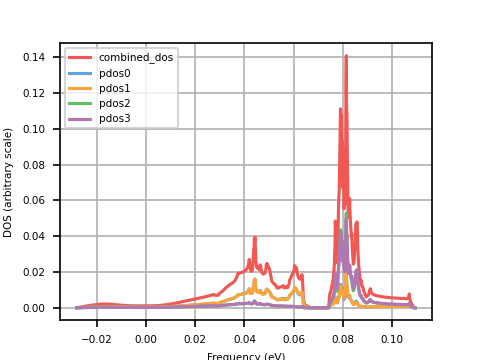

In [15]:
dosana_raw.plot()
#NB: you can use another unit:
#dosana_raw.plot(unit='THz')
#dosana_raw.plot(unit='1/cm')

We see in the plot that the PhononDOSAnalyser have extracted 1 combined DOS and 4 PDOS curves. The PDOS curves are numbered, in the same order as the corresponding columns in the input data. So from the discussion above, we would expect that the `pdos0` and `pdos1` curves are associated with aluminium atoms, while the `pdos2` and `pdos3` curves are associated with `N` atoms. 

Zooming in to the plot above, we indeed see that the `pdos0` and `pdos1` curves are essentially identical, and the same goes for the `pdos2` and `pdos3` curves. This is to be expected, since in aluminium nitride, the two Al atoms are actually occupying symmetrically equivalent positions, and the same goes for the two N atoms.

*Note: For some materials it might be the case that not all atoms of a particular type are in symmetrically equivalent positions, and in that case the DOS curves for the different positions might look different. In that case, one would need to treat them differently, and make sure the different curves would get assigned to the correct atoms in the NCMATComposer, but that is beyond the scope of this tutorial (feel free to reach out to the NCrystal developers if that is the case - preferably on GitHub).*

To reflect our understandings, we will merge and rename the PDOS curves, and get rid of the `'combined_dos'` curve. The following short code does just that, but please note two things: 1) we assign new labels which are proper atomic symbols (because it makes interactions with an `NCMATComposer` later a bit easier); 2) `PhononDOSAnalyser` objects are immutable, so we must write `dosana = dosana.merge(..)` instead of just `dosana.merge(..)`:

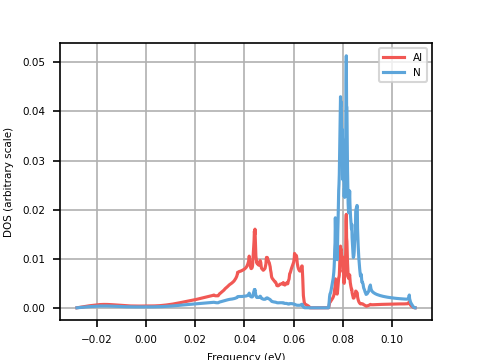

In [16]:
dosana = dosana_raw.merge('pdos0','pdos1',newlabel='Al')
#NB: If merging not needed, you can instead rename with: dosana = dosana.update_label('pdos0','Al')
dosana = dosana.merge('pdos2','pdos3',newlabel='N')
dosana = dosana.drop('combined_dos')
dosana.plot()

Voila!

## Get rid of problematic artifacts
So now we have just two curves! But, alas, they are *still* not ready to be used by NCrystal yet! The DOS curves do not vanish at 0, and they even extend into the negative frequencies! This is even more clear in a log plot:

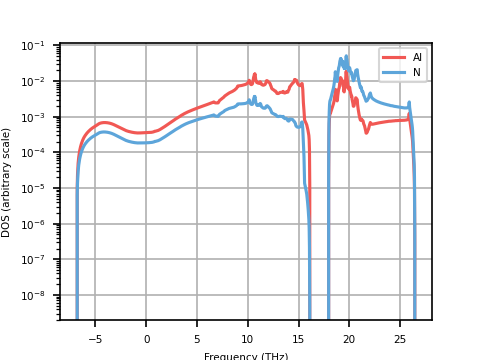

In [17]:
dosana.plot(unit='THz',logy=True)

Of course the VDOS should not be defined for negative frequencies, and as discussed in other notebooks it is also crucial that the curve tends to 0 like $(\text{frequency})^2$, otherwise many VDOS-based quantities become ill-defined.

It is beyond the scope of the present notebook (and author) to go into the details of **why** the VDOS curves from codes like Quantum Espresso contain artifacts like these tails into the negative frequencies, but it is **not** beyond the scope for us to get out a big knife 🔪 and cut them away! In other words, we will simply pick a suitable frequency value, and brutally impose a cutoff, in the sense of ignoring the actual DOS curve below that point and instead let it tend to 0 like $(\text{frequency})^2$.

However, we will not pick a cutoff value blindly. Rather, we will use a bit of intuition, and check the effect the cutoff value will actually have on both underlying curves as well as the final NCrystal cross sections.

### Initial inspection and choice of cutoff candidates

Looking at the plots above, we certainly want to place the cut below any obvious features (like peaks), so as to not remove any genuine and interesting feature like that from the DOS curve. So we choose to investigate a bunch of cutoff values, as high as `0.03eV`, and as low as "close to but not quite" to 0, which we simply take to be `0.001eV` in this case. Having decided that, we start off by using the `.plot_cutoff_effects(..)` method to see how the DOS itself will change under various cutoffs in this range:

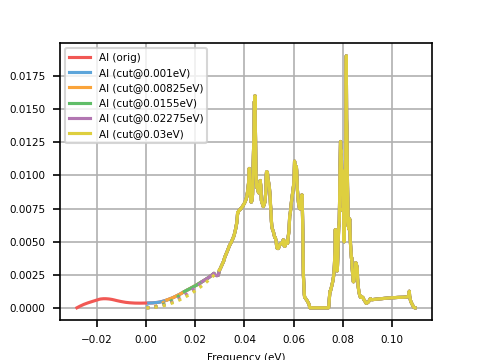

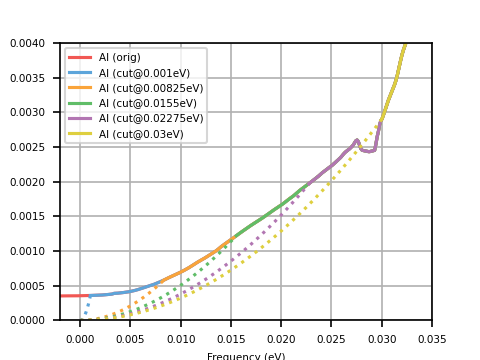

In [18]:
import numpy as np
cutoff_candidates = np.linspace(0.001,0.03,5)
dosana.plot_cutoff_effects(cutoff_candidates,'Al')
#Zoom of the same plot:
dosana.plot_cutoff_effects(cutoff_candidates,'Al',xmin=-0.002,xmax=0.035,ymin=0,ymax=0.004)

Looking at the plot, we can already conclude that a cut at 0.030 would cut into the feature (small dip) around 0.027-0.030. And a cutoff at 0.001 (or even 0.00825) would give a rather nasty kink in the resulting curve. So already from this, we can start to conclude that a cutoff value around 0.01-0.025 is likely what we want. However, for pedagogical reasons we will keep the full list of cutoff candidates for the following investigations as well.

For good measure we show the analogous plots for nitrogen as well:

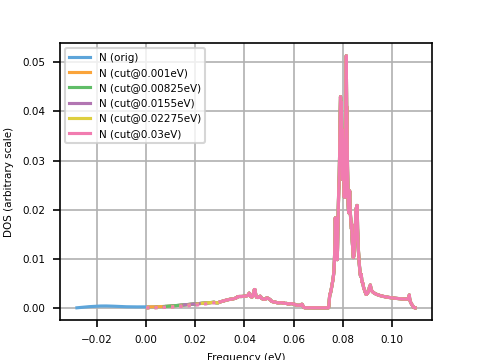

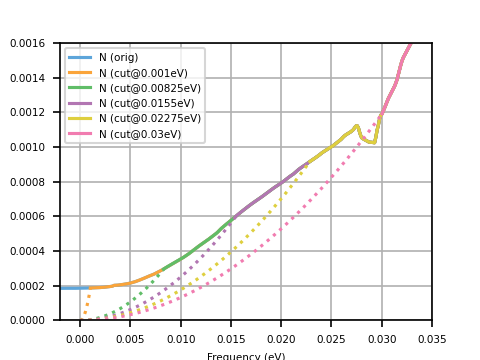

In [19]:
dosana.plot_cutoff_effects(cutoff_candidates,'N')
#Zoom of the same plot:
dosana.plot_cutoff_effects(cutoff_candidates,'N',xmin=-0.002,xmax=0.035,ymin=0,ymax=0.0016)

We see that the nitrogen and aluminium curves don't really differ as far as choosing a cutoff value is concerned, so in the rest of the notebook we will for simplicity simply apply the same cutoff value to both. Of course, you don't *have* to use the same cutoff value for the two DOS curves, but here (as will most often be the case) it looks like a reasonable choice.

### Cutoff effect on final cross sections

The next thing we will do, is to investigate the effect of the cutoff value on the final cross sections of the material where the DOS curves will be used. For that, we will use the `.plot_cutoff_effect_on_xsects` method. To include all cross-sections, the code need the crystal structure as well, so we will be passing in the `composer_xtal` object which contains just that.

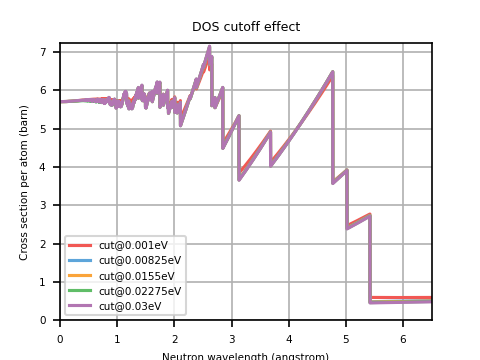

In [20]:
dosana.plot_cutoff_effects_on_xsects(composer_xtal,cutoff_candidates)

This plot actually is very reassuring! It tells us that the total scattering cross section of the material is *not* very sensitive to which cutoff value we choose. However, there is actually a bit more going under the hood, as we can see if you plot the elastic and inelastic parts of the cross sections separately:

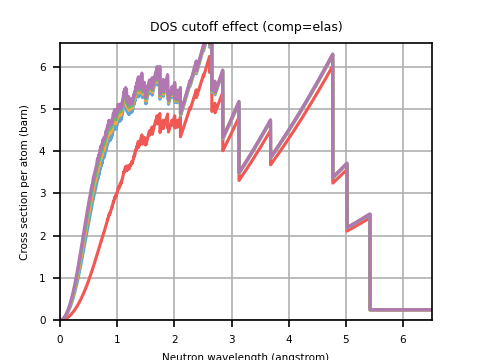

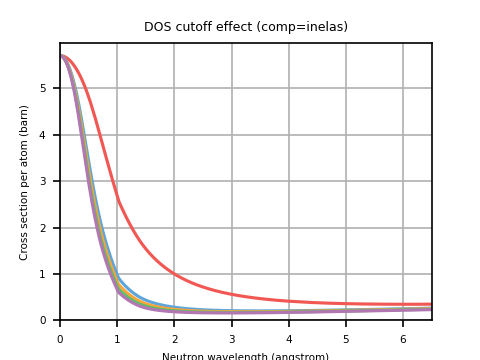

In [21]:
dosana.plot_cutoff_effects_on_xsects(composer_xtal,cutoff_candidates,'comp=elas',do_legend=False)
dosana.plot_cutoff_effects_on_xsects(composer_xtal,cutoff_candidates,'comp=inelas',do_legend=False)

Here, the spread between the curves is a bit higher than before, and in particular the curve with the lowest cutoff value of 0.001eV stands out. By lowering the cutoff value, it seems we are removing elastic cross section and adding inelastic cross section. To understand how this comes to be, we can look at the cutoff effect on the Sjölander G1 function, as well as remind ourselves that the .

## Cutoff effects on (pure) elastic physics through Debye-Waller factors

The strength of elastic physics increases the more tightly bound atoms are bound in the solid, and this effect is captured in NCrystal's pure-elastic ($\Delta\text{E}=0$) in the equations through the so-called Debye-Waller factors. The mean-squared atomic displacements $\delta^2$ of the atoms is a measure of this, and can be derived directly from VDOS curves.

More specifically, the mean-squared atomic displacements at a given temperature is determined by an integral over the DOS curve multiplied by a function $f(E)=\frac{1}{E\tanh(E/2kT)}$, which near 0 goes like $\approx\frac{1}{E^2}$.

This means that: **a VDOS curve with more of it's density at small values of $E$ will be associated with higher mean-squared atomic displacement values, which again means lower elastic cross sections.** So, lowering the dcutoff value should decrease the cross sections reported by NCrystal's pure-elastic models. Which is exactly what we see.

## Cutoff effect on inelastic physics through Sjölanders $G_1$ function
Technically, the construction of the $G_1$ function is the first step in the procedure of expanding a 1D VDOS curve into a 2D scattering kernel from which one can derive inelastic cross sections. We go into more details about that in another notebook, but here we should note that the $G_1$ function give an approximate view of the energy transfers a neutron will undergo in an inelastic scattering. If $\rho_\text{DOS}(E)$ is the VDOS, then the $G_1$ function is defined as (up to a normalisation factor):

* $G_1(E) = \frac{\rho_\text{DOS}(|E|)}{E}\left[\coth(E/2kT)-1\right]$

The factor inside the parenthesis is essentially a Boltzmann factor providing *detailed balance*, reflecting that the phonon state population at a given energy depends on the temperature.

We will not go into details here about the full procedure of how inelastic cross sections arise from the $G_1$ function, but simply have a quick look at them by supplying the `gn=1` argument to the `.plot_cutoff_effects` method:

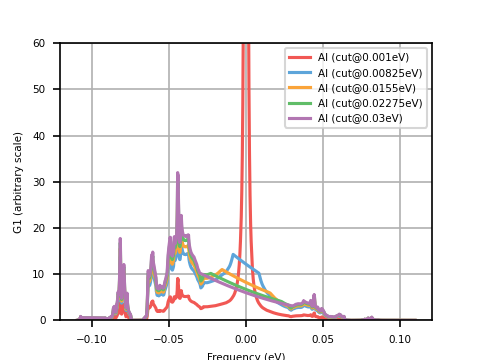

In [22]:
#Just plotting for 'Al', the effect on 'N' is similar:
dosana.plot_cutoff_effects(cutoff_candidates,'Al',gn=1,ymin=0,ymax=60)
#dosana.plot_cutoff_effects(cutoff_candidates,'N',do_legend=False,gn=1)

So we see what is happening here: Lowering the cutoff introduces an increasingly strong quasi-elastic peak in the inelastic scattering kernel. Thus:

* **Moving the cutoff value down has the technical effect of moving cross section from the pure-elastic to the quasy-elastic parts of the code, and vice versa!**

The only caveat here is that we are (currently) only modelling the coherent-inelastic components via the incoherent approximation, so there is strictly speaking a higher-order effect remaining from moving the threshold around. But all things considered, the take-away message is that the physics is not highly sensitive to where we put the cutoff - as long as we stay away from "very low" cutoff values, and of course avoid cutting into features (peaks/dips) of the VDOS.

For the aluminium-nitride we are discussing here, we stand by our initial hunch that any cutoff value in the range 0.01..0.025 (10-25meV) is likely a fine choice. So we will simply pick a number in the middle of that range, 17.5meV, and proceed.

## Applying the chosen cutoff and creating the material

Finally, we can apply the cutoff and view the fully prepared DOS curves:

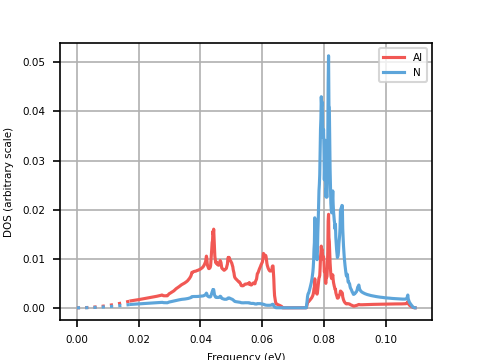

In [23]:
dosana_final = dosana.apply_cutoff(0.0175)
dosana_final.plot()

And now, let us combine it with the crystal structure and have a look at the NCMAT file:

In [24]:
composer_final = composer_xtal.clone()#<--clone the crystal structure
dosana_final.apply_to( composer_final )#<-- transfer the VDOS curves
print( composer_final() )#Tada!

NCMAT v7
# Autogenerated by NCMATComposer
#
# AlN (hexagonal, SG-186)
#
# Atoms per unit cell: 2xAl+2xN
#
# Structure converted (with NCrystal.cifutils module) from:
#
#   Anonymous CIF data
#
# IMPORTANT NOTICE: This is a mostly automatic conversion which has not been
#                   verified!  In particular the @DYNINFO sections might need
#                   post-editing. Before distributing this file to other people,
#                   please review this, amend the comments here to document,
#                   anything done, and remove this notice.
#
# Notice: The following WARNINGS were emitted when loading the CIF data:
#
#   NCrystalUserWarning : Structure received minor corrections by spglib (at the 0.000471405% level)
#
# NOTICE: Data here is based on an ASE (Atoms) structure through a conversion to CIF format.
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  lengths 3.13067 !! 5.01931
  angles 90 90 120
@SPACEGROUP
  186
@ATOMPOSITIO

Voila! Finally, celebrate by inspecting the material and storing the result in a file for future usage:

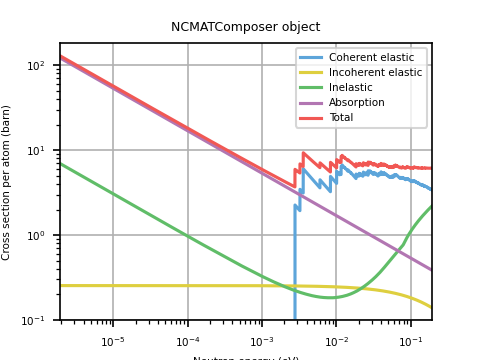

PosixPath('AlN_sg186.ncmat')

In [25]:
composer_final.plot_xsect( mode='ekin' )
composer_final.write('AlN_sg186.ncmat')#use .register_as instead of .write if you only wanted a virtual file.

We can also load the NCMAT file and confirm that we see the VDOS curves again:

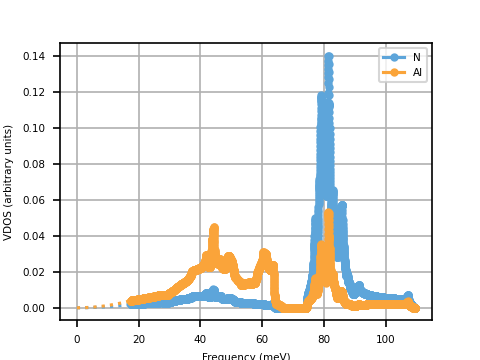

In [26]:
info = NC.createInfo('./AlN_sg186.ncmat')
NC.plot.plot_vdos(*info.dyninfos)

## Comparing with existing material
Now, we also have aluminium-nitride as a material in the NCrystal standard data library where it was put thanks to efforts by Kemal Ramic (checkout the comments in the NCMAT data below for references).

In [27]:
print(NC.createTextData('stdlib::AlN_sg186_AluminumNitride.ncmat').rawData)

NCMAT v5
#
# Aluminum nitride (AlN, hexagonal, SG-186 / P6_3mc)
#
# Under usual conditions this phase exists from 0 to 2770K.
#
# Structure converted with ncrystal_onlinedb2ncmat from:
#
#    "Electronic, optical, and structural properties of some wurtzite crystals"
#    Xu, Y. N. and Ching, W. Y. (1993)
#    DOI: https://dx.doi.org/10.1103/PhysRevB.48.4335
#    Crystallography Open Database entry 9011657
#    https://www.crystallography.net/cod/9011657.html
#
# This crystal structure is also compatible with structure obtained from
# https://www.materialsproject.org/materials/mp-661
#
# The VDOS curves were calculated using Phonopy[1] input files from[2] and
# OCLIMAX[3] software by Kemal Ramic from ESS Spallation Physics group.
#
# References:
#  [1]: "First principles phonon calculations in materials science",
#        Atsushi Togo and Isao Tanaka, Scr. Mater., 108, 1-5 (2015)
#  [2]: Kyoto University database of phonon calculations.
#       Files for AlN taken from:
#       http://p

 So, we can see how our new material compares with that, as well as with the material which did not have the VDOS curve:

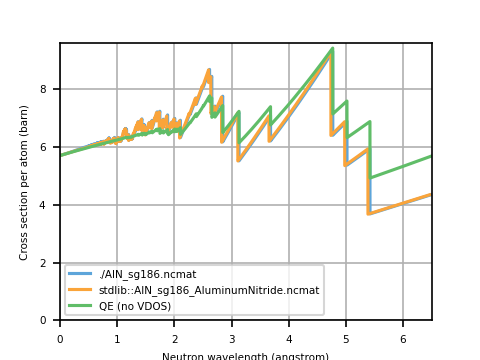

In [28]:
NC.plot.plot_xsects('./AlN_sg186.ncmat',
                    'stdlib::AlN_sg186_AluminumNitride.ncmat',
                    NC.NCMATComposer(composer_xtal,plotlabel='QE (no VDOS)'))

Our new material agrees very well with the one from the standard library indeed! And the material absent VDOS curves is certainly the odd one out. We can also go a bit deeper and compare the actual VDOS curves:

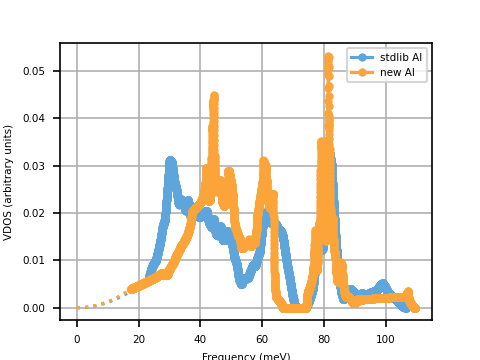

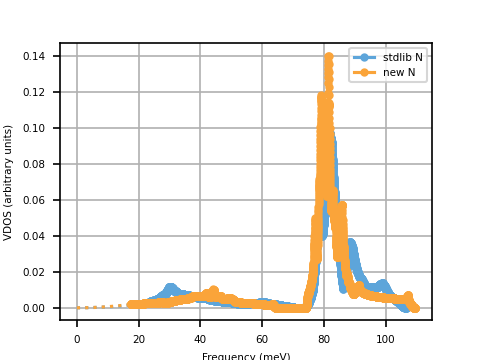

In [29]:
info_new = NC.createInfo('./AlN_sg186.ncmat')
info_std = NC.createInfo('stdlib::AlN_sg186_AluminumNitride.ncmat')
from NCrystal.misc import AnyVDOS#We use this wrapper to easily change the label
for n in ['Al','N']:
    NC.plot.plot_vdos( AnyVDOS(info_std.findDynInfo(n),label=f'stdlib {n}'),
                       AnyVDOS(info_new.findDynInfo(n),label=f'new {n}') )

Not so bad, despite a few differences!